# Error analysis notebook (test data)

## Import packages

In [1]:
import pandas as pd
import math

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")


## Set filepaths

#### Meta, DocHLevel

In [2]:
ranking = '../evaluation/resources/2020/jsonruns/p_controller_train_nle_meta_9_1_train.json'
eval_result = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_9_1_train.tsv'
gt = '../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample.json'
est_rel_meta_p = '../reranking/resources/relevances/Training_rel_scores_model_A.csv'
annotations = '../pre_pre_processing/resources/merged-annotations.json'

## Prepare dataframes

In [8]:
# ranking df
rdf = pd.read_json(ranking, lines=True)

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result df
edf = pd.read_csv(eval_result, sep='\t', names=['key', 'qid', 'value'])
edf = edf.pivot(index='qid', columns='key', values='value')

# est rel df
est_rel_meta = pd.read_csv(est_rel_meta_p)
est_rel_meta.head()

# annotations
adf = pd.read_json(annotations,lines=True)
adf = adf.explode('authors')
adf[['name','wiki','country','type','valid','auth_id', 'h_index','level','region']] = adf.authors.apply(pd.Series).rename({'id':'auth_id'},axis=1)

In [4]:
rdf.head(2)

q_num   qid                                            ranking
0    0.0  5438  [b2fdee22aa02477292b858fbafcb418932732bce, 993...
1    0.1  5438  [70f3a58b0fc6916c2e6616bfbae5758c00408894, ec1...

In [5]:
gtdf.head(2)

qid            query  frequency  \
0  5438  cloud computing   0.000057   
0  5438  cloud computing   0.000057   

                                           documents  \
0  {'doc_id': '3e19046c665867bbe557685da60738a407...   
0  {'doc_id': '7ef08f1fa127af817cdfd9d3bd00bdf60e...   

                                     doc_id  doc_rel  
0  3e19046c665867bbe557685da60738a40738010a        0  
0  7ef08f1fa127af817cdfd9d3bd00bdf60e32143b        0

In [6]:
reldf.head(2)

qid            query                                    doc_id  doc_rel
0  5438  cloud computing  3e19046c665867bbe557685da60738a40738010a        0
0  5438  cloud computing  7ef08f1fa127af817cdfd9d3bd00bdf60e32143b        0

In [7]:
edf.head(2)

key  difference  disparity  relevance
qid                                  
69     0.146308   2.820826   2.254359
258    0.549351   1.043557   0.679082

In [9]:
adf.head(2)

id  missing_authors  \
0  f3b7db81ee8642cf2deab7a9834e07b8df54185b            False   
0  f3b7db81ee8642cf2deab7a9834e07b8df54185b            False   

                                             authors                name  \
0  {'name': 'David M. Szymanski', 'wiki': 'Texas ...  David M. Szymanski   
0  {'name': 'David H. Henard', 'wiki': 'North Car...     David H. Henard   

                              wiki country      type  valid      auth_id  \
0             Texas A&M University      US  academic   True   50215565.0   
0  North Carolina State University      US  academic   True  115002169.0   

   h_index     level    region  
0      9.0  Advanced  Americas  
0      8.0  Advanced  Americas

## Select queries/rankings to inspect

[1] select the queries/rankings to inspect based on the MAP value of the rankings. One of the criteria is to select queries whose ranking's MAP is lower than the average for all queries/systems. The metric for our system is Difference in Group Expected Exposure (DGEE).

In [10]:
edf.difference.mean()

0.43443999

In [11]:
print(edf[edf.difference > edf.difference.mean()].count())
print()
print(edf[edf.difference <= edf.difference.mean()].count())

key
difference    65
disparity     65
relevance     65
dtype: int64

key
difference    135
disparity     135
relevance     135
dtype: int64


The worst ten queries are:

In [12]:
edf.sort_values(by='difference',ascending=False).head(10)

key     difference  disparity  relevance
qid                                     
111469    2.834201   2.170455   0.463842
31412     2.778232   2.016028   0.413475
33337     2.726048   2.320659   0.603397
47984     2.577560   2.464784   0.344646
5762      2.339087   1.462709   0.352224
11856     1.930131   1.856165   0.371319
125125    1.687319   1.136316   0.509687
84087     1.513666   1.270282   0.696999
76875     1.464672   1.654475   0.507753
30631     1.350312   1.633312   0.566124

The best ten queries are:

In [13]:
edf.sort_values(by='difference',ascending=True).head(10)

key     difference  disparity  relevance
qid                                     
132049    0.002713   1.421254   1.403715
71096     0.029287   1.975807   1.862498
21984     0.032334   1.367385   1.271935
15395     0.040510   2.053024   1.890567
52728     0.057478   1.047360   0.839632
35778     0.063421   2.324523   2.033133
96265     0.068044   1.389924   1.122292
5667      0.068762   1.593546   1.318426
46183     0.076931   1.775022   1.730961
82442     0.081747   2.560092   2.162663

## Extract information for specific query

In [14]:
def extract_results_based_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevances_based_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

## Visualization

We use different visualizations to gain more insight into the way rankings are formed.

- Given a query with N documents to be re-ranked, for each rank in a list of size N we compute the number of times a relevant or non-relevant item appears at this rank. For poorly performing queries, we expect to see more non-relevant items in top positions and fewer relevant items. These plots can show us whether the relevant items occur towards the middle or the back of the rankings instead.
    - We either plot the relevant and non-relevant items per rank in the same plot, or in separate plots. The separate plots are more readable, since the number of relevant and non-relevant documents across 150 rankings are in different orders of magnitude.
    
    
- Given a query with N documents to be re-ranked, for a specific rank in a list of size N we compute how often each of the documents occurs at that rank. We color-code the documents by relevant/non-relevant. In an ideal scenario, we expect all relevant documents to occur roughly equally as often at the top positions, and more often than non-relevant documents at that. For non-relevant documents, we expect the same behavior at bottom positions. Departures from this behavior can show us whether there are documents that are treated differently than they should. Inspecting these documents may teach us more about *why* they show up in a place where they do not belong.


- Complementary to the previous plot, we show the number of times each document occurs in a "top" or in a "bottom" position. Under the expected exposure model [2], an ideal ranking is any ranking where all documents with a higher relevance grade are followed by all documents with a lower relevance grade. For example, if doc1 and doc2 both have relevance 1, then a ranking that starts as [doc1, doc2, ...] is identical in quality to one that starts with [doc2, doc1, ...]. A "top" position is then any position with rank <= # relevant documents, and a "bottom" position is any position with rank > # relevant documents. 

  In an ideal scenario, we expect each relevant document to occur equally as often in a "top" position, and each non-relevant document to occur equally as often in a "bottom" position. The additional information gained by this plot compared to the previous plot is that we can see whether there are documents that are systematically in a "wrong" (top if they are non-relevant, bottom if they are relevant) position, where the previous plot only shows if they are missing from a *specific* top or bottom rank.

- 


We visualize how often a ranking position is occupied by a relevant versus a non-relevant document, aggregated over all 150 returned rankings for that query.


In [15]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

In [16]:
def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    return count_relgrades(subrelevance)
    

In [17]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    countdict = {k :{'r':0,'nr':0} for k in range(1,len(rankings_df['ranking'].iloc[0]) + 1)}
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [18]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

In [19]:
def count_doc_occurrence_per_rank(rankings_df):
    """Count how often each document occurs at each rank."""
    count_per_doc_per_rank = {i: {} for i in list(range(1,len(rankings_df['ranking'].iloc[0]) + 1))}

    for idx, row in rankings_df.iterrows():
        for j, doc in enumerate(row['ranking']):
            i = j + 1
            if not doc in count_per_doc_per_rank[i]:
                count_per_doc_per_rank[i][doc] = 0
            count_per_doc_per_rank[i][doc] = count_per_doc_per_rank[i][doc] + 1
    return count_per_doc_per_rank

In [20]:
def doc_occurrence_per_rank_to_sns_df(occurrence_dict, relevance_df):
    unpacked = [d for dlist in [[{'rank':k, 'doc_id':k2, 'count':v2} for k2, v2 in v.items()] for k,v in occurrence_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [21]:
def count_pos_of_documents(ranking_df, num_relevant_docs):
    doc_pos_count_dict = {}

    for idx, row in ranking_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            if not doc in doc_pos_count_dict:
                doc_pos_count_dict[doc] = {"top": 0, "bot": 0}
            if i < num_relevant_docs:
                doc_pos_count_dict[doc]["top"] = doc_pos_count_dict[doc]["top"] + 1
            else:
                doc_pos_count_dict[doc]["bot"] = doc_pos_count_dict[doc]["bot"] + 1

    return doc_pos_count_dict        

In [22]:
def document_pos_count_to_sns_df(doc_pos_count_dict, relevance_df):
    unpacked = [d for dlist in [[{'doc_id':k, 'pos':k2, 'count':v2} for k2, v2 in v.items()] for k,v in doc_pos_count_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [23]:
def plot_rel_nonrel_per_rank(data):
    """Plot the number of times a (non)relevant item appeared at a rank."""
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x="rank", y="count", hue="relkind", data=data)

In [24]:
def plot_rel_nonrel_per_rank_per_relkind(data,regline=False):
    """Plot the number of times a (non)relevant item appeared at a rank, split by rank."""
    
    pi = iter(sns.color_palette())
    f = next(pi)
    s = next(pi)
    next(pi)
    t = next(pi)

    fig, ax = plt.subplots(1,2,figsize = (17.7,8.27))
    ax[0].title.set_text('Relevant item counts')
    ax[1].title.set_text('Nonrelevant item counts')

    sns.barplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0],color=f)
    sns.barplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1],color=s)

    if regline:
        sns.regplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0], scatter_kws={"s": 0}, color=t)
        sns.regplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1], scatter_kws={"s": 0},color=t)
    return fig


In [25]:
def plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subranking, subrelevance)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    fig = plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,regline=regline)
    fig.suptitle(f"(Non-)relevant documents per rank for {qid}")
    

In [26]:
def plot_doc_occurrence_per_rank(data, k=2, rev=False):
    """Show how often each document in :data: appears at each rank <= k."""
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)
    
    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")
    
#     numrows = math.ceil(num_rel_docs / 2)
    fig, ax = plt.subplots(1, k, figsize = (9*k, 8))
    
    for i in range(0,k):
        rank = i + 1
        if rev:
            rank = len(set(data["rank"].to_list())) - rank
    
        thisaxdata = data[data['rank'] == rank].sort_values(by='count',ascending=False)
        
    
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        ax[i].title.set_text(f'Rank {rank}')
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
    return fig

In [27]:
def plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance, k=2, rev=False):
        subranking = extract_results_based_on_qid(qid, ranking)
        subrelevance = extract_relevances_based_on_qid(qid, relevance)
                
        doc_per_rank_counts = count_doc_occurrence_per_rank(subranking)
        rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subrelevance)
    
        fig = plot_doc_occurrence_per_rank(rank_occurrence_df, k, rev)
        fig.suptitle(f"Document counts per rank for {qid}")
    
    

In [28]:
def plot_doc_pos_count(data,numrel,numnrel,no_author_ids=None):
    """Plot how many times each document occurred in the top and bottom positions."""
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)

    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")


    fig, ax = plt.subplots(1, 2, figsize = (18, 8))
    _ = ax[0].title.set_text(f'Occurrence of doc in top pos (k={numrel})')
    _ = ax[1].title.set_text(f'Occurrence of doc in bottom pos (k={numnrel})')

    for i, pos in enumerate(["top","bot"]):
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        thisaxdata = data[data['pos'] == pos].sort_values(by='doc_rel',ascending=False)
        
        
       
        
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        
#         sc_bar = sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])

#         strange_id = thisaxdata.doc_id.to_list().index('87af1c341c257b2d2a702a10ac6dd8af04a9db02')
        
        if no_author_ids:
            thisaxdata['secondcount'] = thisaxdata.apply(lambda row: row['count'] if row['doc_id'] in no_author_ids else 0, axis=1)
            sns.barplot(x="doc_labels", y="secondcount",palette=clrs, data=thisaxdata,ax=ax[i],hatch='//')
#             hatches = ['//' if doc_id in no_author_ids else '..' for doc_id in thisaxdata.doc_id.to_list()]
#             bars = sc_bar.patches
#             print(bars)
#             for pat,bar in zip(hatches,bars):
#                 bar.set_hatch(pat)
#             print(hatches[strange_id])

        
     
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
        
  
    return fig


In [29]:
def plot_doc_pos_count_for_qid(qid, ranking, relevance, no_author_ids=None):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    doc_position_counts = count_pos_of_documents(subranking, num_rel_docs)
    doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subrelevance)
    fig = plot_doc_pos_count(doc_pos_count_df,num_rel_docs,num_nonrel_docs,no_author_ids)


    fig.suptitle(f"Document position counts {qid}")

    

In [30]:
def plots_for_qid(qid,ranking,relevance,k=2):
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False)
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=True)

    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k)
    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k,rev=True)
    plot_doc_pos_count_for_qid(qid, ranking, relevance)

### Worst query
We inspect the the worst-performing query.

In [40]:
inspect_qid = edf.sort_values(by='difference',ascending=False).reset_index().qid.iloc[0]
inspect_qid

111469

In [41]:
extract_results_based_on_qid(inspect_qid, rdf).head(5)

q_num     qid                                            ranking
8850   59.0  111469  [e60af557a1bbfd9b2adee8a3c090d27faab86632, 36d...
8851   59.1  111469  [e60af557a1bbfd9b2adee8a3c090d27faab86632, 36d...
8852   59.2  111469  [e60af557a1bbfd9b2adee8a3c090d27faab86632, 1d7...
8853   59.3  111469  [e60af557a1bbfd9b2adee8a3c090d27faab86632, af3...
8854   59.4  111469  [e60af557a1bbfd9b2adee8a3c090d27faab86632, 5fe...

In [42]:
extract_relevances_based_on_qid(inspect_qid, reldf).head(5)

qid   query                                    doc_id  doc_rel
59  111469  xiaomi  25c40e796680cdea53578dfad8c7bdbae7ee56a5        0
59  111469  xiaomi  647444c4963ddac18626a4d2817eb85e438405c0        1
59  111469  xiaomi  36dedcbd7ad1a9313b967e8e3b0dc0fa3df4f9ac        0
59  111469  xiaomi  ecf4c446122e770ca0d9031b9b8bdf7d6d40dc9b        0
59  111469  xiaomi  224289edb5ee14bbe960c061a58bd38adbf4f9d9        0

In [43]:
subrdf = extract_results_based_on_qid(inspect_qid, rdf)
subreldf = extract_relevances_based_on_qid(inspect_qid,reldf)

In [44]:
rel_counts = subreldf.doc_rel.value_counts()
rel_count = rel_counts[1]
nonrel_count = rel_counts[0]

In [45]:
rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)

In [46]:
rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
rel_nonrel_df.head(4)

rank relkind  count
0     1       r     13
1     1      nr    137
2     2       r     13
3     2      nr    137

We plot the number of relevant/nonrelevant items that appear at each rank. An issue with this approach is that most rankings contain more nonrelevant than relevant items. We split the plot into relevant and nonrelevant item counts for readability.

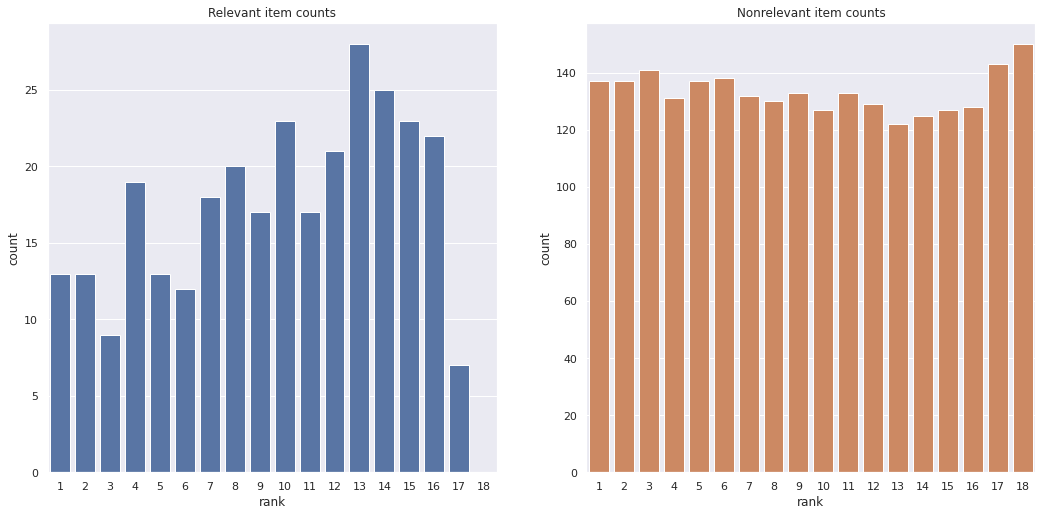

In [49]:
fig = plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,regline=False)

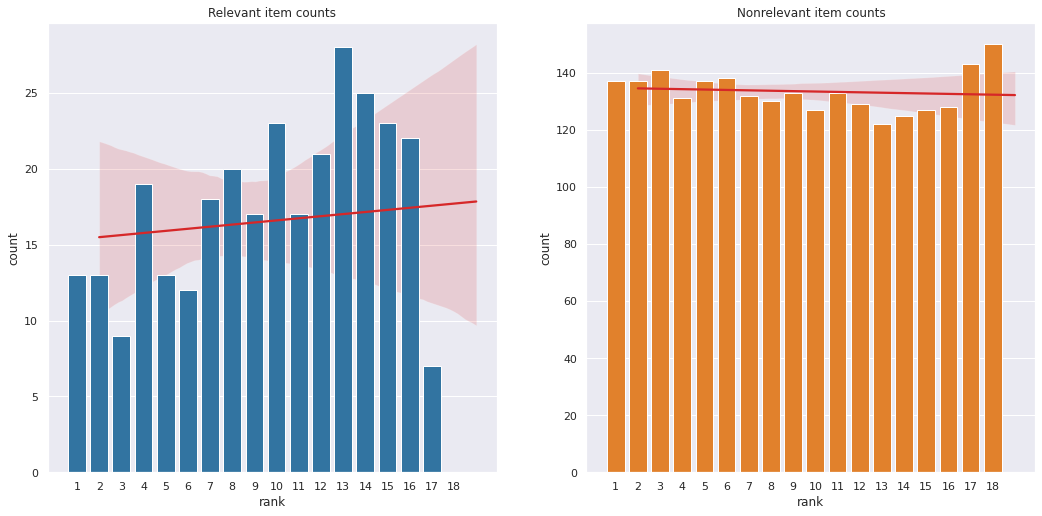

In [56]:
fig = plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,regline=True)

We see that the number of relevant items *increases* with increasing rank. This makes sense for a query that performs poorly, but we don't yet know *why* the relevant items are ranked towards the back. After all, if we ranked completely at random we would expect a uniform distribution instead.

In [57]:
doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)

In [58]:
rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts,subreldf)
rank_occurrence_df.head(4)

rank                                    doc_id  count  doc_rel
0     1  e60af557a1bbfd9b2adee8a3c090d27faab86632     88        0
1     1  5fea3a4e2d25d5ad0872d35704d2cbdf210639d9      6        0
2     1  34b6de1aee17441021e62b63c543abc1c28b0928      7        1
3     1  c0fb289dbcbf888bc8ff96661bfcbda519625fac      5        0

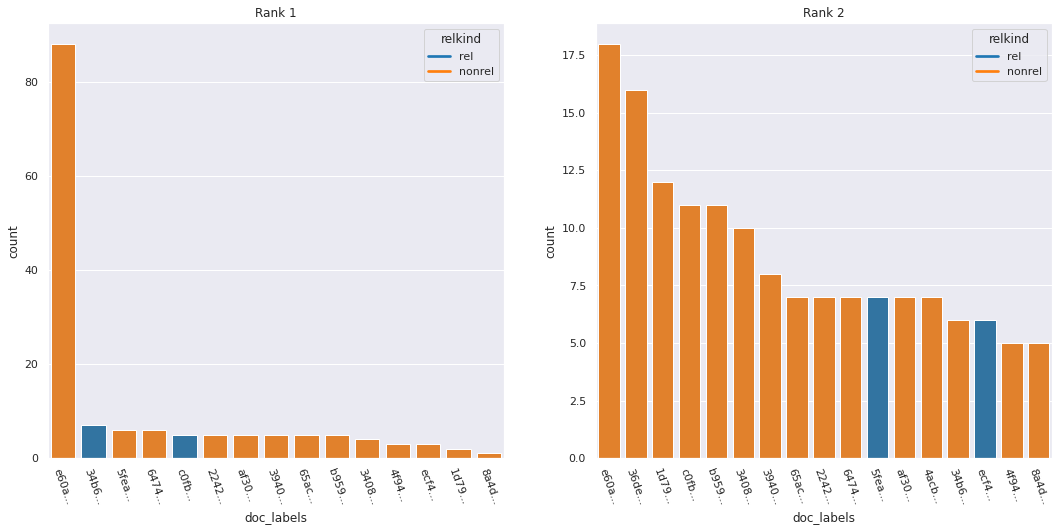

In [59]:
_ = plot_doc_occurrence_per_rank(rank_occurrence_df,rel_count)

In the figures above we see how many times each document was put in the first or second ranking position, aggregated across 150 rankings. The blue line indicates which document is relevant; only one relevant document is put in either the first or second rank, and only one time in the first and 5 times in the second ranking.

We also want to know how often each file was in a top position and how often it was in a bottom position. In the ideal case, we expect each relevant file to be equally often in the top positions and each irrelevant file to be equally often in the bottom positions.

In [60]:
doc_position_counts = count_pos_of_documents(subrdf, rel_count)

In [61]:
doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subreldf)
doc_pos_count_df.head(5)

doc_id  pos  count  doc_rel
0  e60af557a1bbfd9b2adee8a3c090d27faab86632  top    106        0
1  e60af557a1bbfd9b2adee8a3c090d27faab86632  bot     44        0
2  36dedcbd7ad1a9313b967e8e3b0dc0fa3df4f9ac  top     16        0
3  36dedcbd7ad1a9313b967e8e3b0dc0fa3df4f9ac  bot    134        0
4  af30c3a83f5c203f207a8865dd93c1cc3c13e186  top     12        0

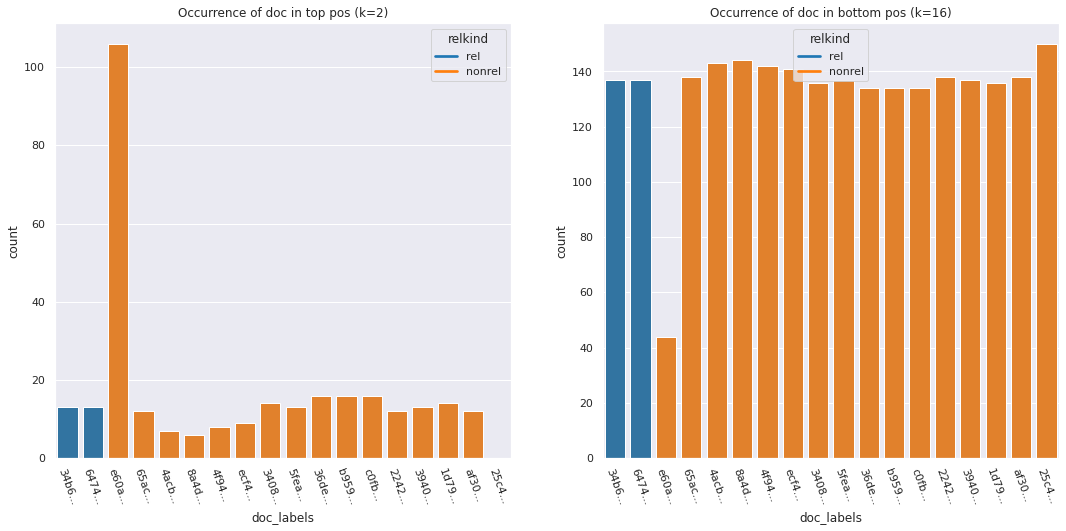

In [62]:
_ = plot_doc_pos_count(doc_pos_count_df,rel_count,nonrel_count)


We see that both non-relevant files occupy the top positions equally often. However, there is a single non-relevant file that occuppies the top positions even *more* often.

### Multiple queries
Let's compare multiple queries and see if we can determine a pattern.

In [63]:
topqueries = edf.sort_values(by='difference',ascending=True).head(10)
bottomqueries = edf.sort_values(by='difference',ascending=False).head(10)

#### (Non-)relevant documents at each rank
For the top and bottom k=10 queries, we plot the number of (non-)relevant items at each rank.

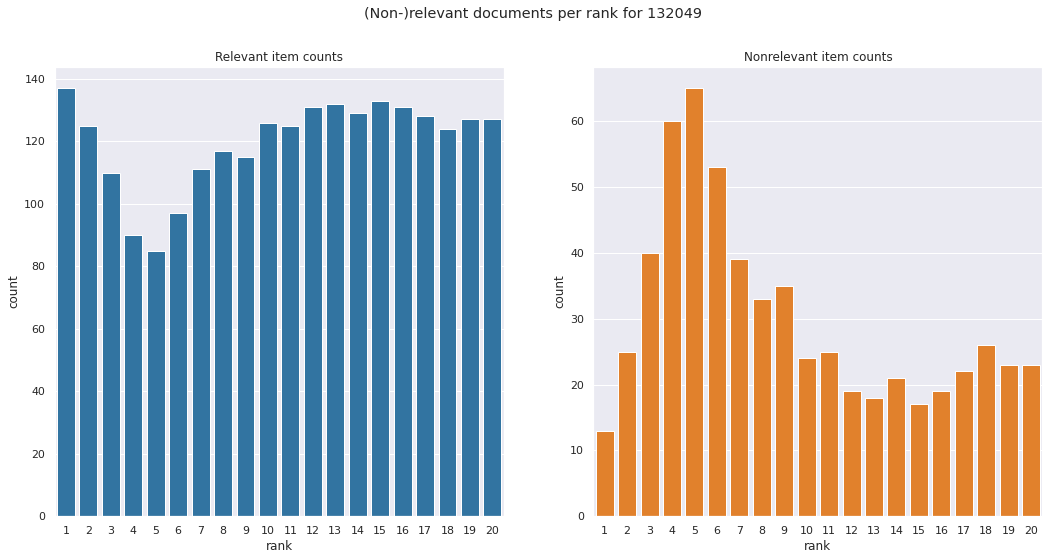

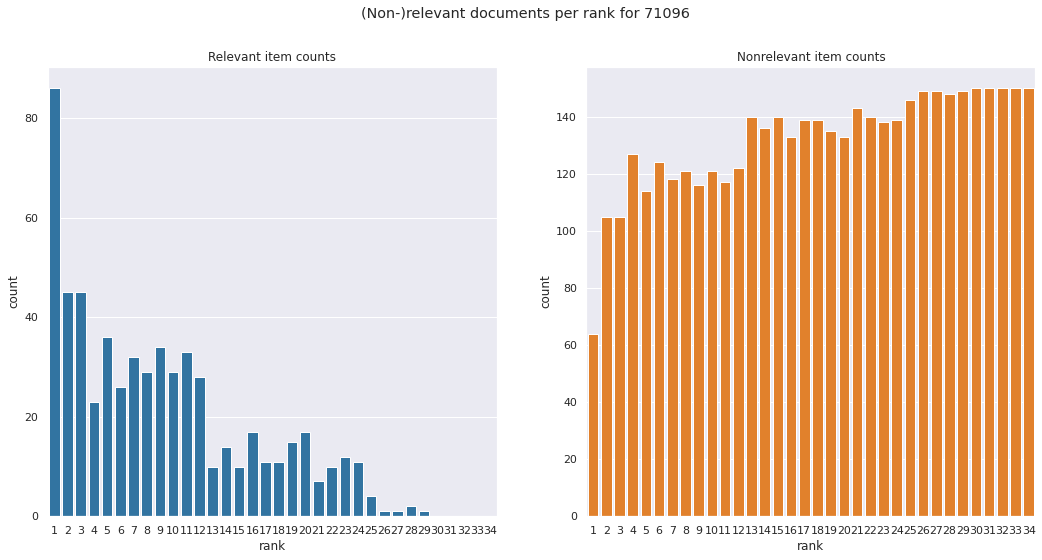

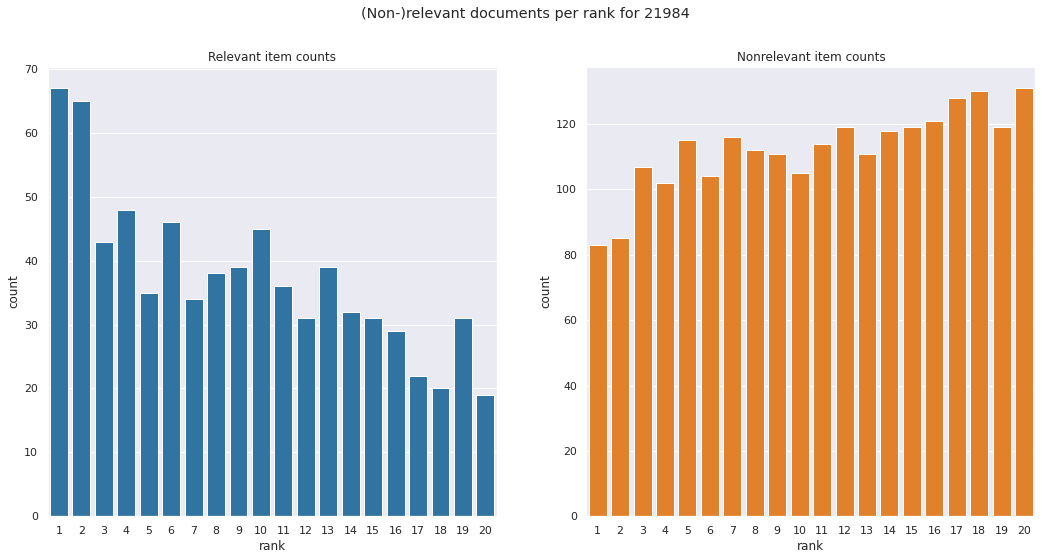

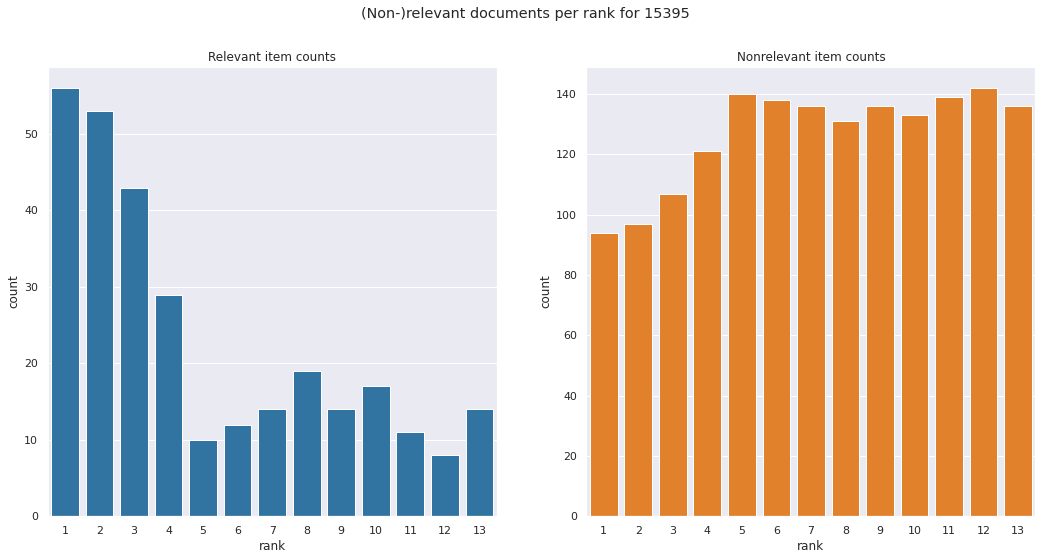

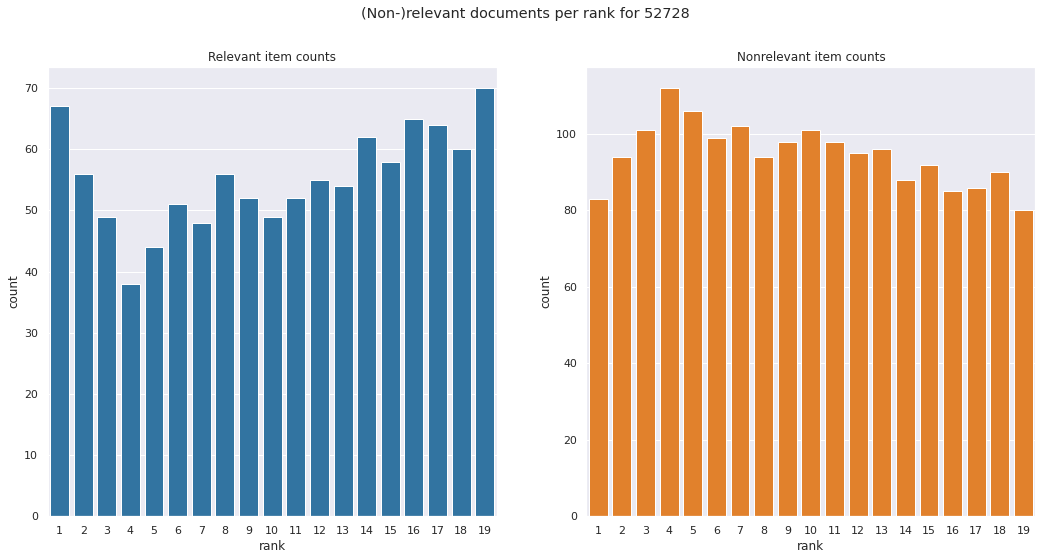

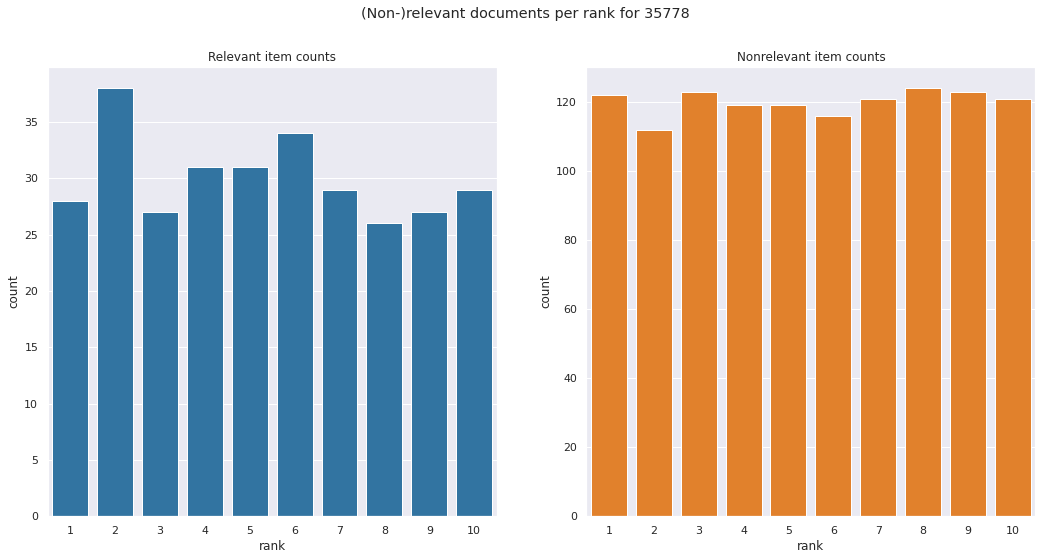

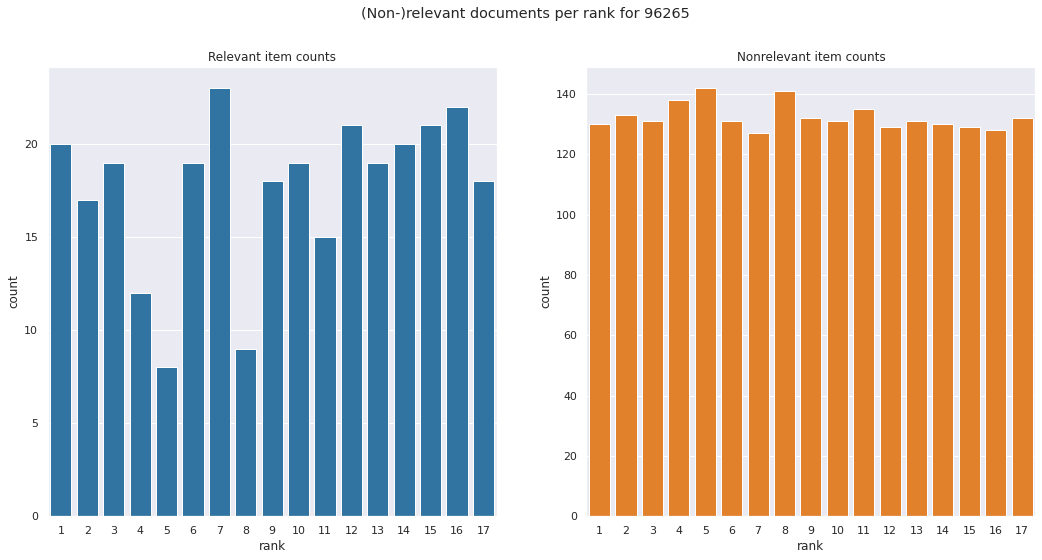

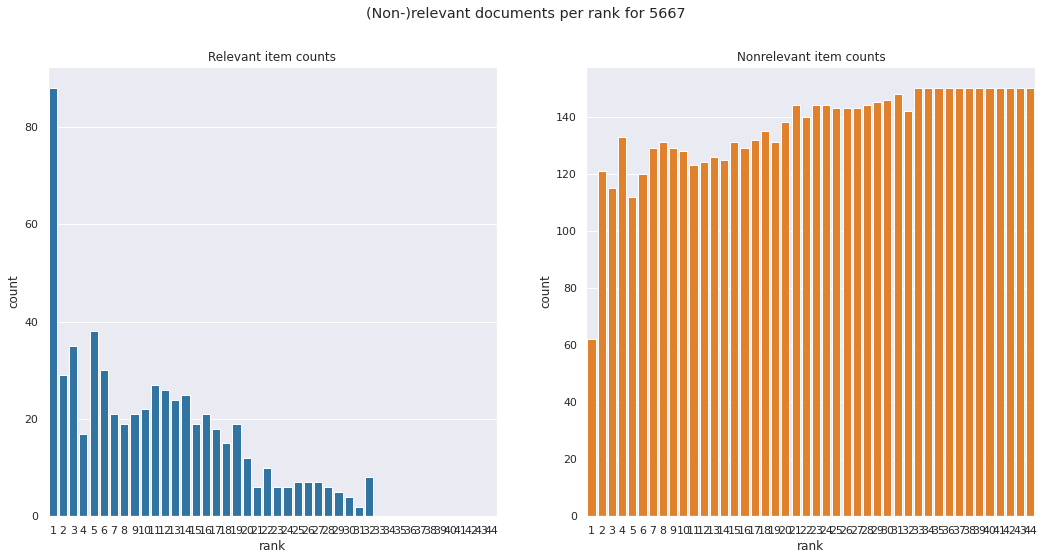

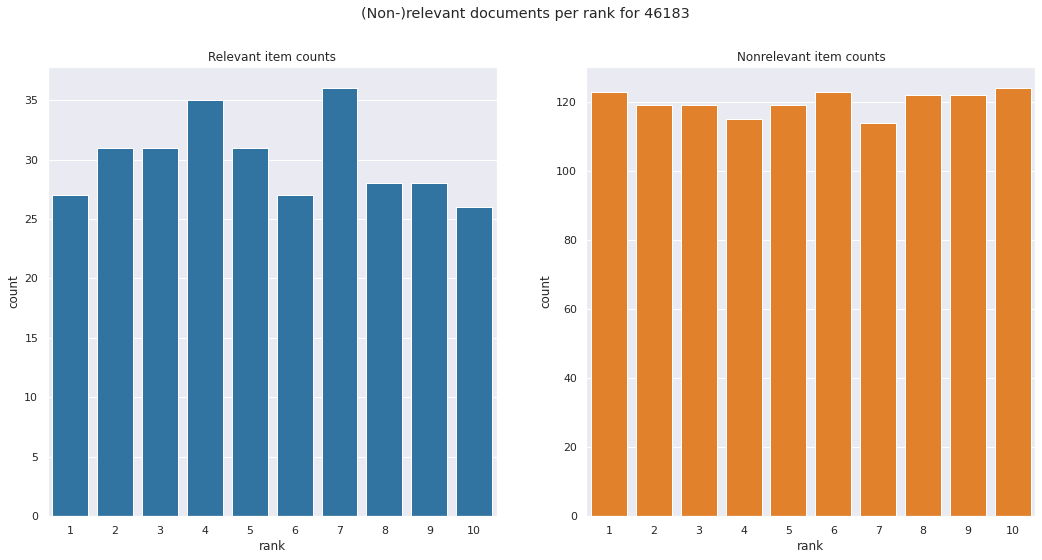

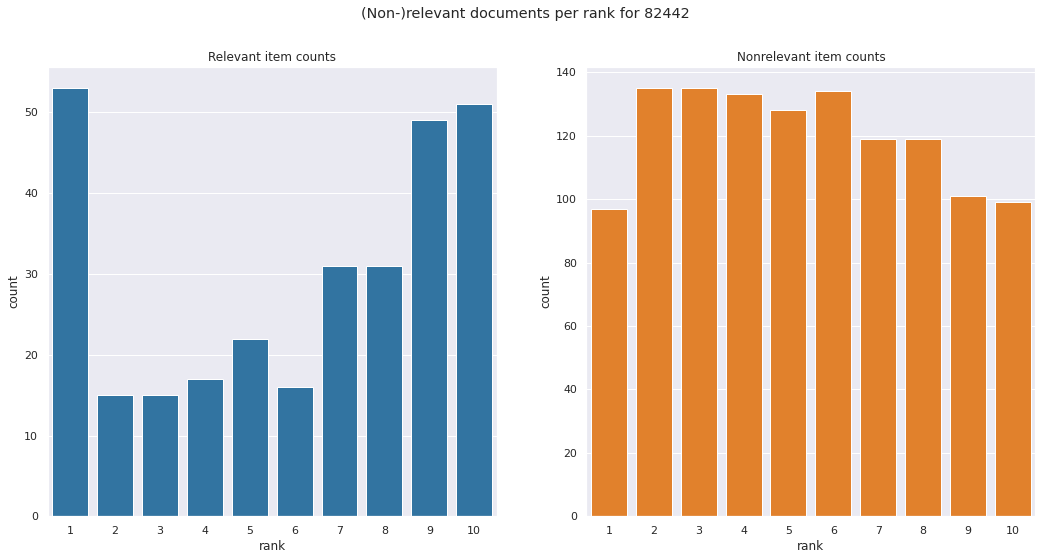

In [64]:
for q in topqueries.index.unique():
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)


##### Top queries
For the top queries, we see that the relevant documents are reasonably evenly distributed or skewed towards the higher rankings.

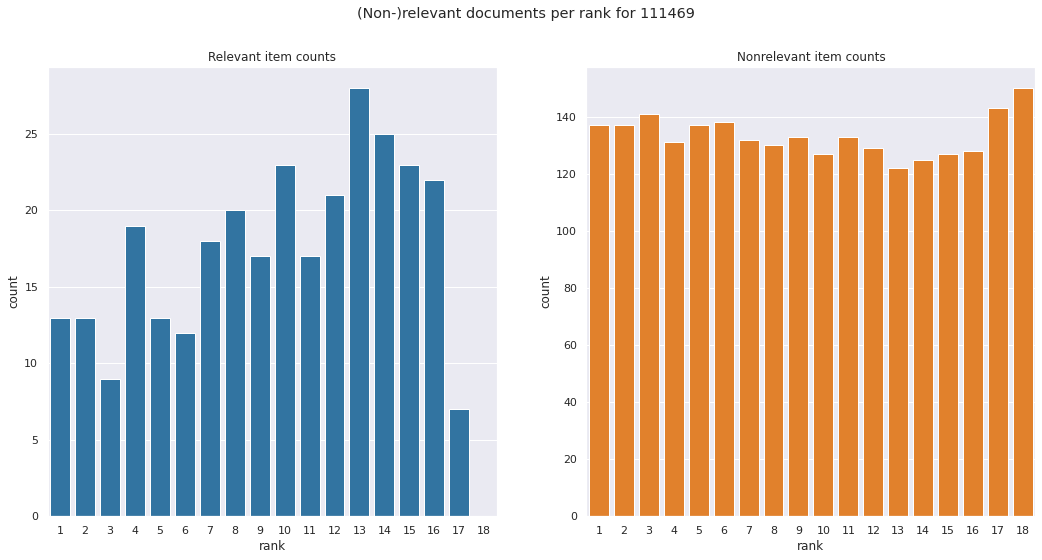

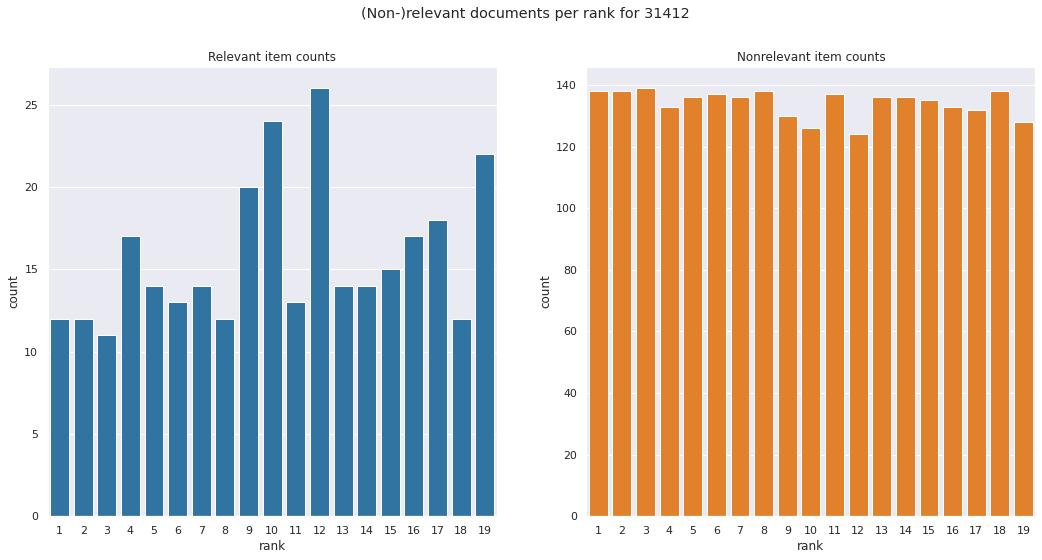

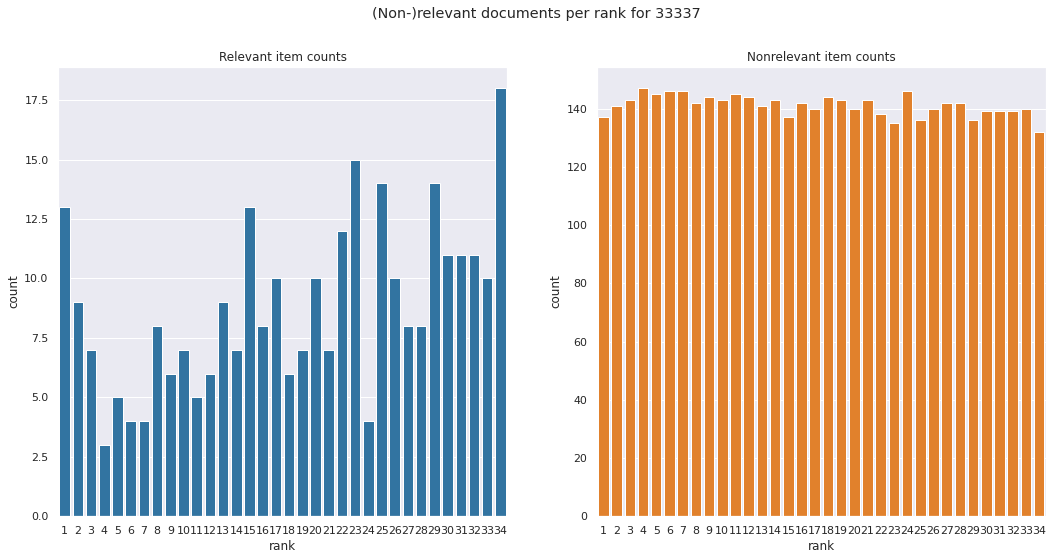

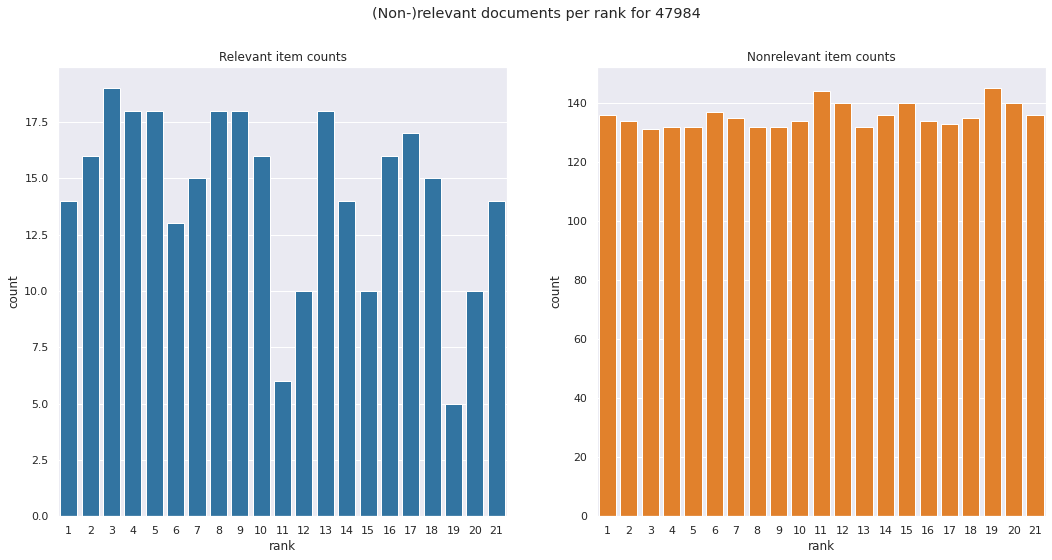

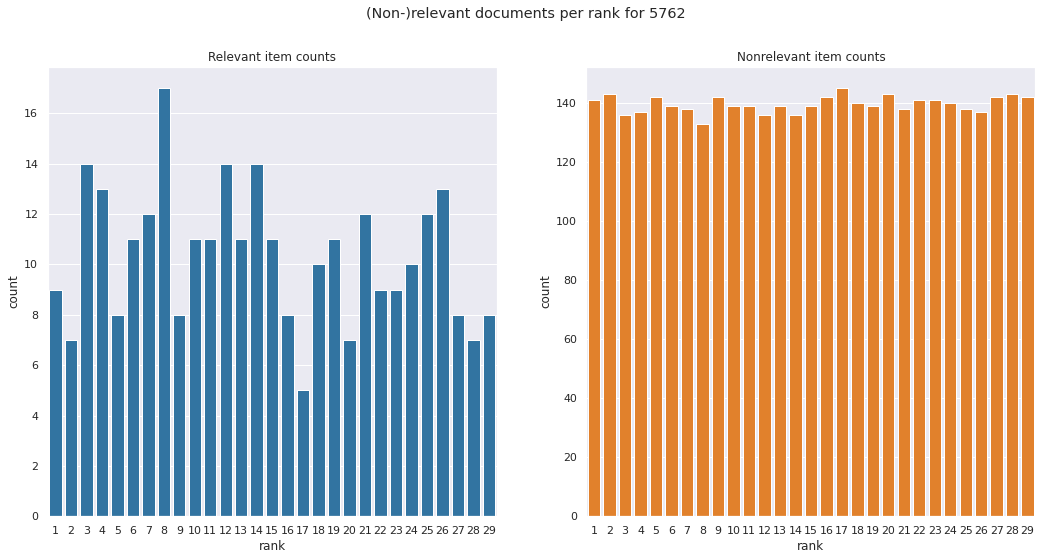

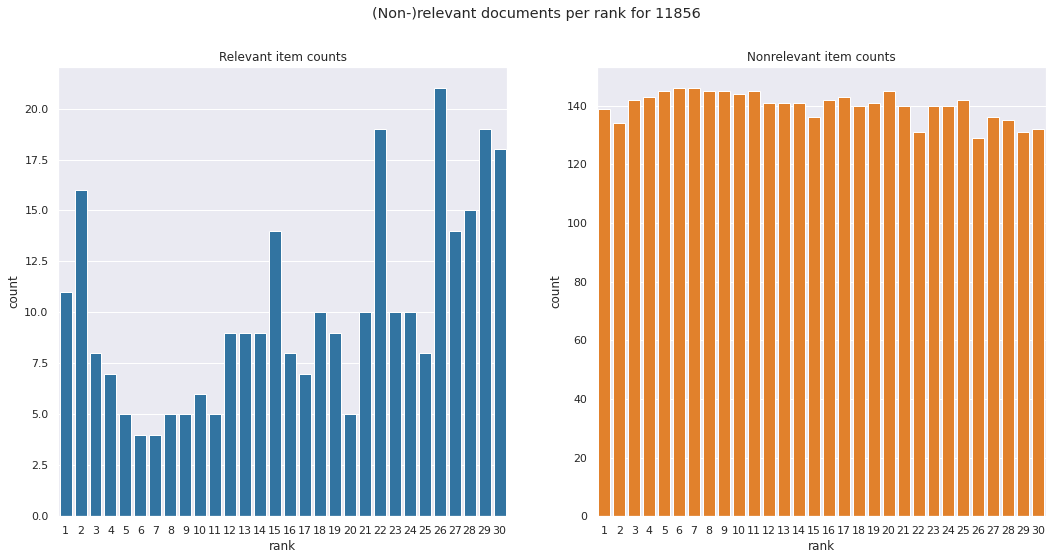

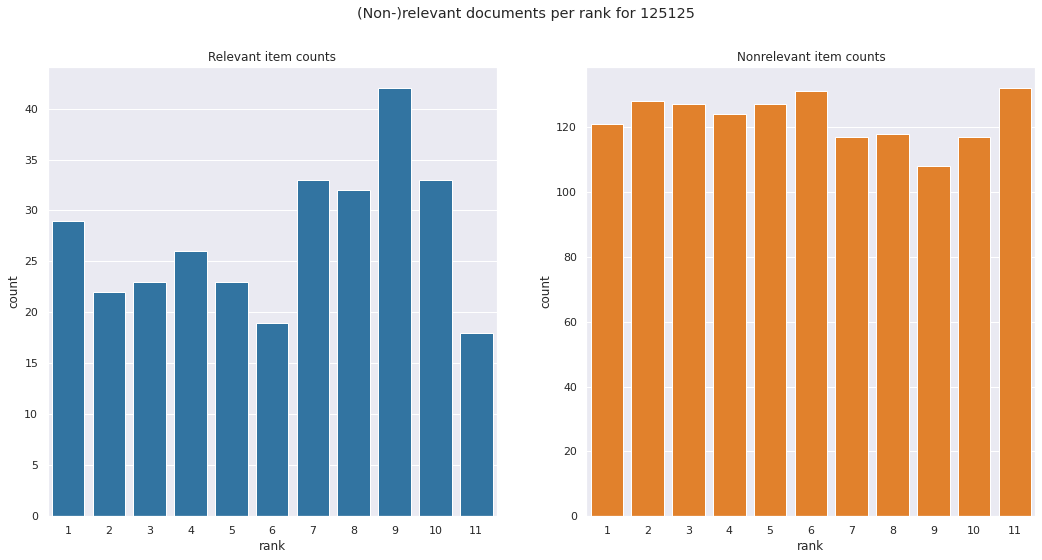

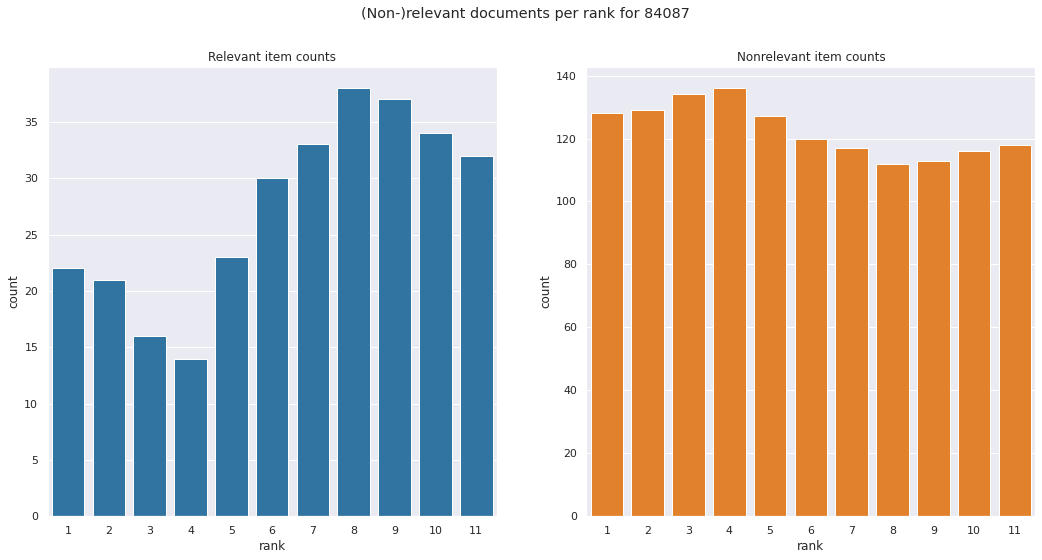

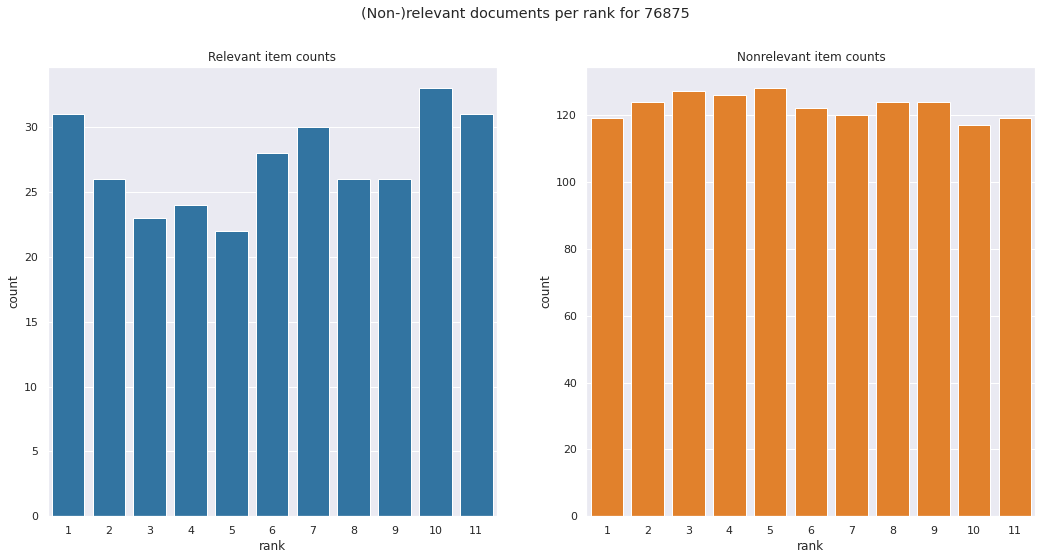

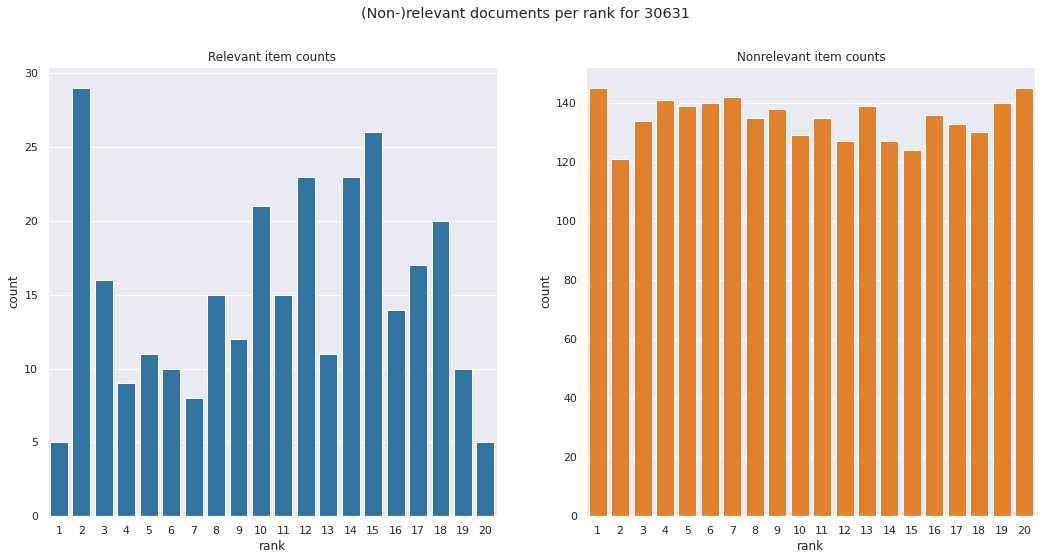

In [65]:
for q in bottomqueries.index.unique():
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)


##### Bottom queries
For the bottom queries we see that the relevant items are concentrated to either the middle or bottom ranks. **An exception is query 52501, where the relevant documents skew towards the top positions, and no relevant items are in the bottom positions at all.**

#### Doc occurrence per rank
We plot how often each document occurs at each rank. We plot all of the top positions and the bottom 5 positions.

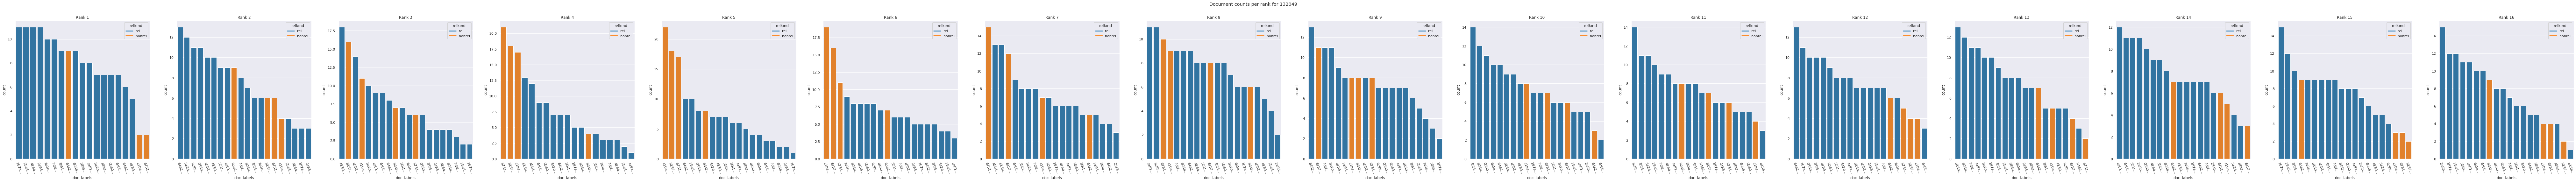

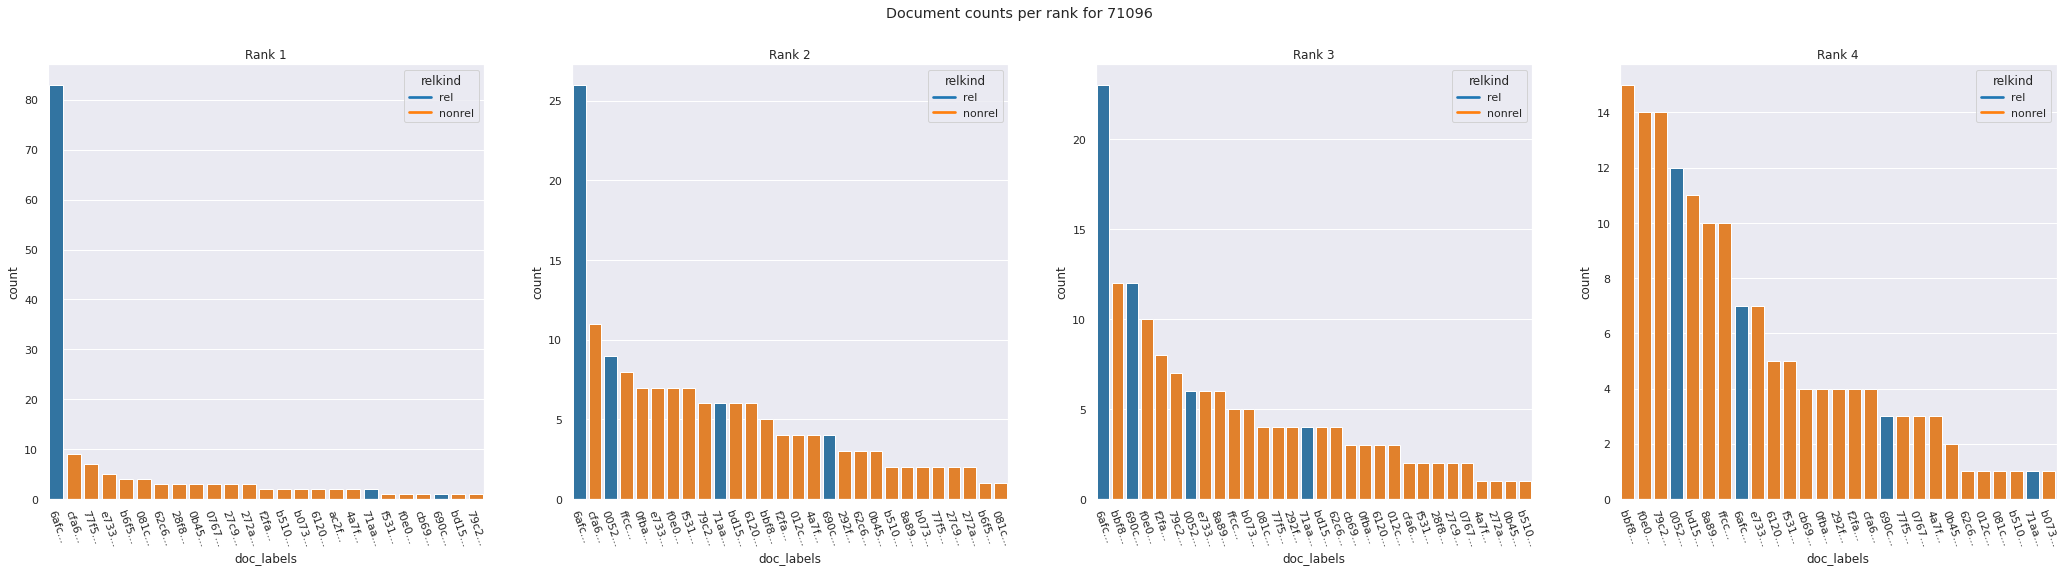

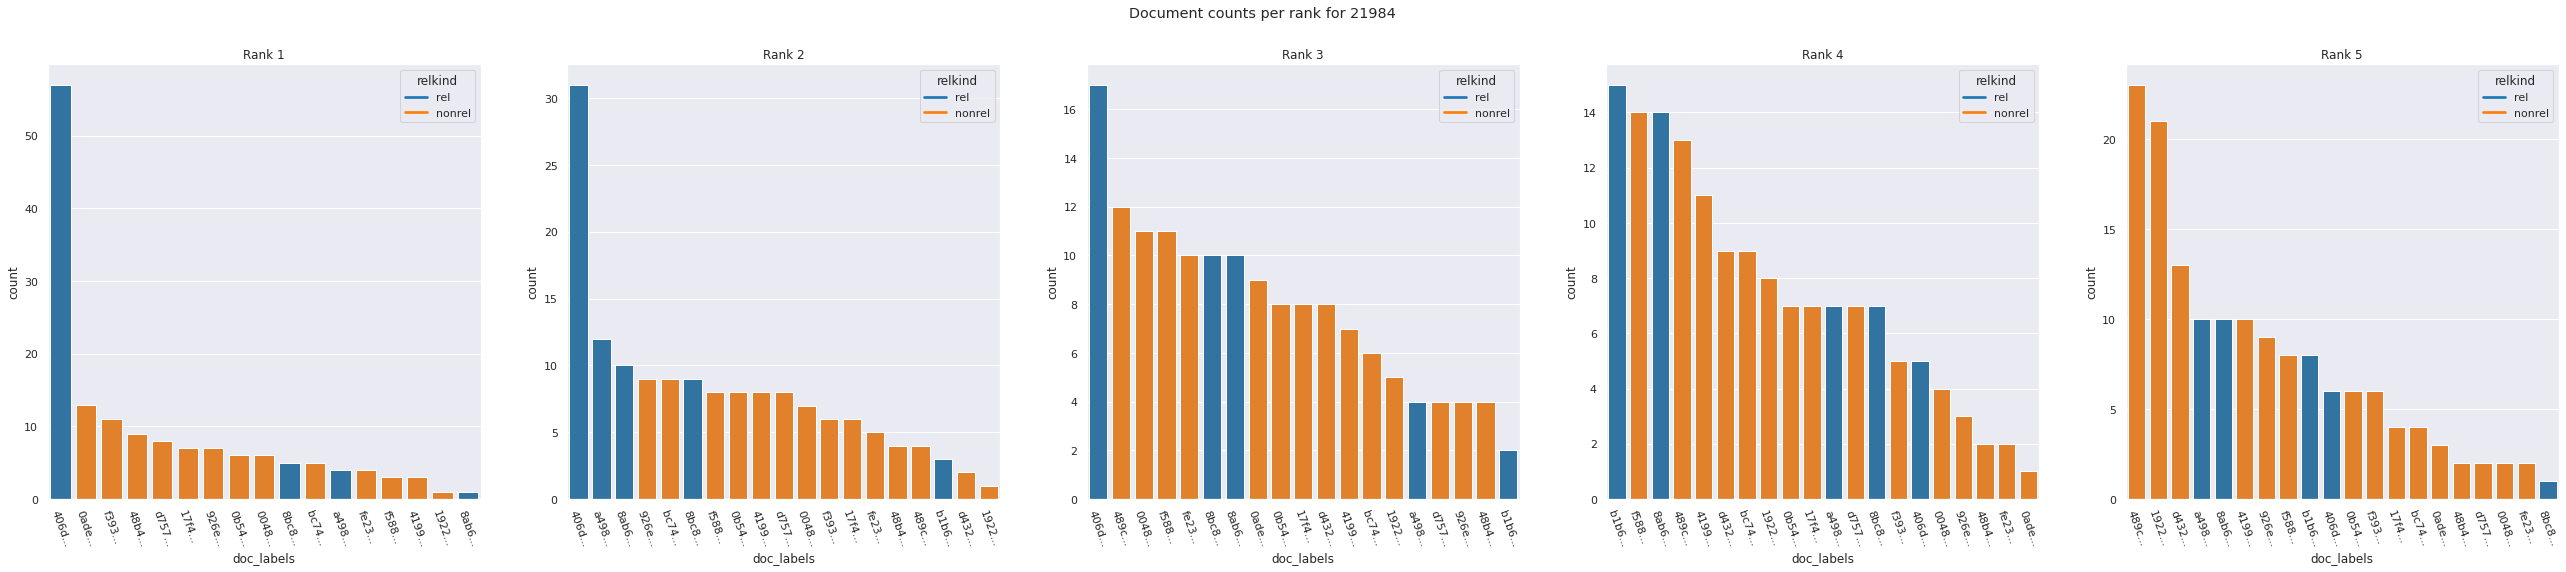

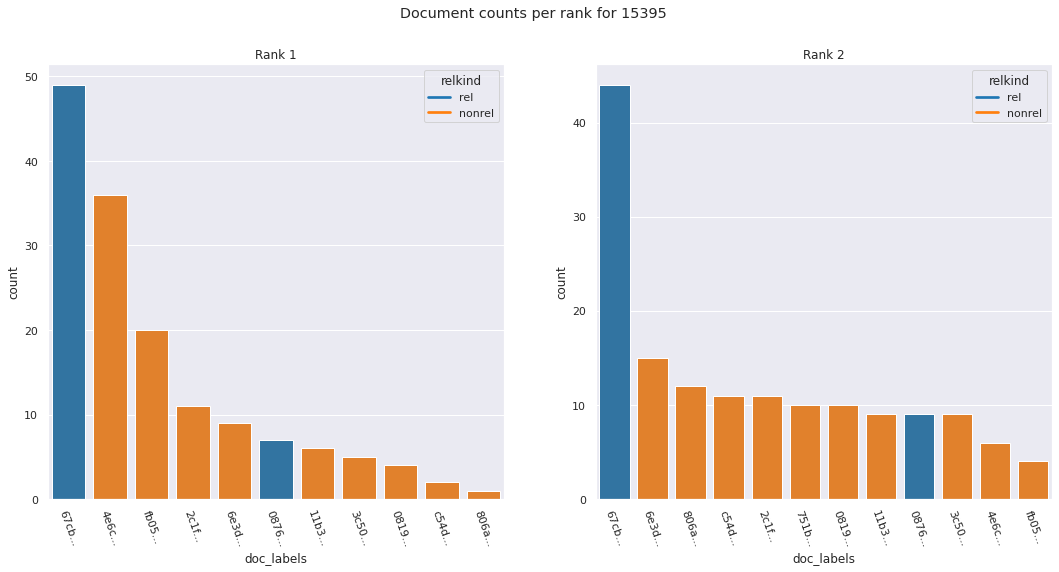

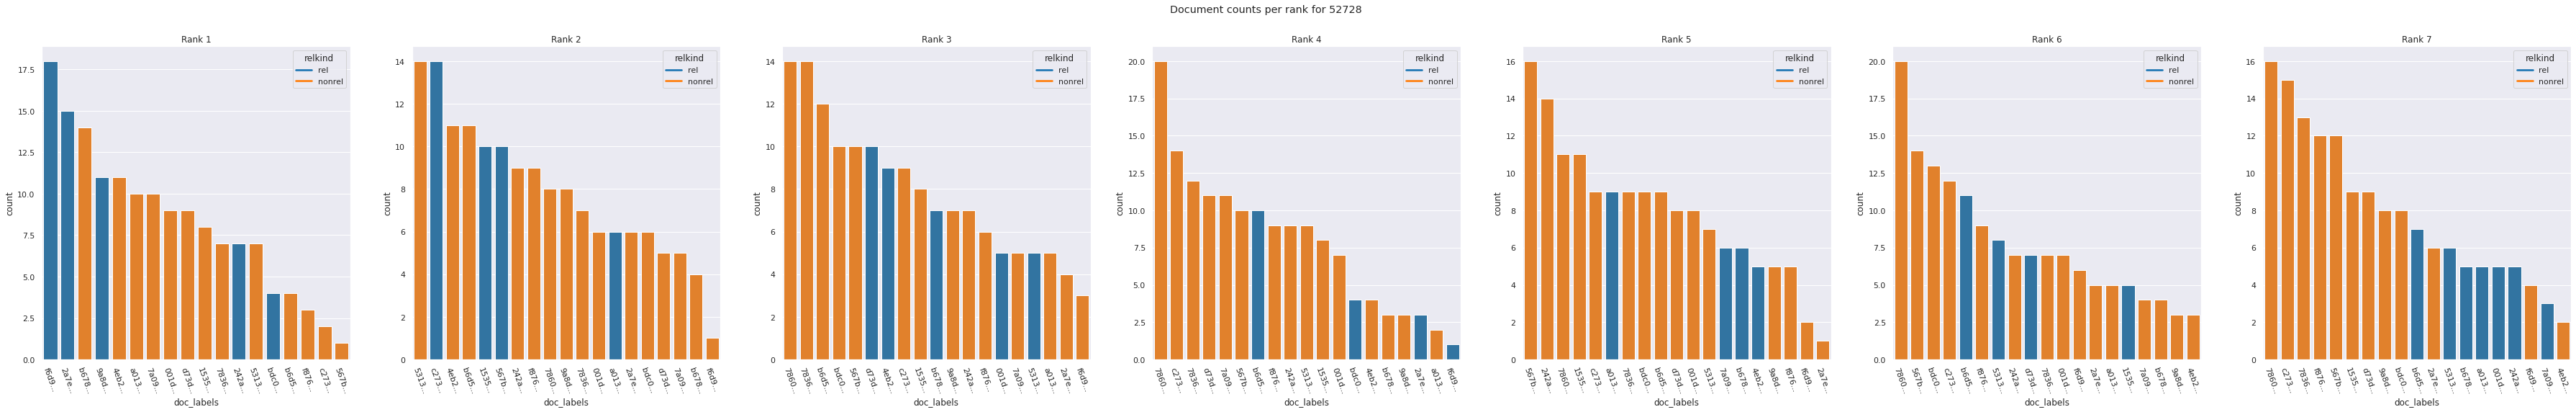

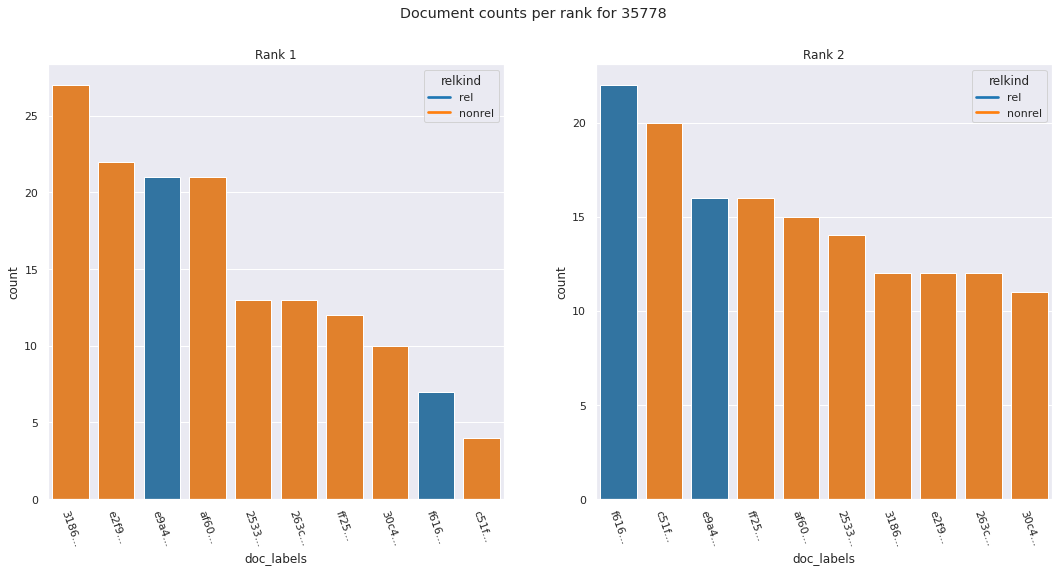

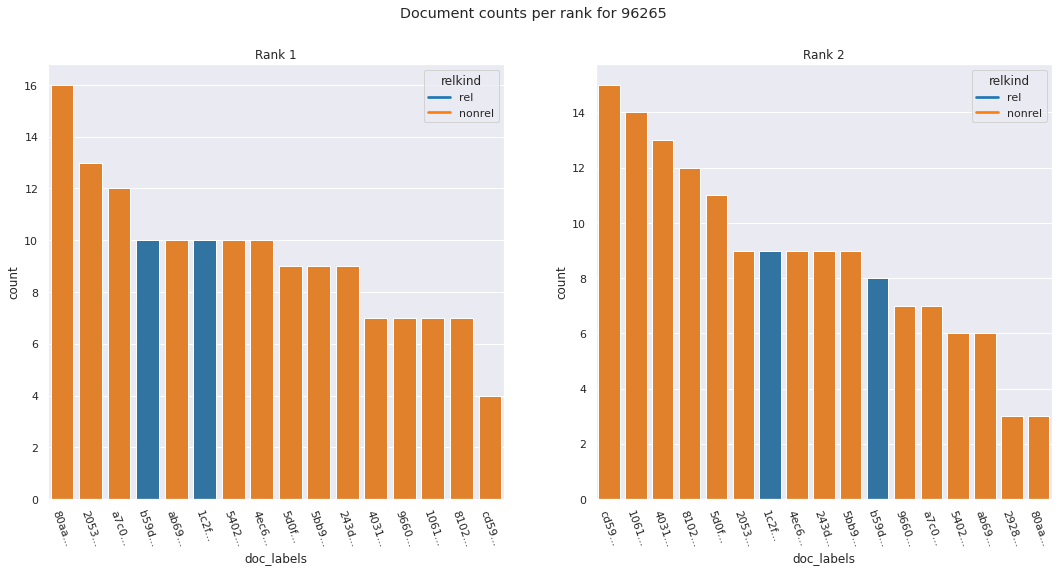

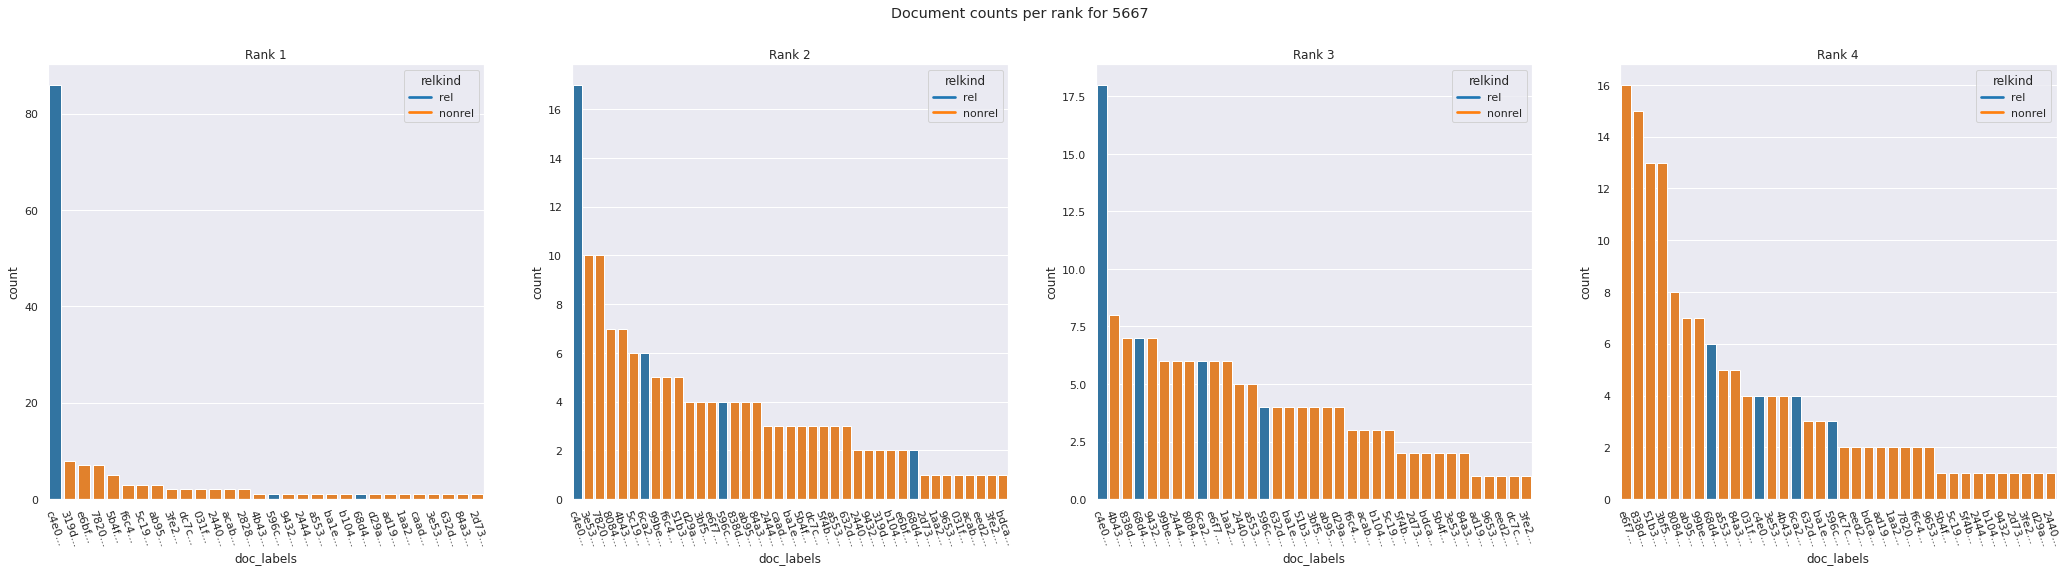

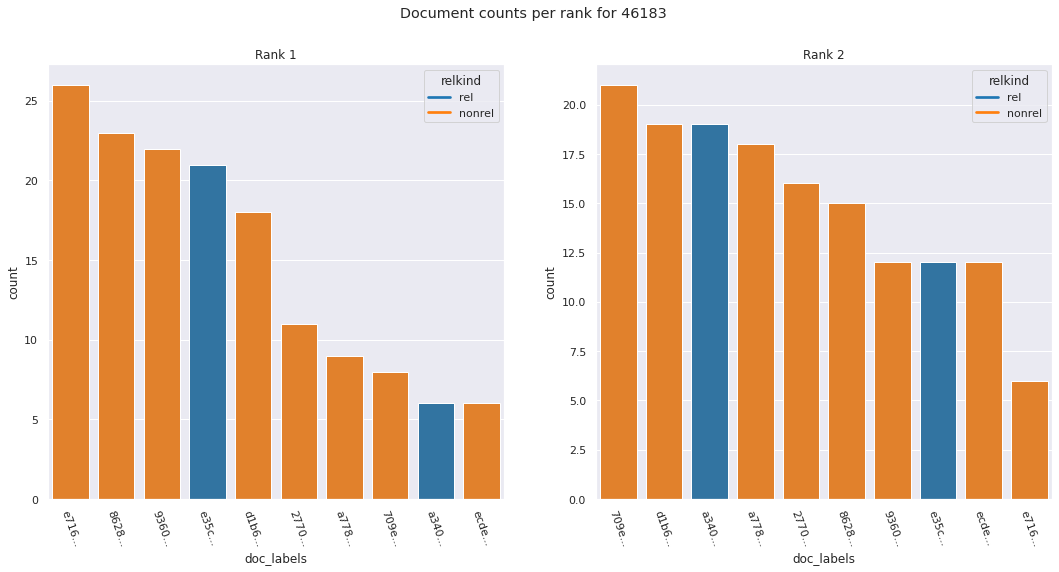

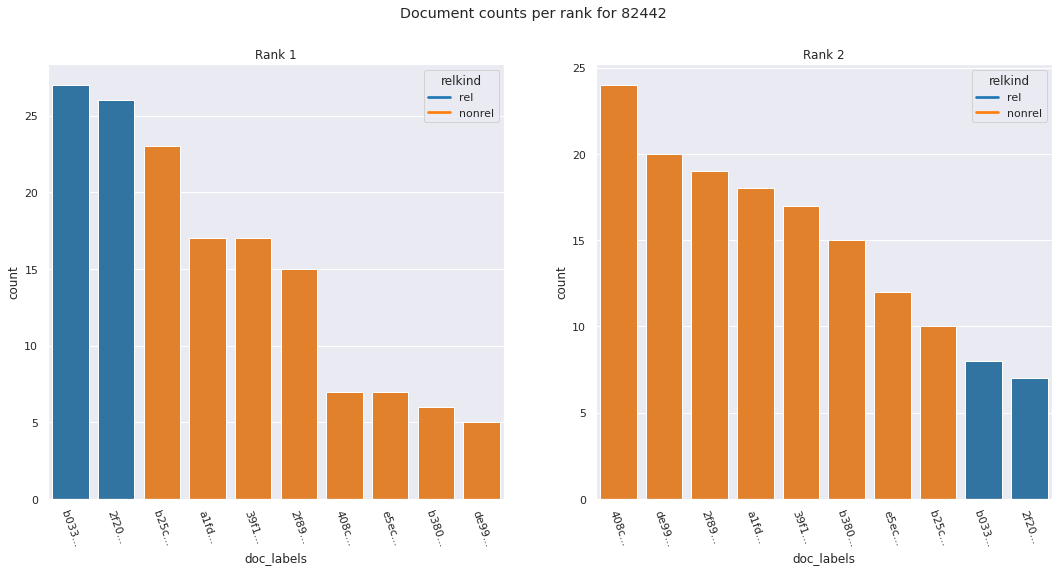

In [66]:
for q in topqueries.index.unique():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=rel)


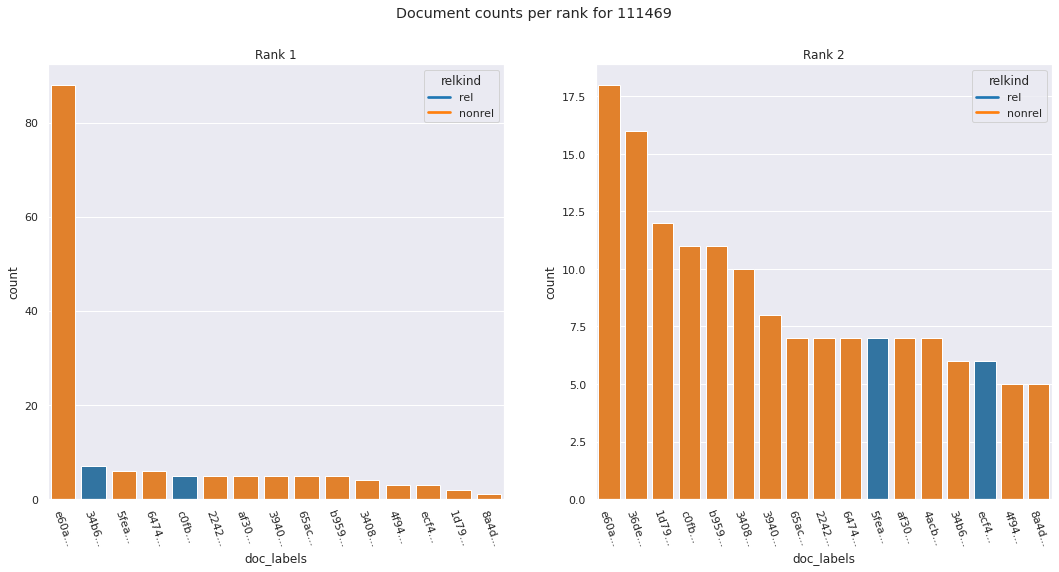

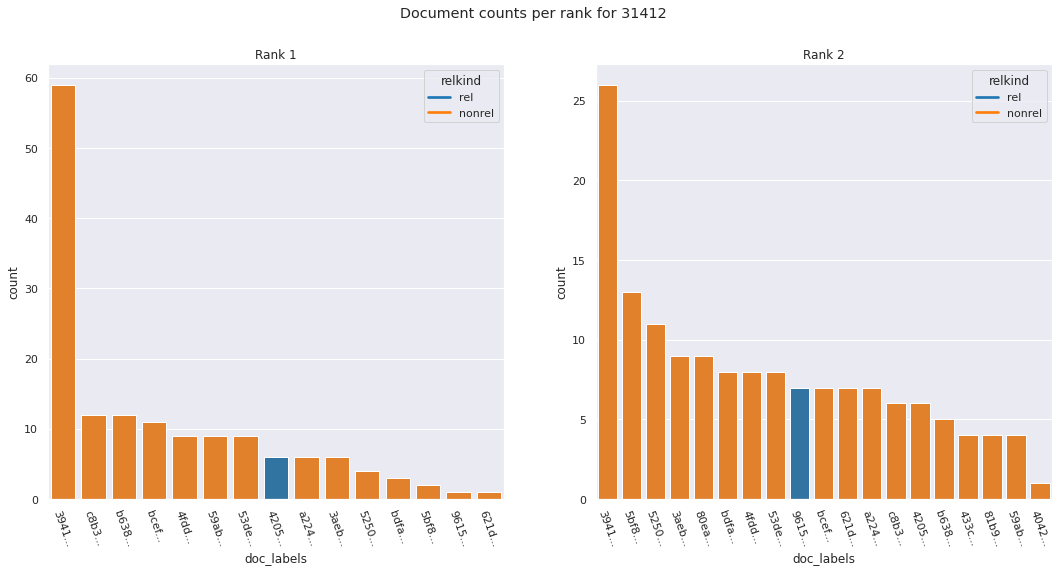

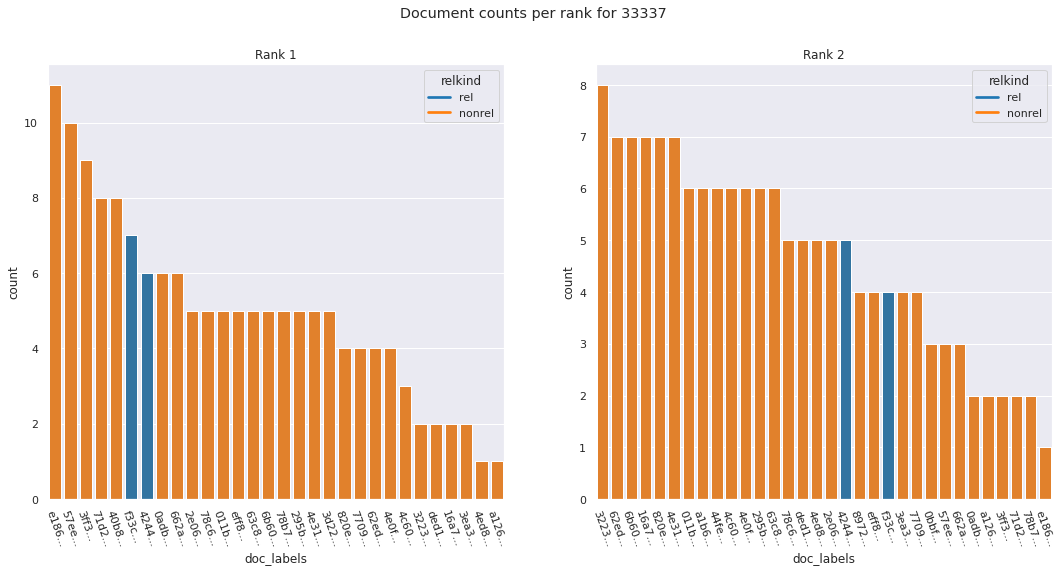

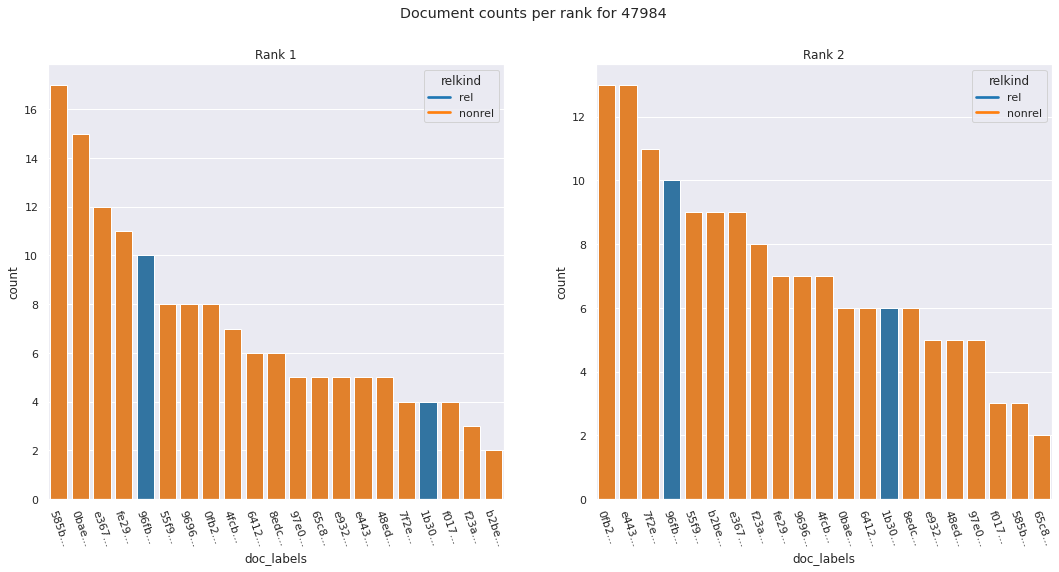

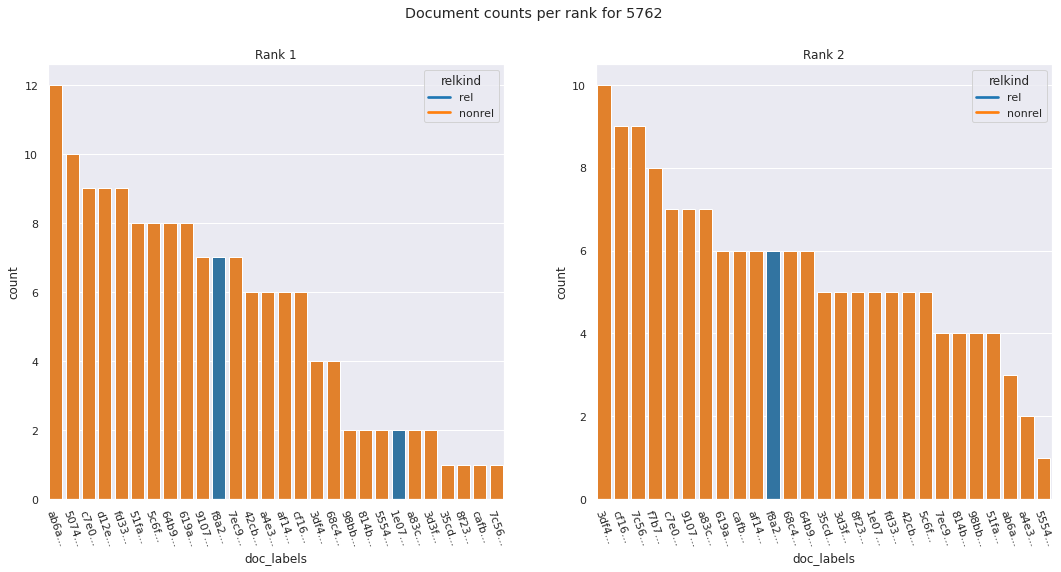

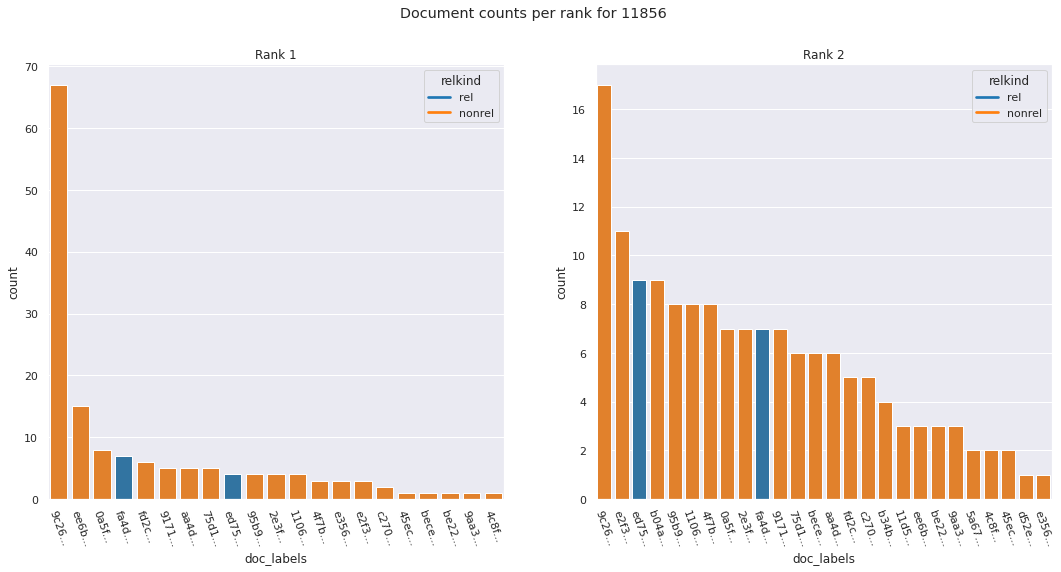

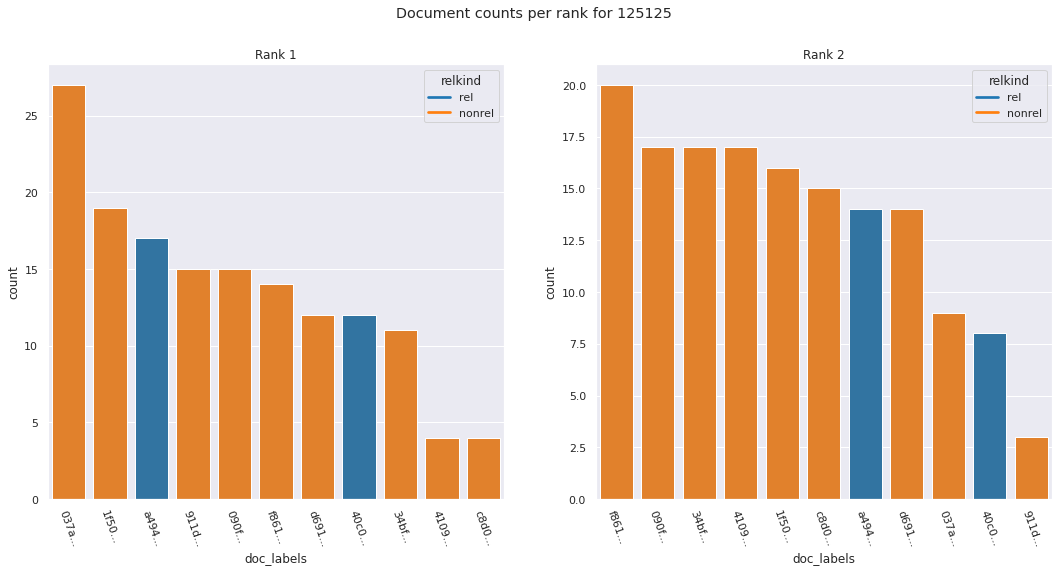

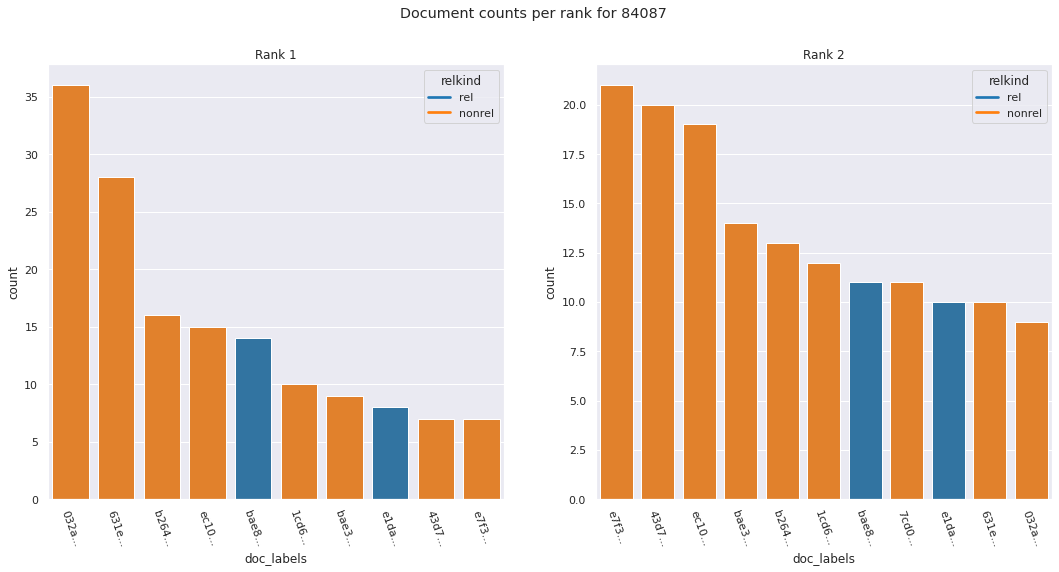

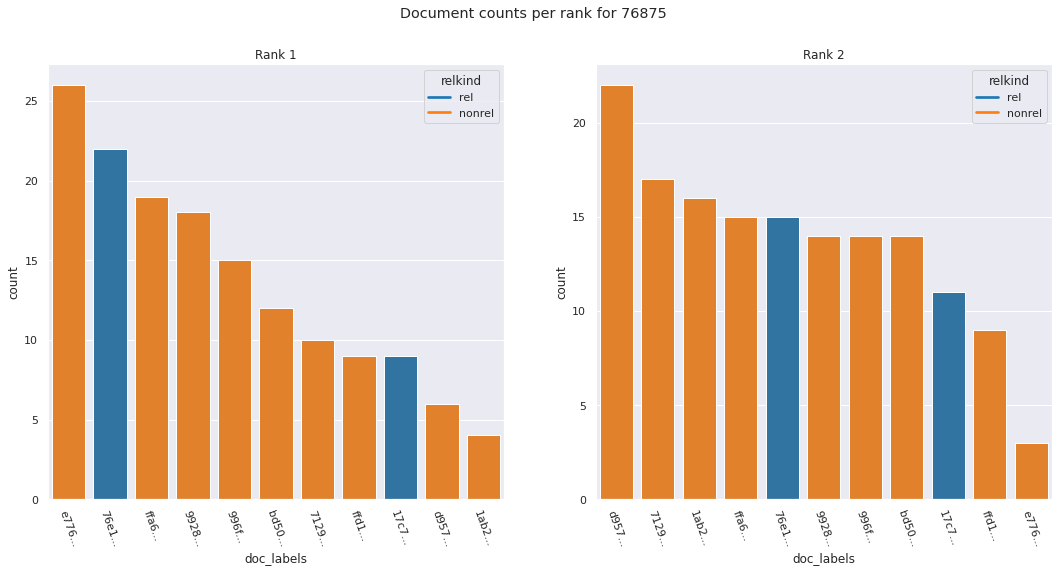

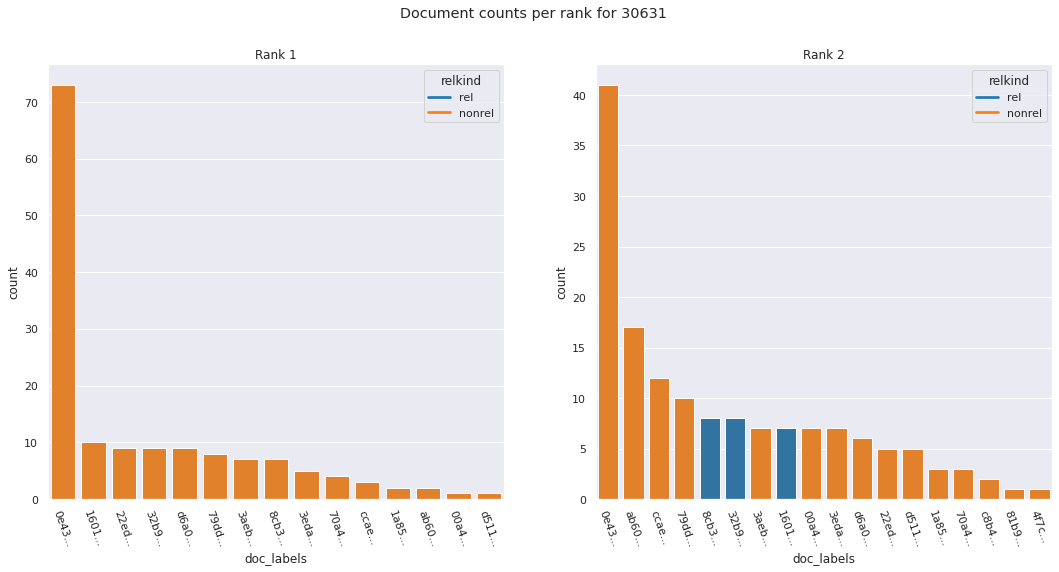

In [67]:
for q in bottomqueries.index.unique():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=rel)
    

##### Top positions

Remarks:
- The top queries have a larger number of relevant items than the bottom queries on average
  - **Hypothesis**: if a query has a larger *fraction* of relevant items it performs better, because the chance that a a relevant item lands in a top position is larger.
  
- The top queries either have a reasonably gently sloping distribution, or a great spike of a relevant document (71096)

- For 2/3 of the top queries (71906, 21984, 52738, 5667), not all top documents appear in the top positions
    - **Hypothesis**: The items that do *not* appear in the top positions have low estimated relevance


- Many of the bottom queries have a large spike of an irrelevant document in a top position.
    - Aside from the spike the distribution generally diminishes gently.


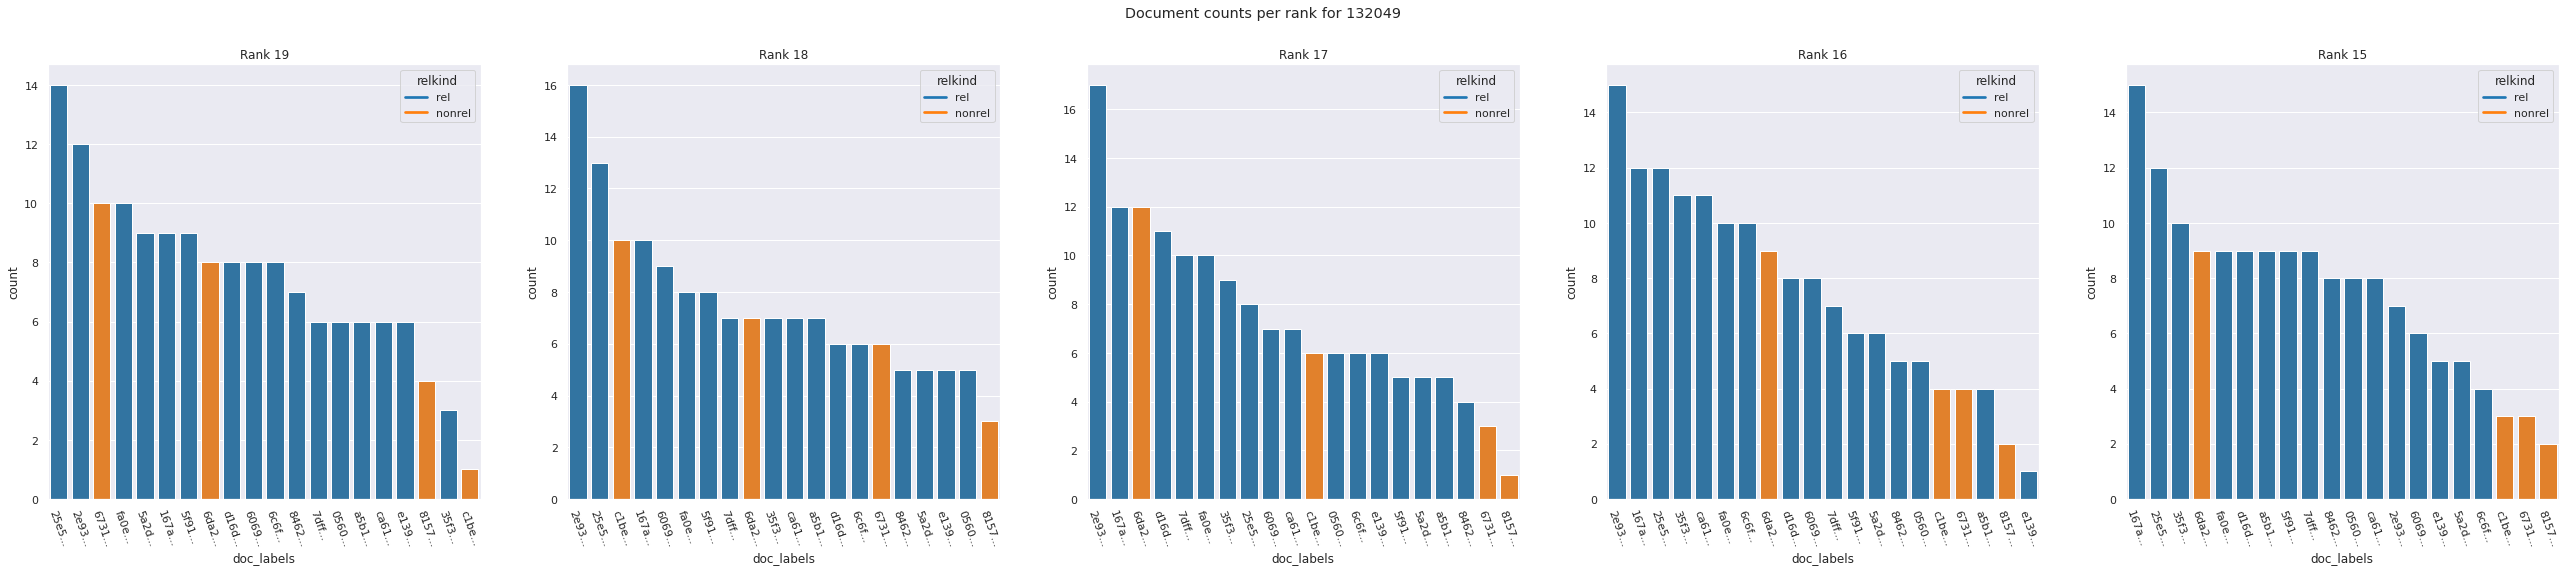

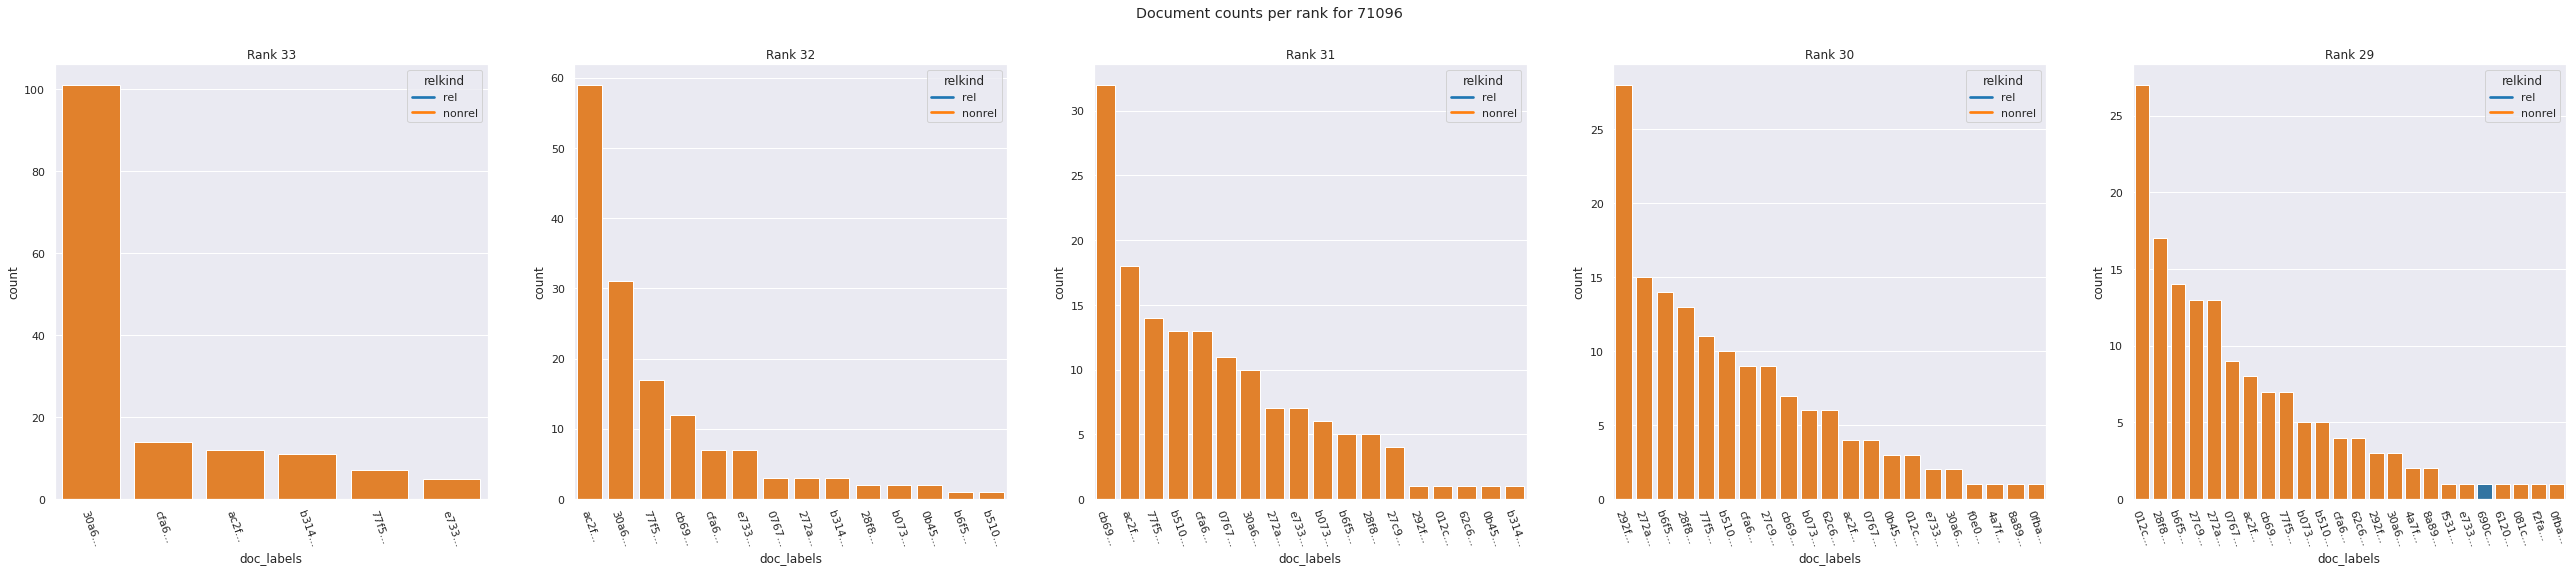

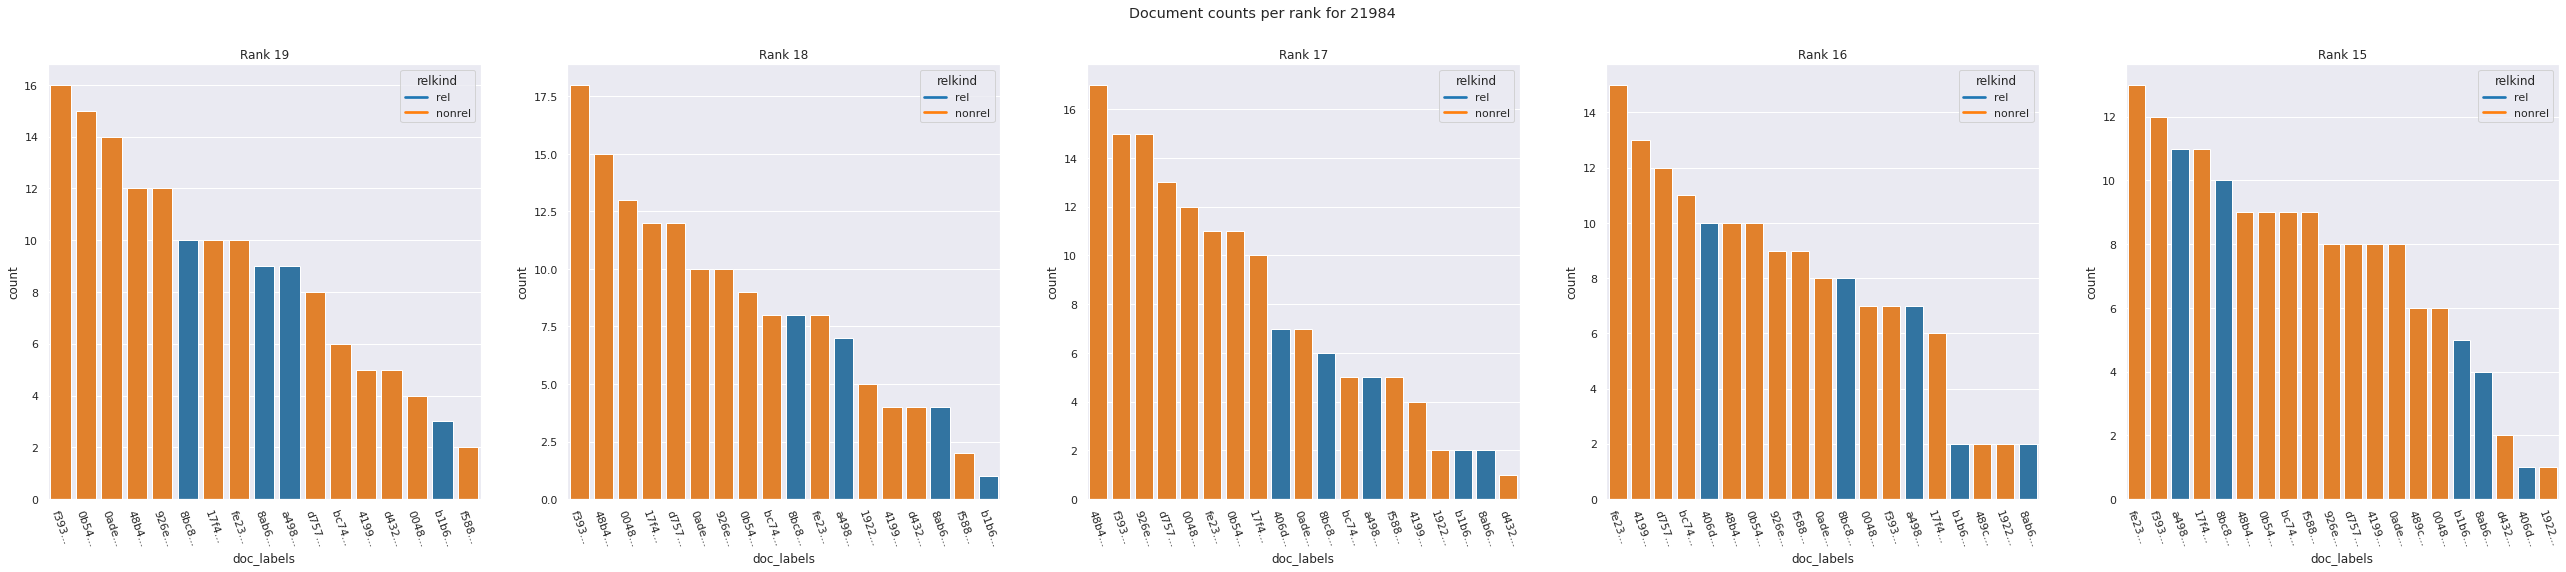

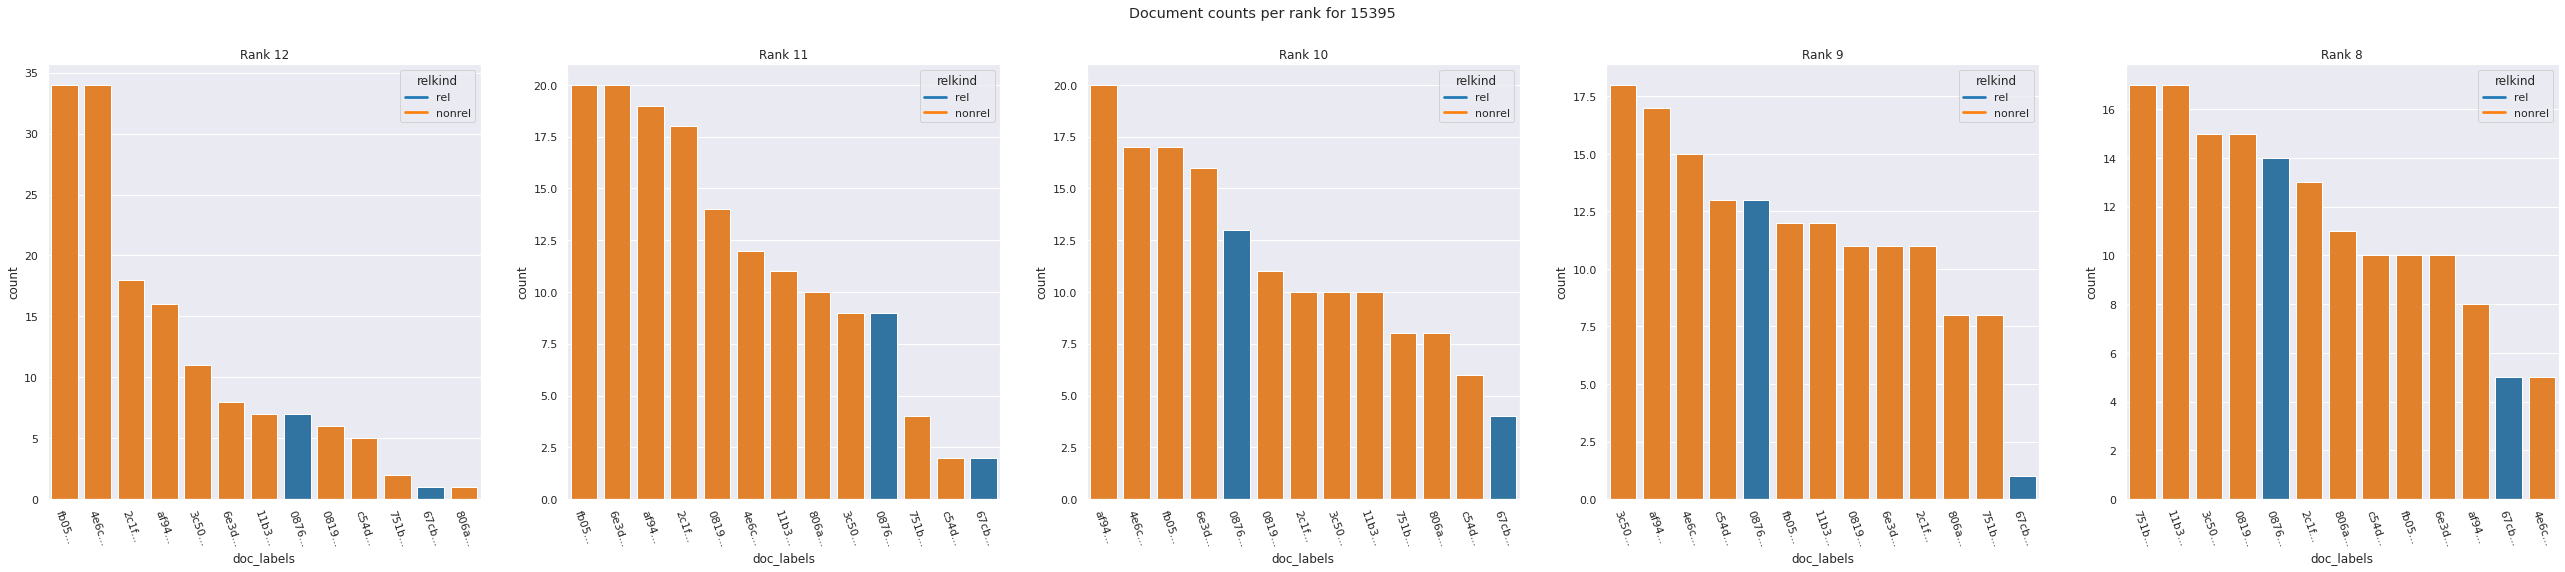

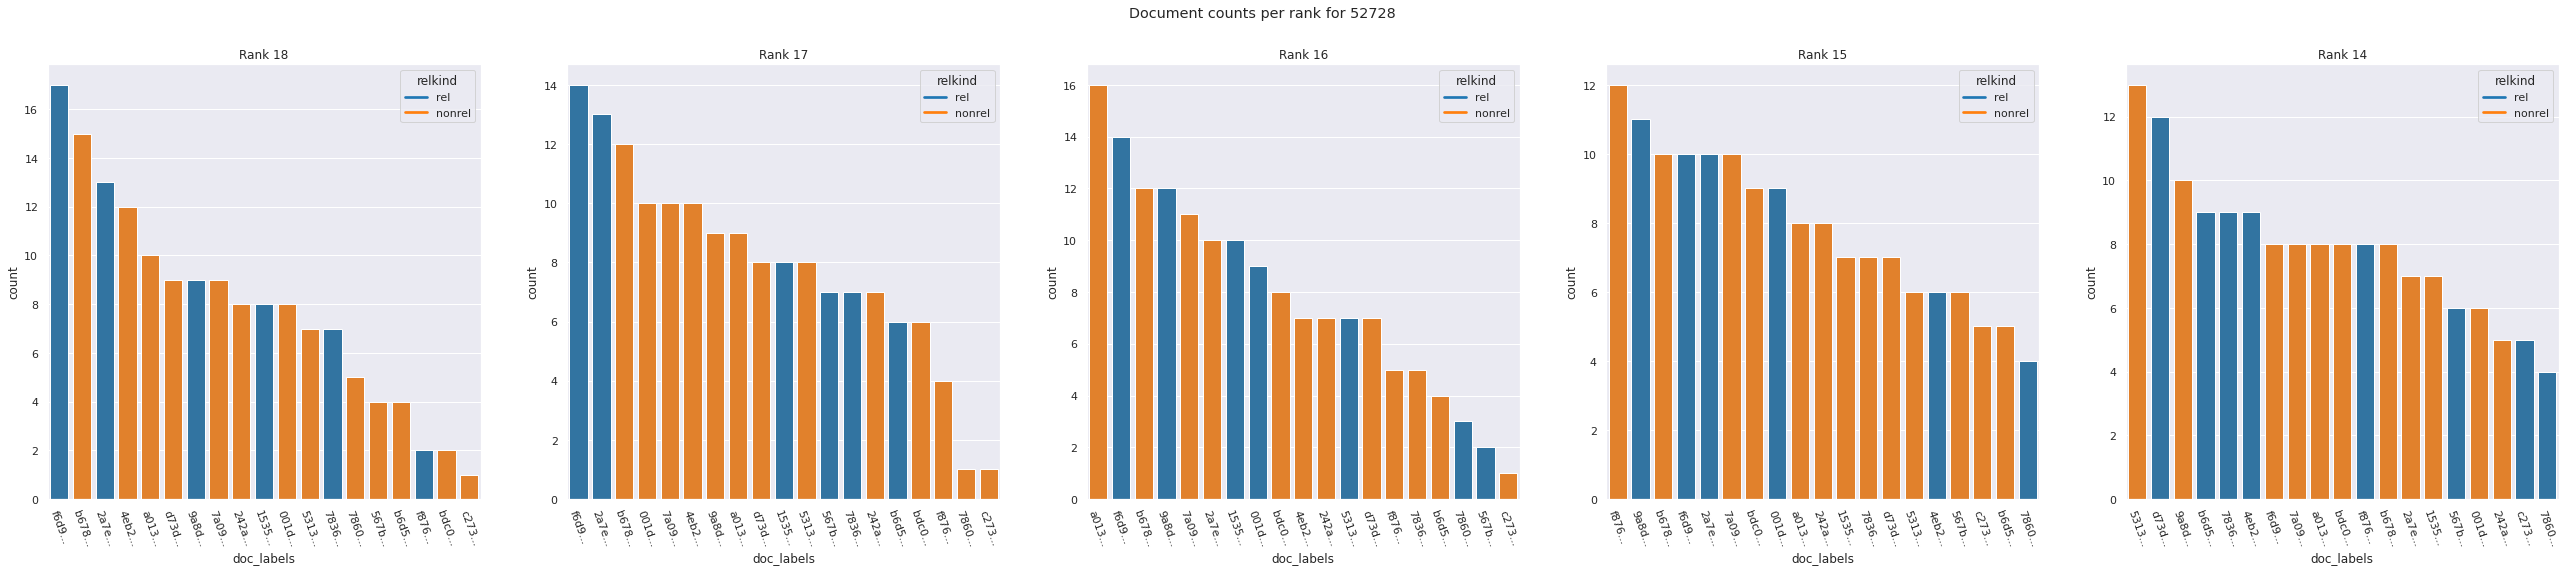

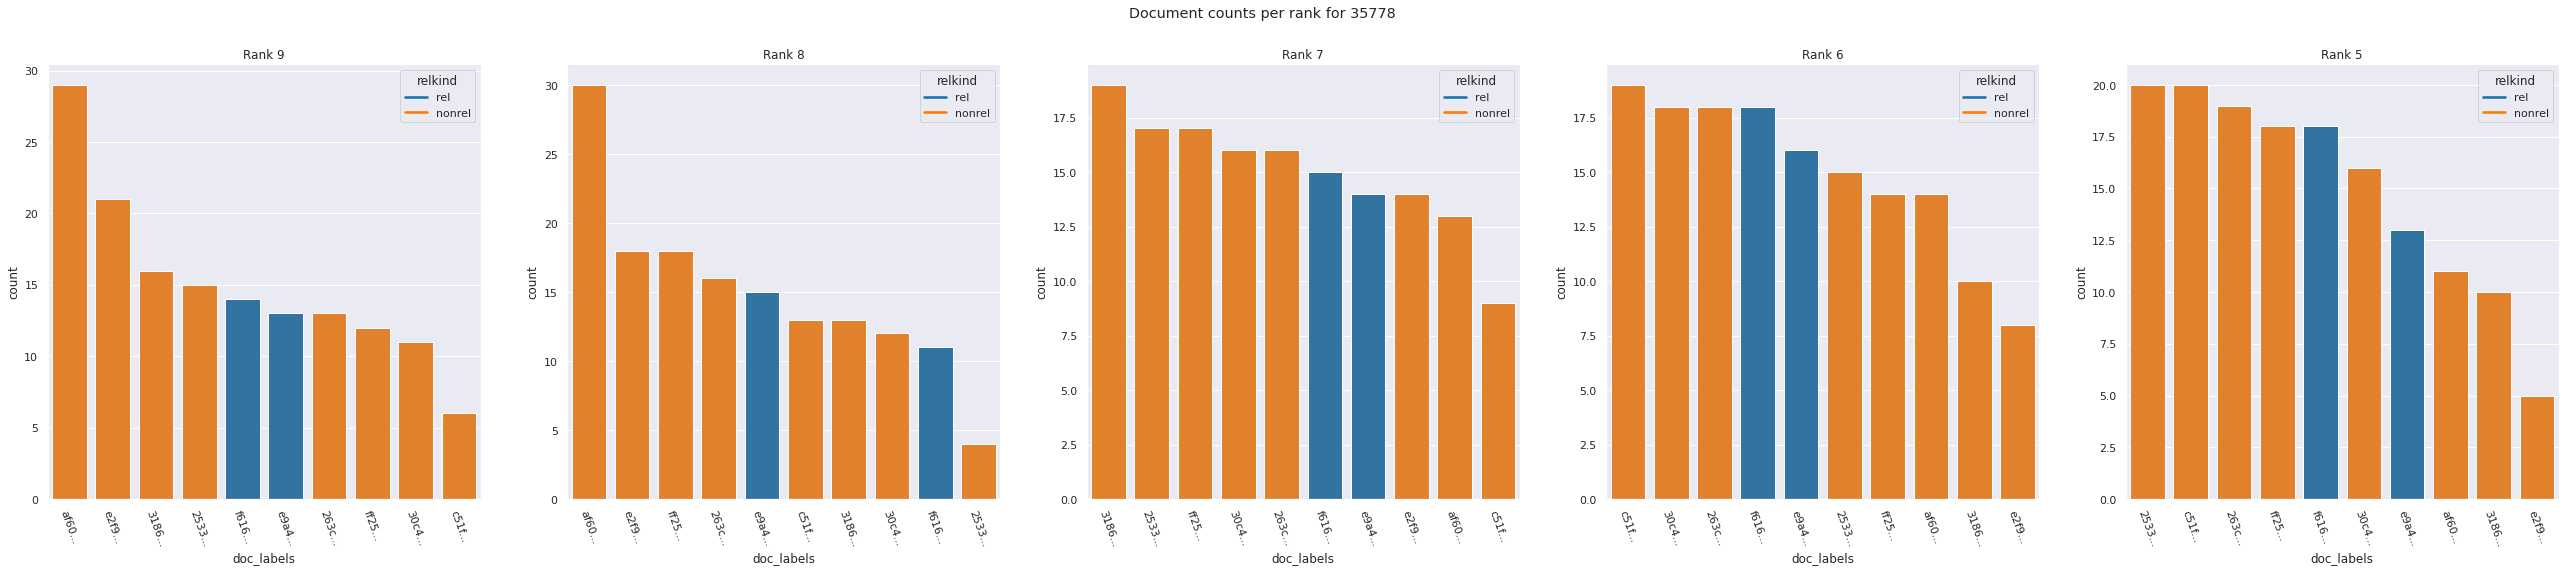

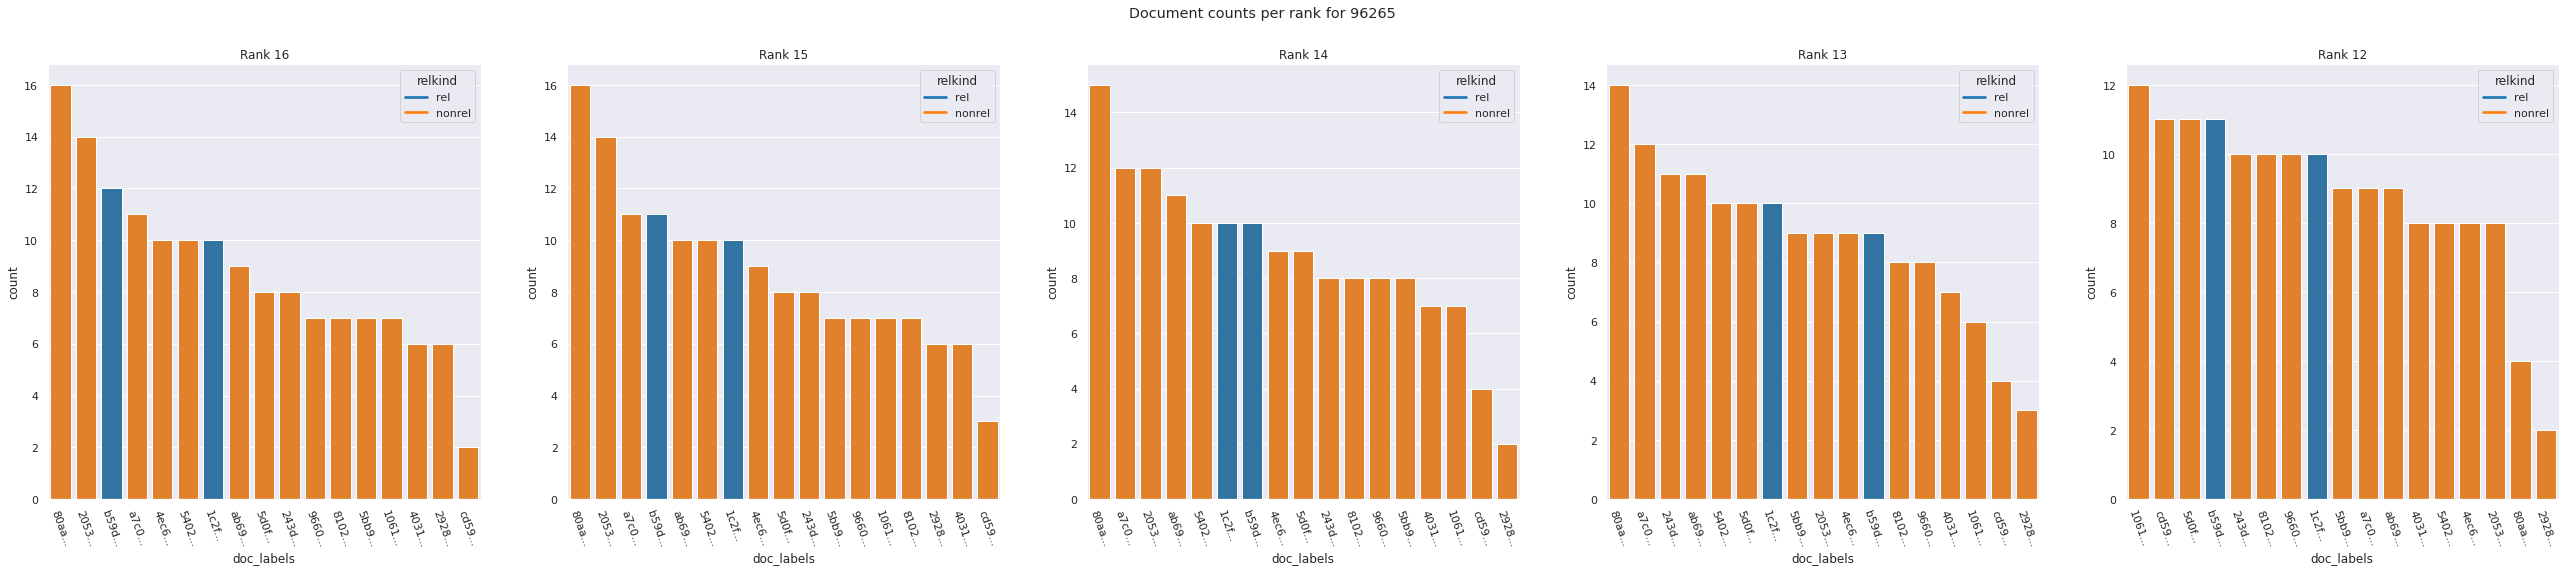

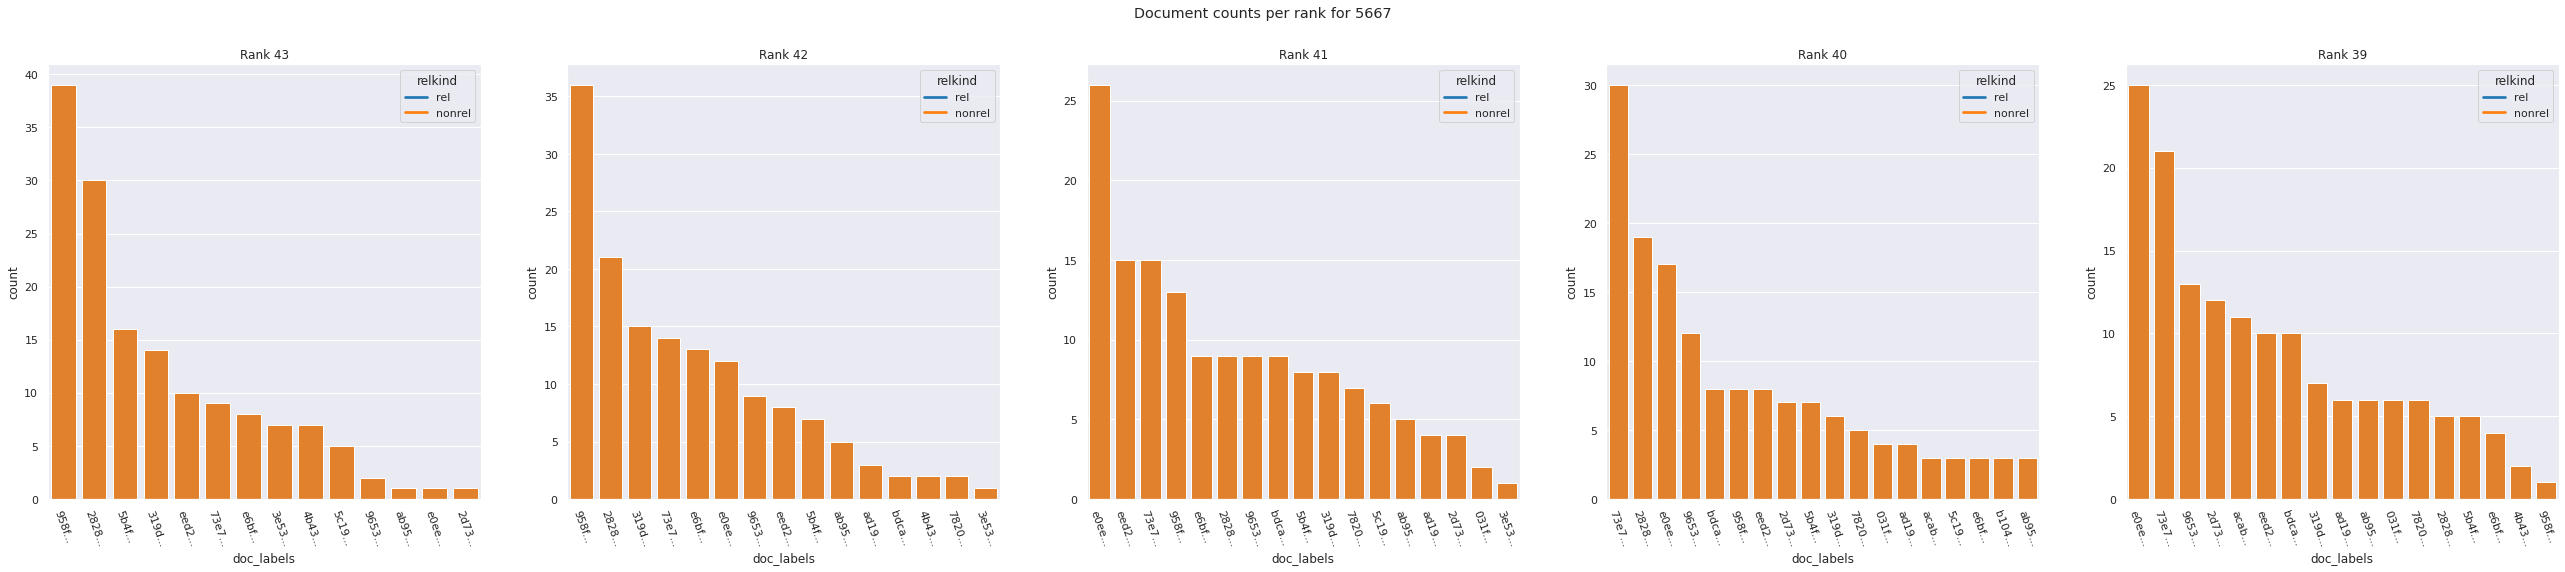

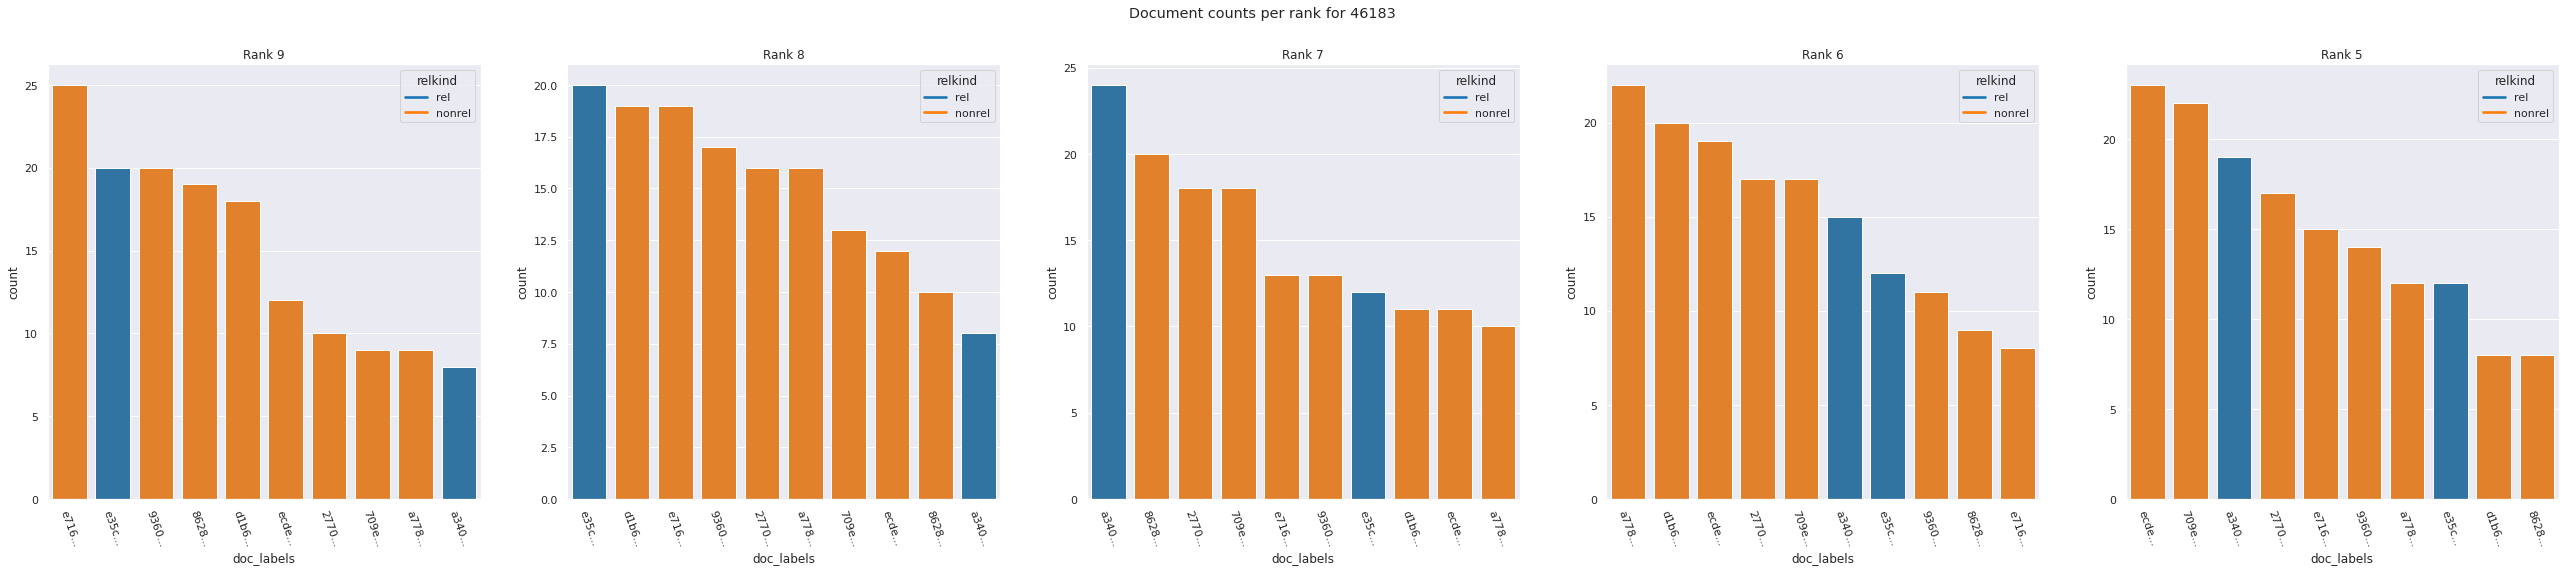

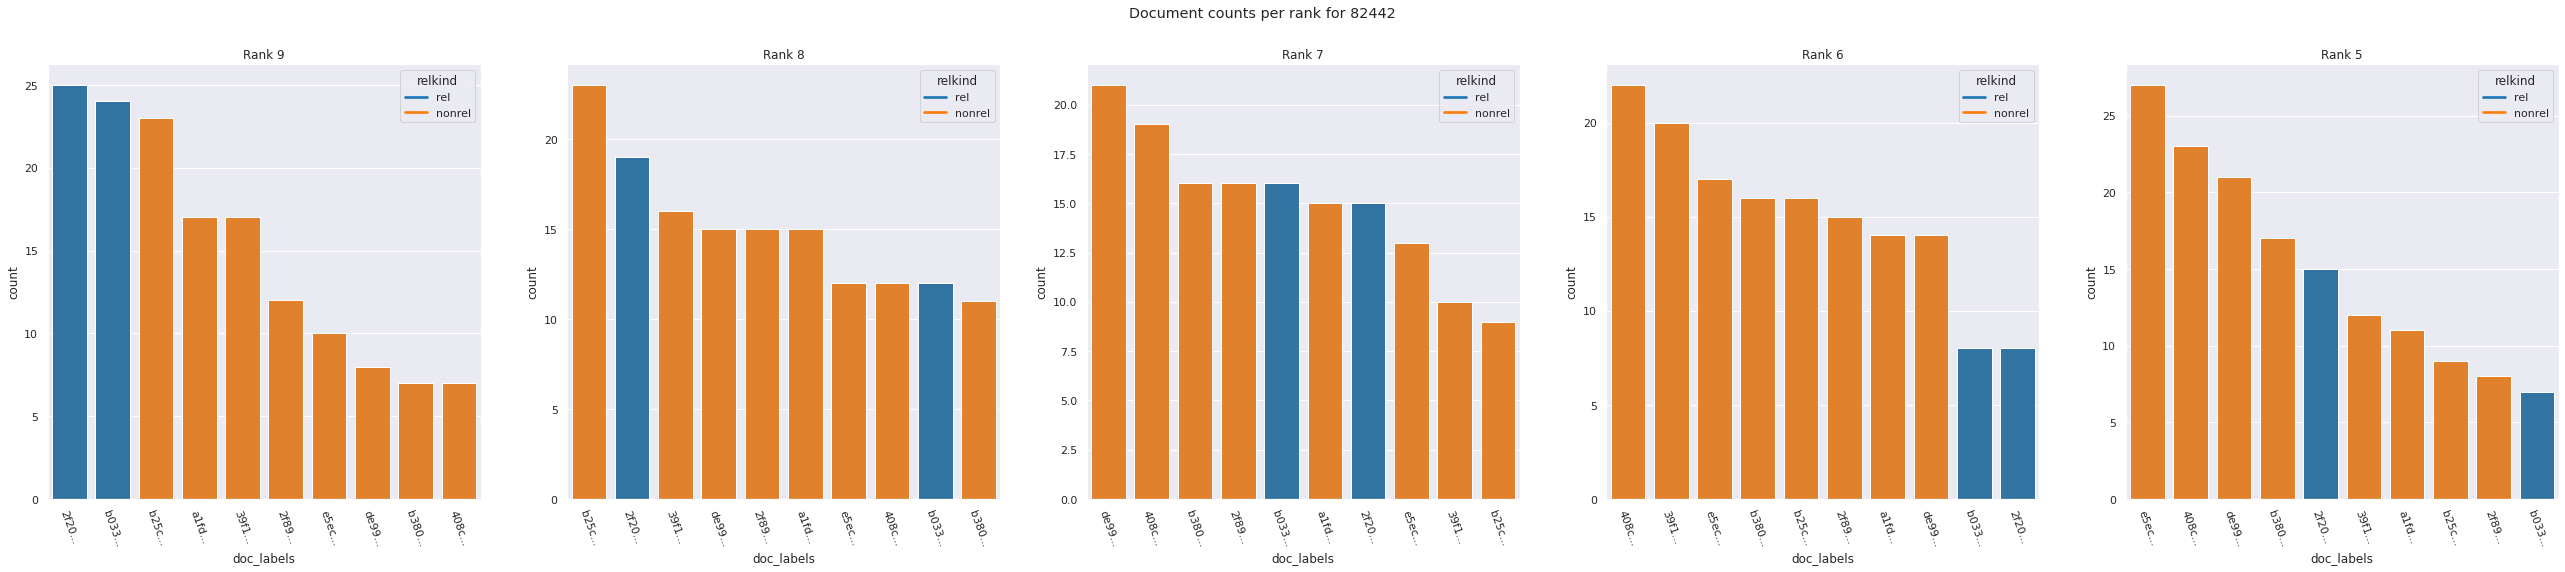

In [81]:
for q in topqueries.index.unique():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=5,rev=True)

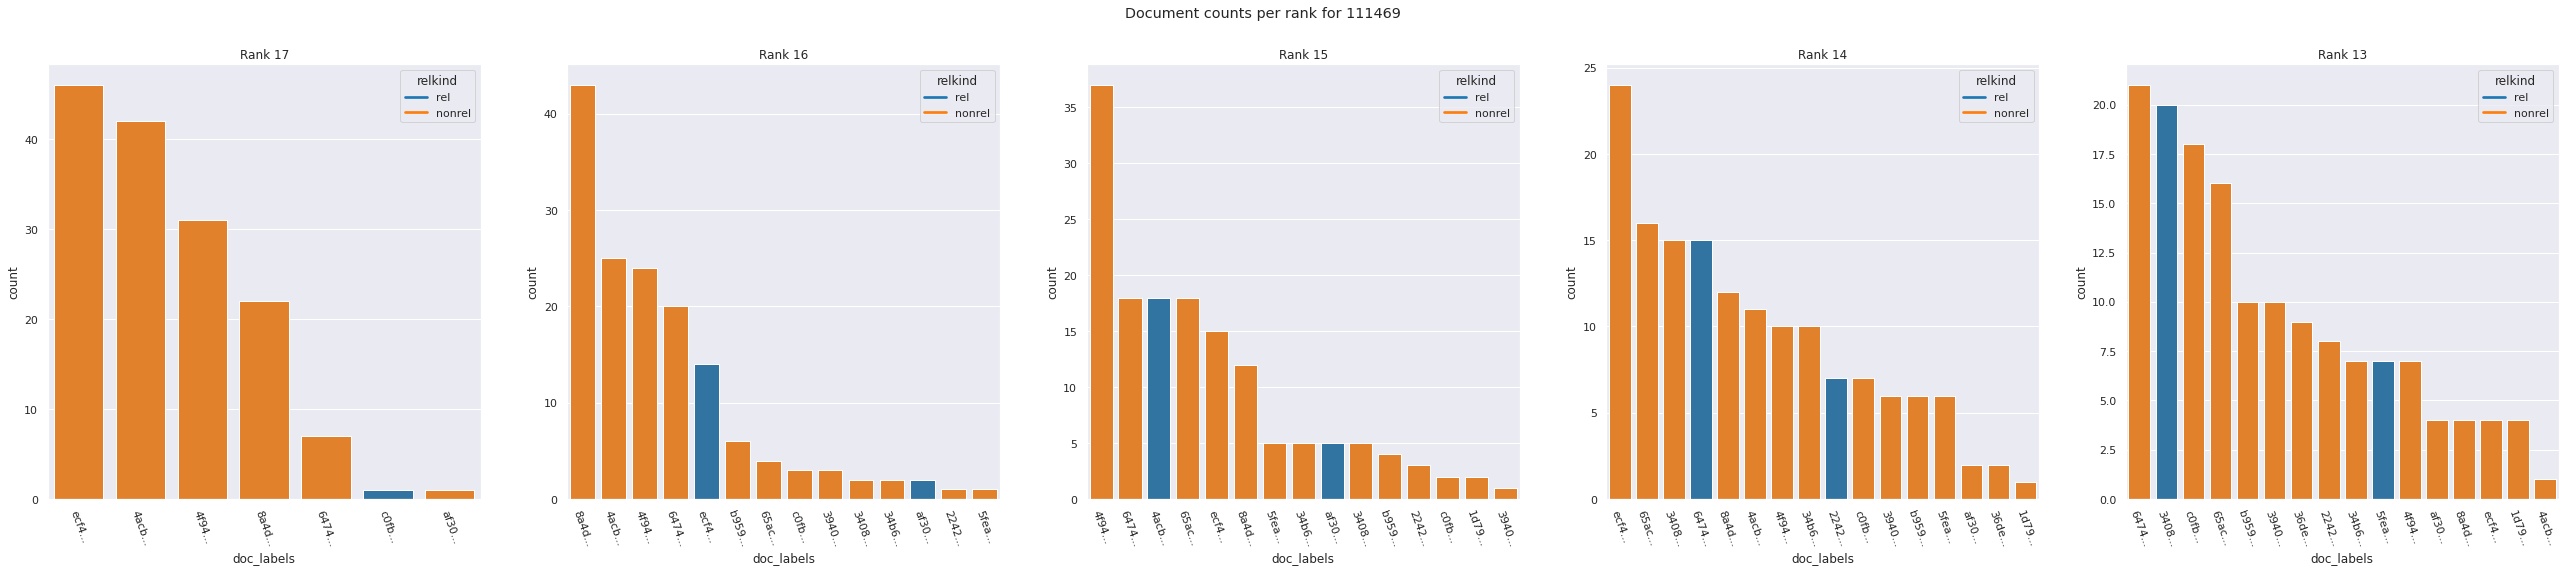

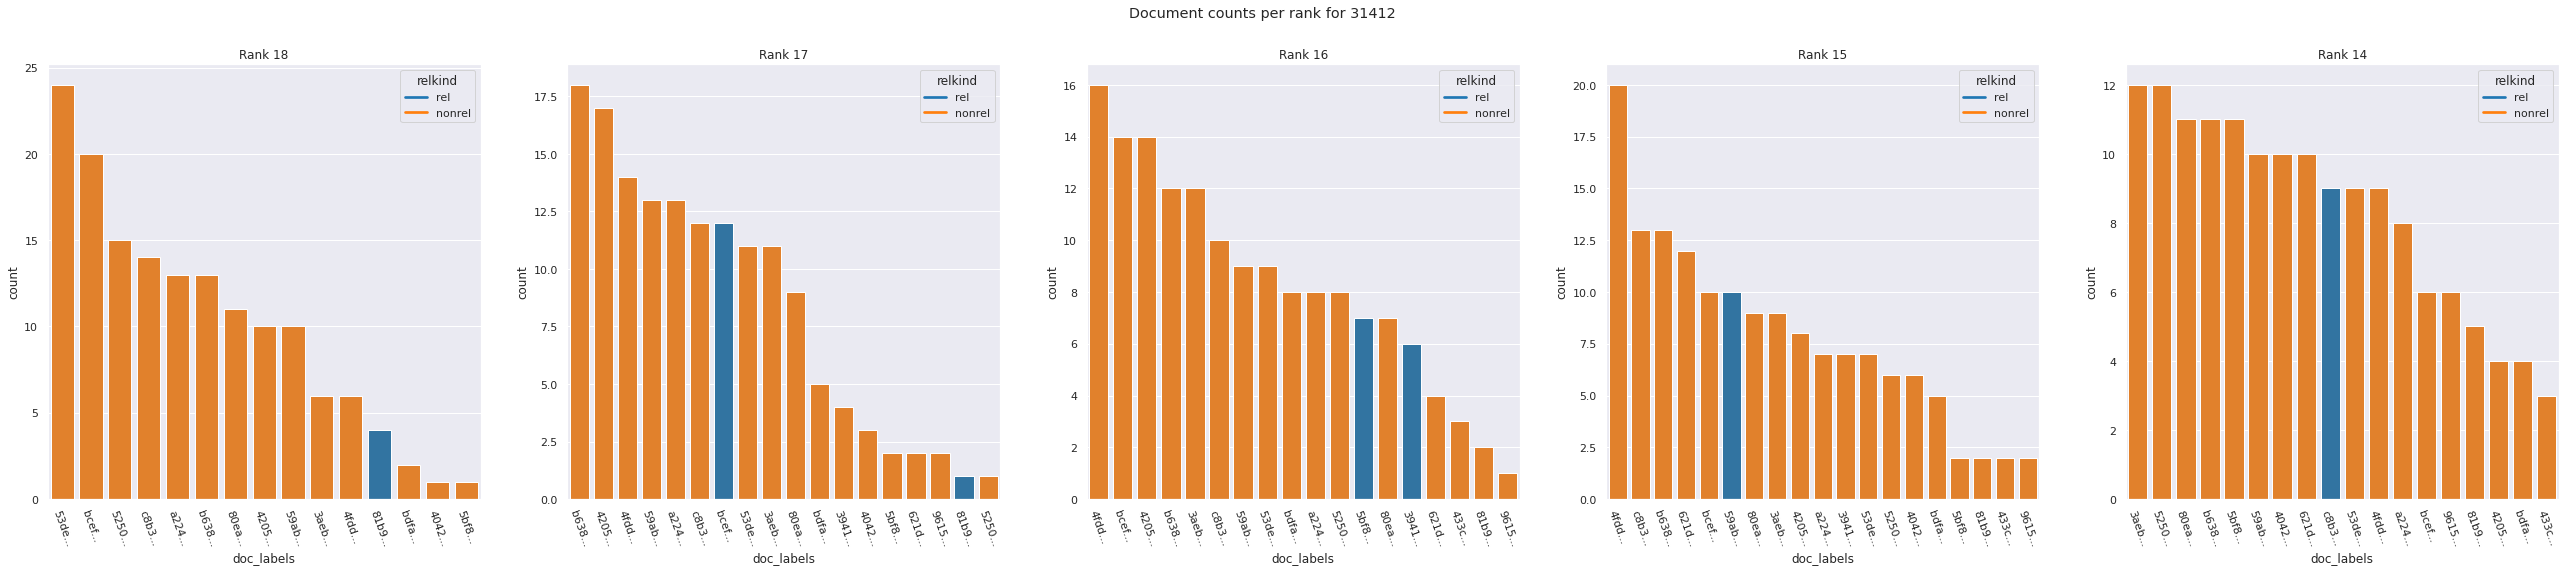

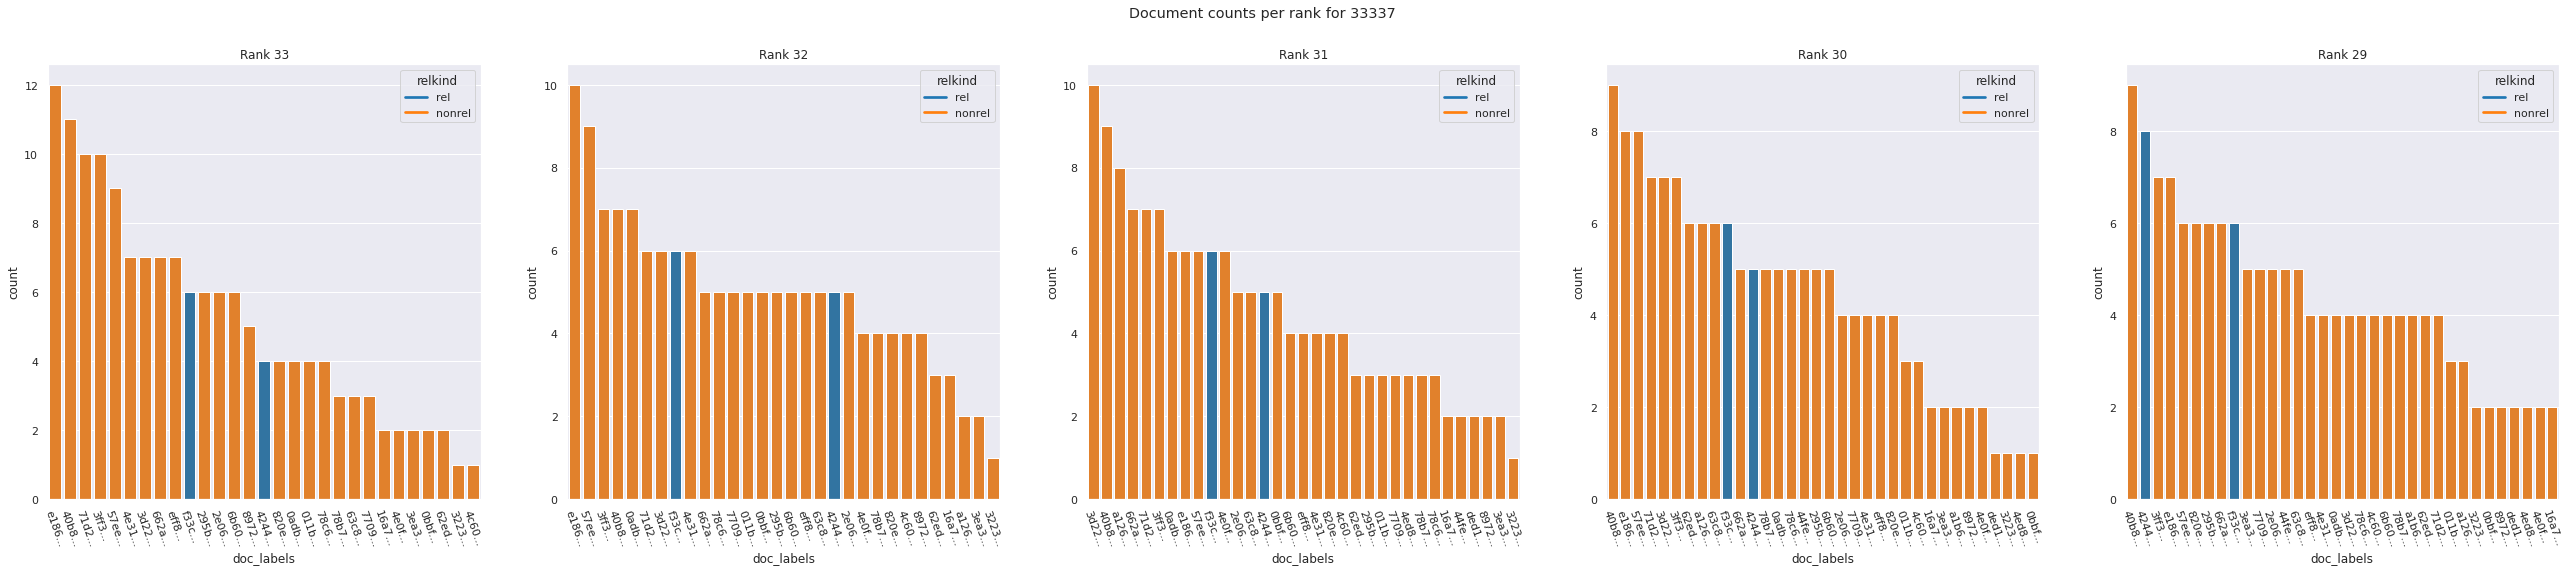

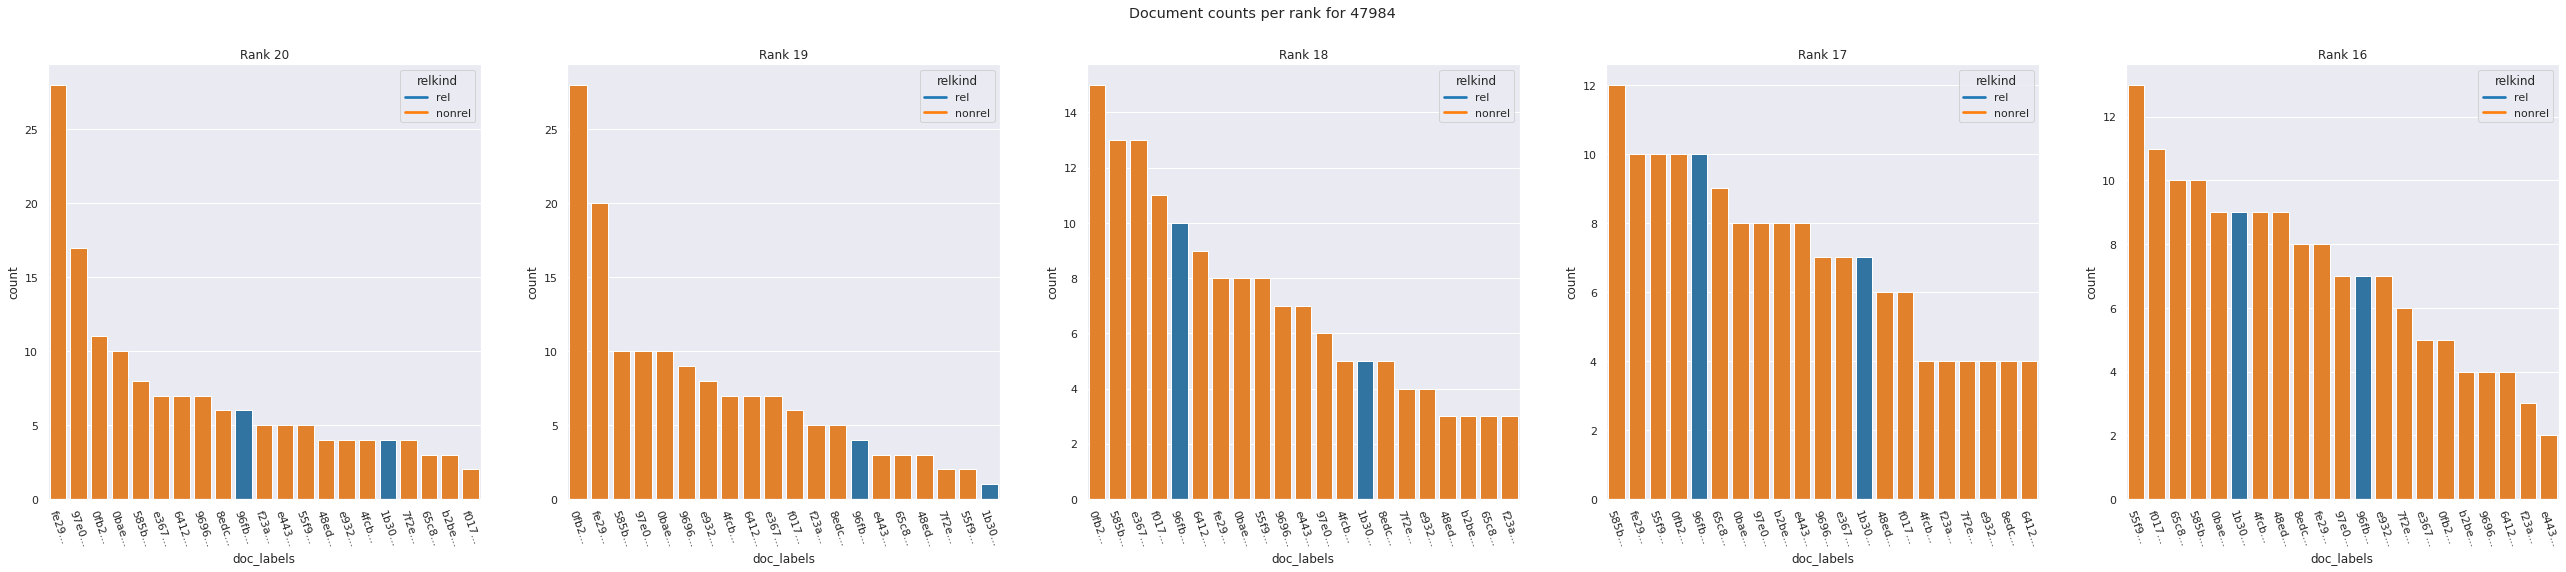

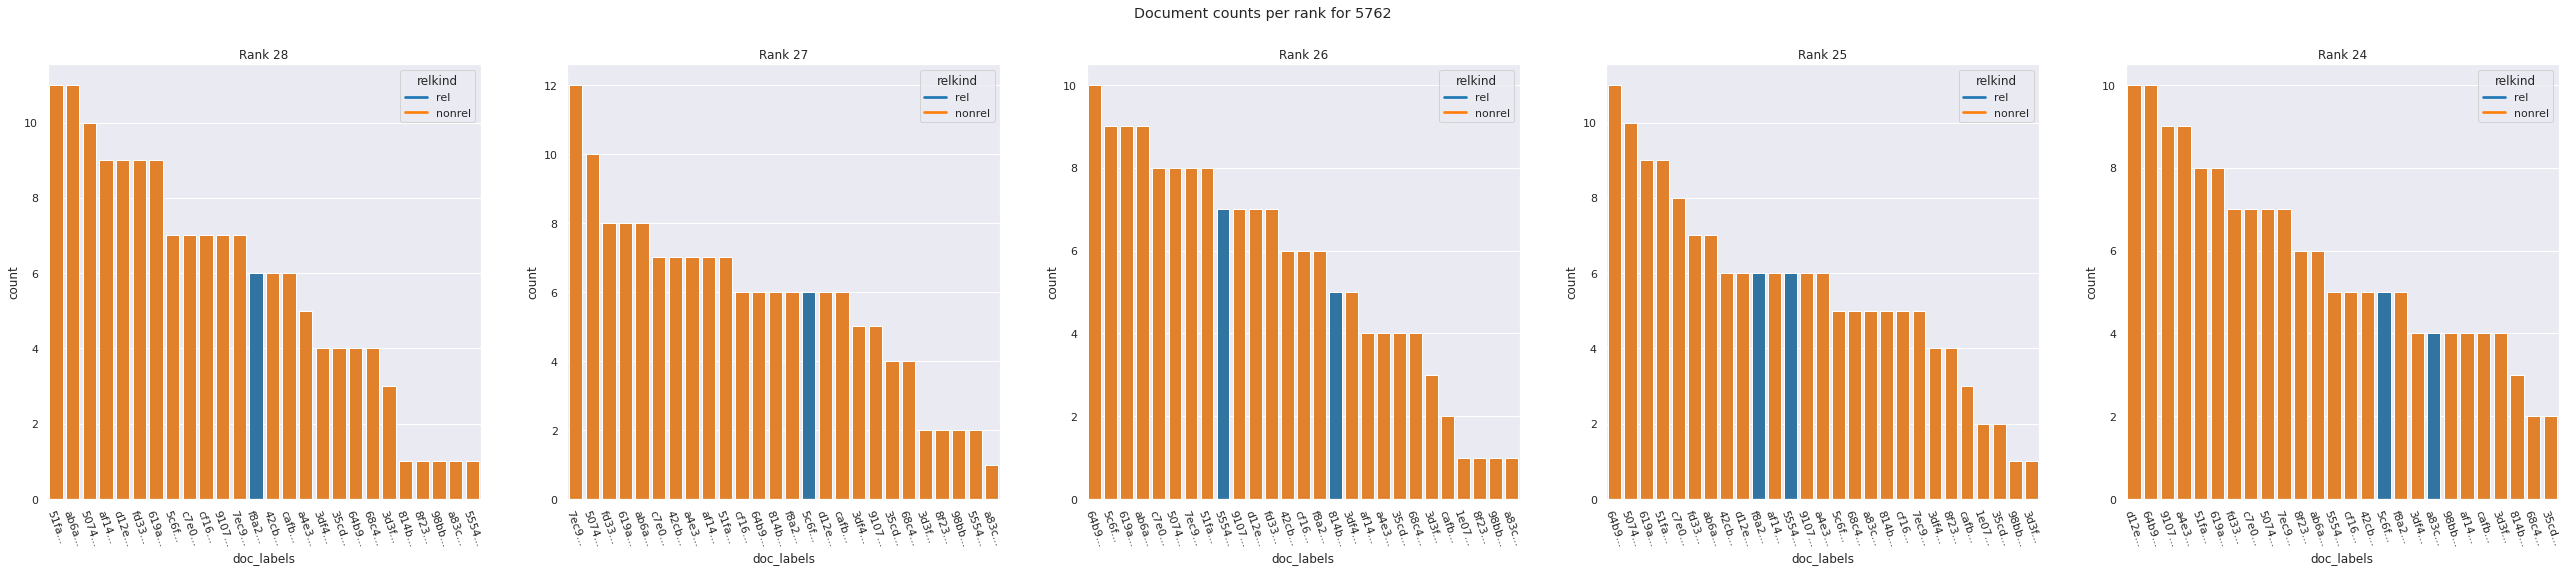

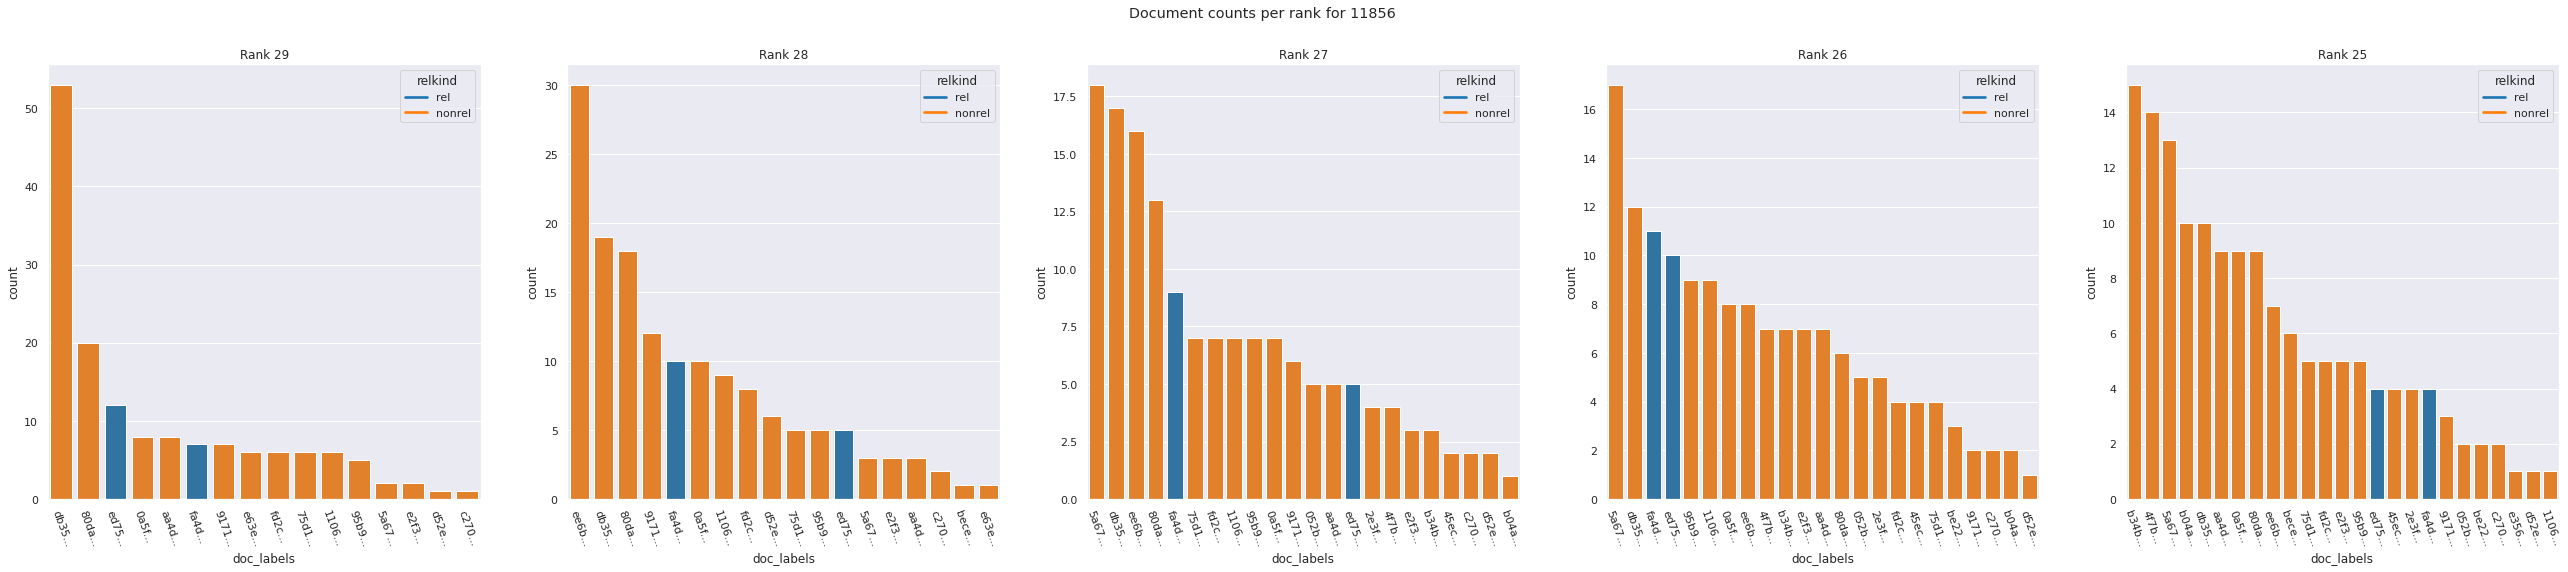

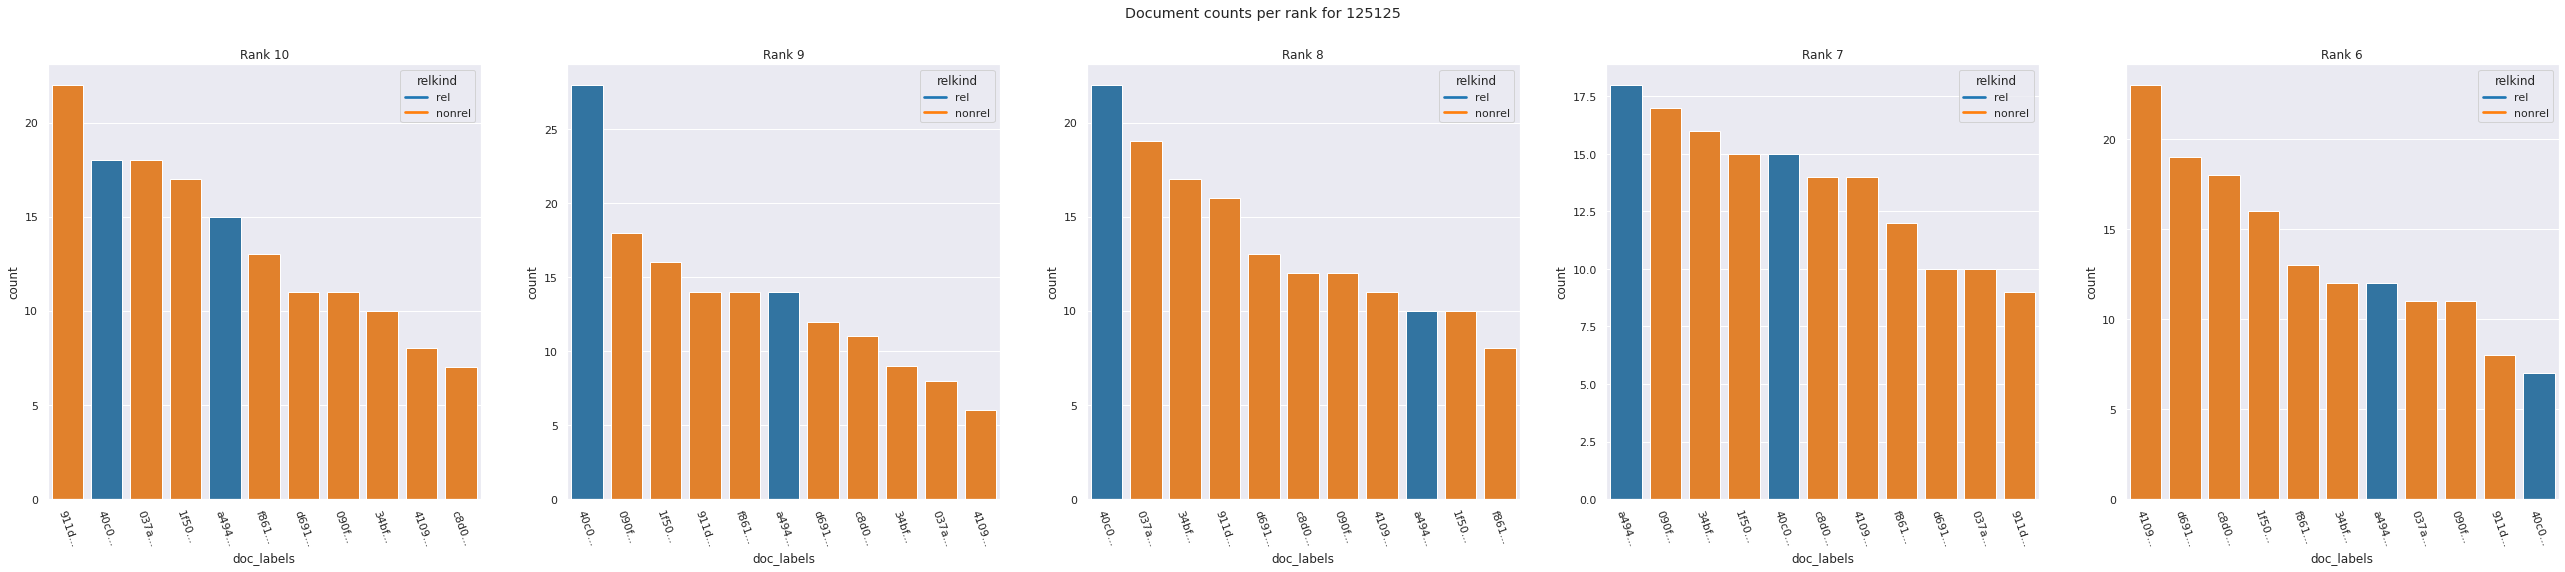

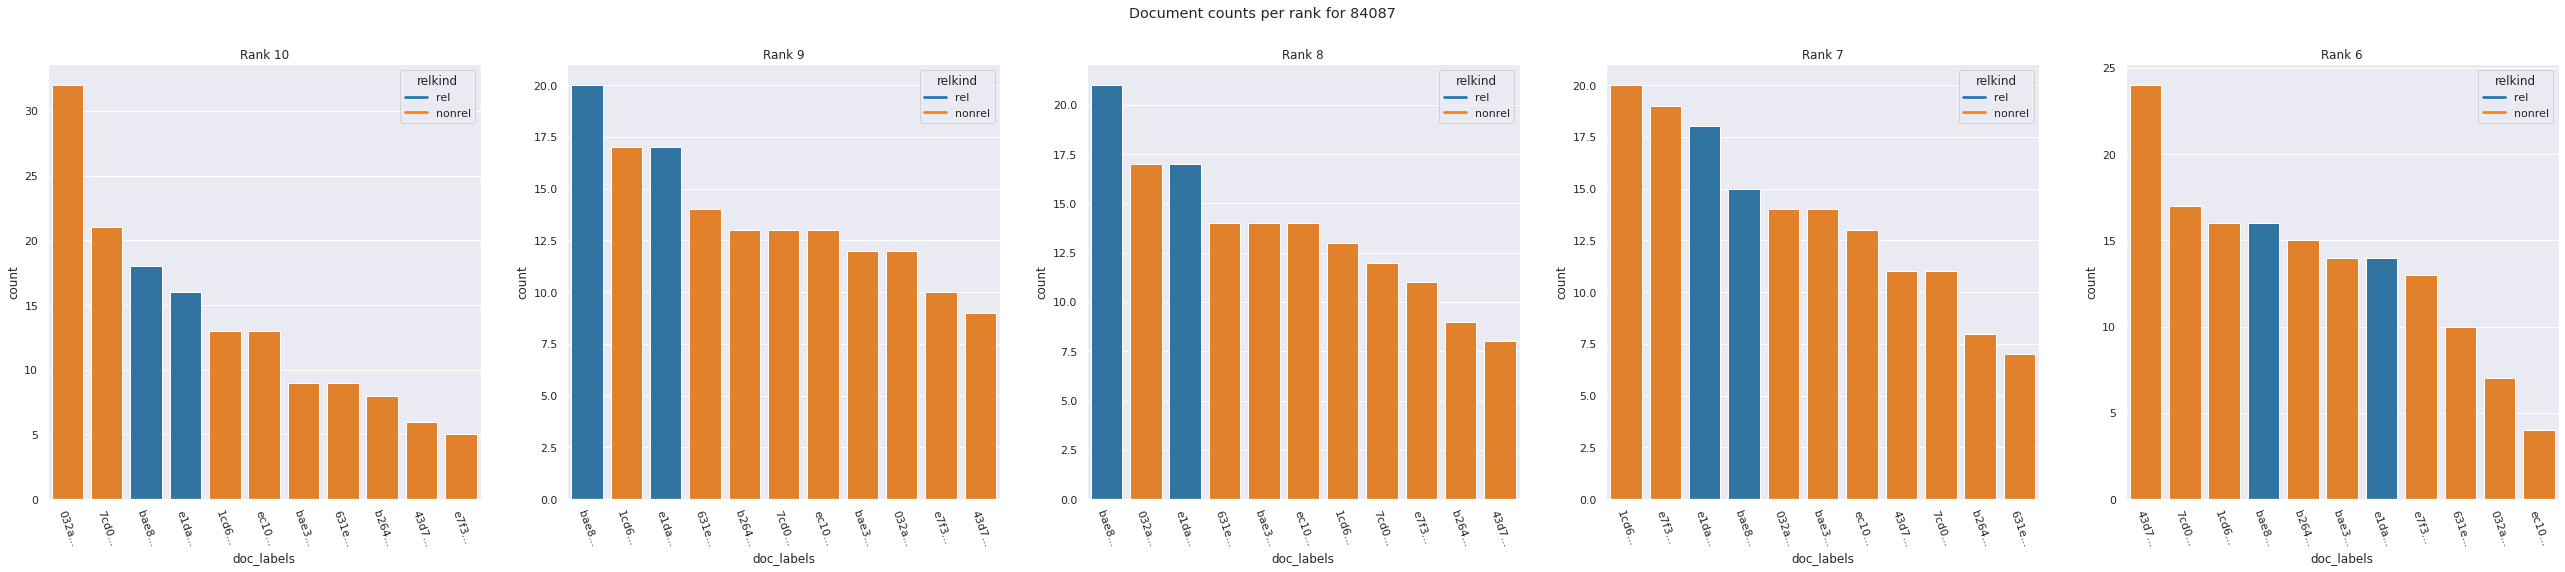

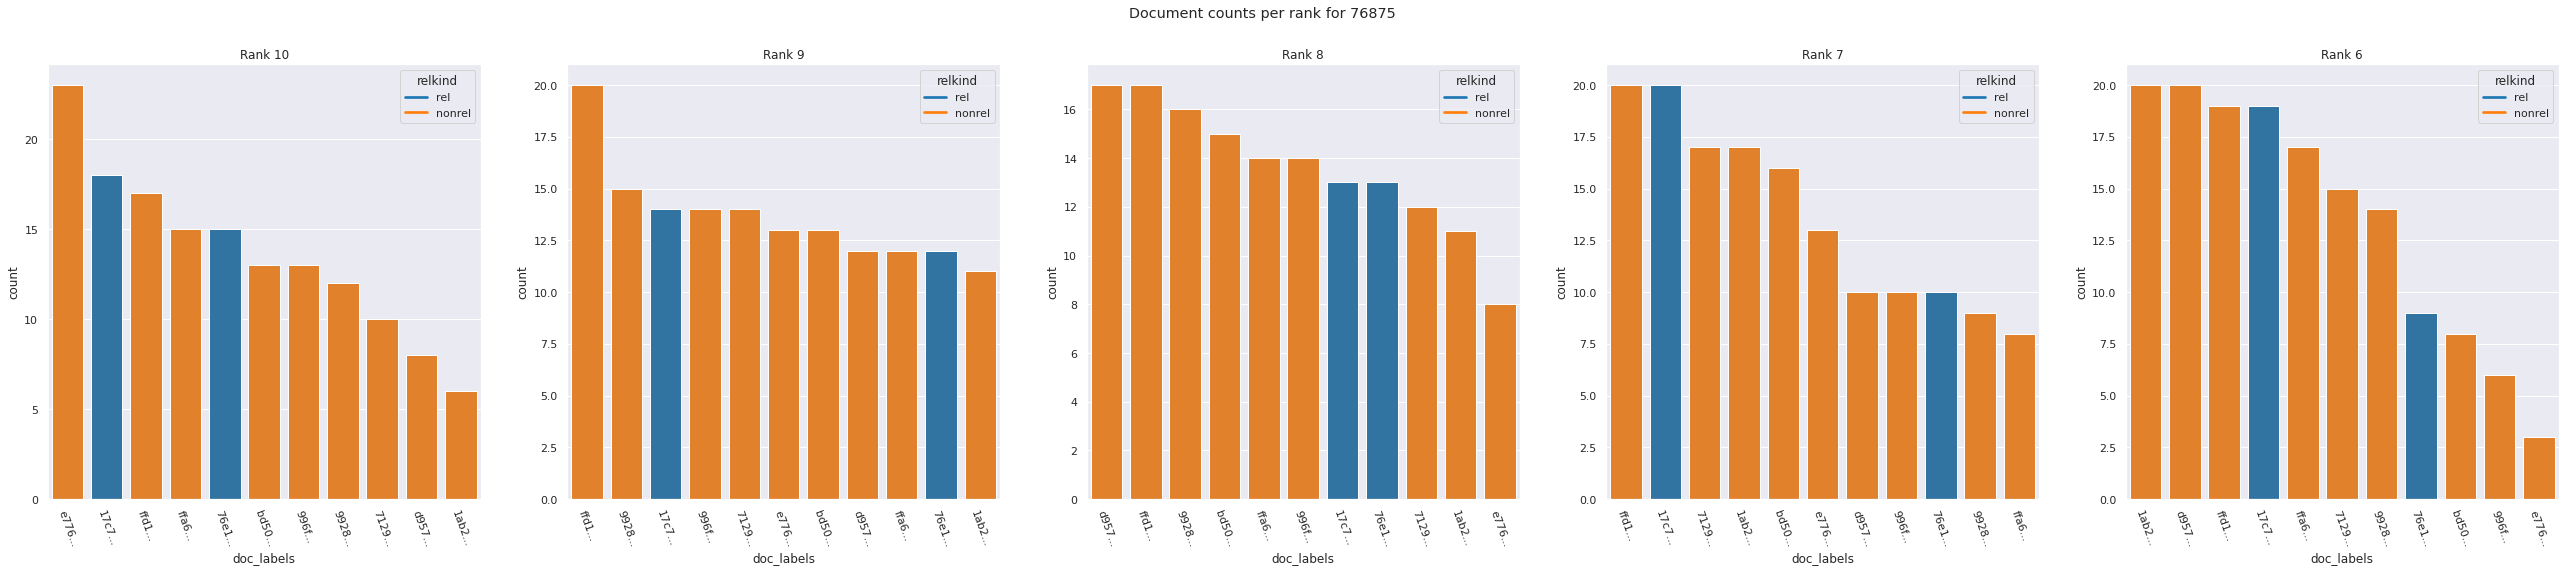

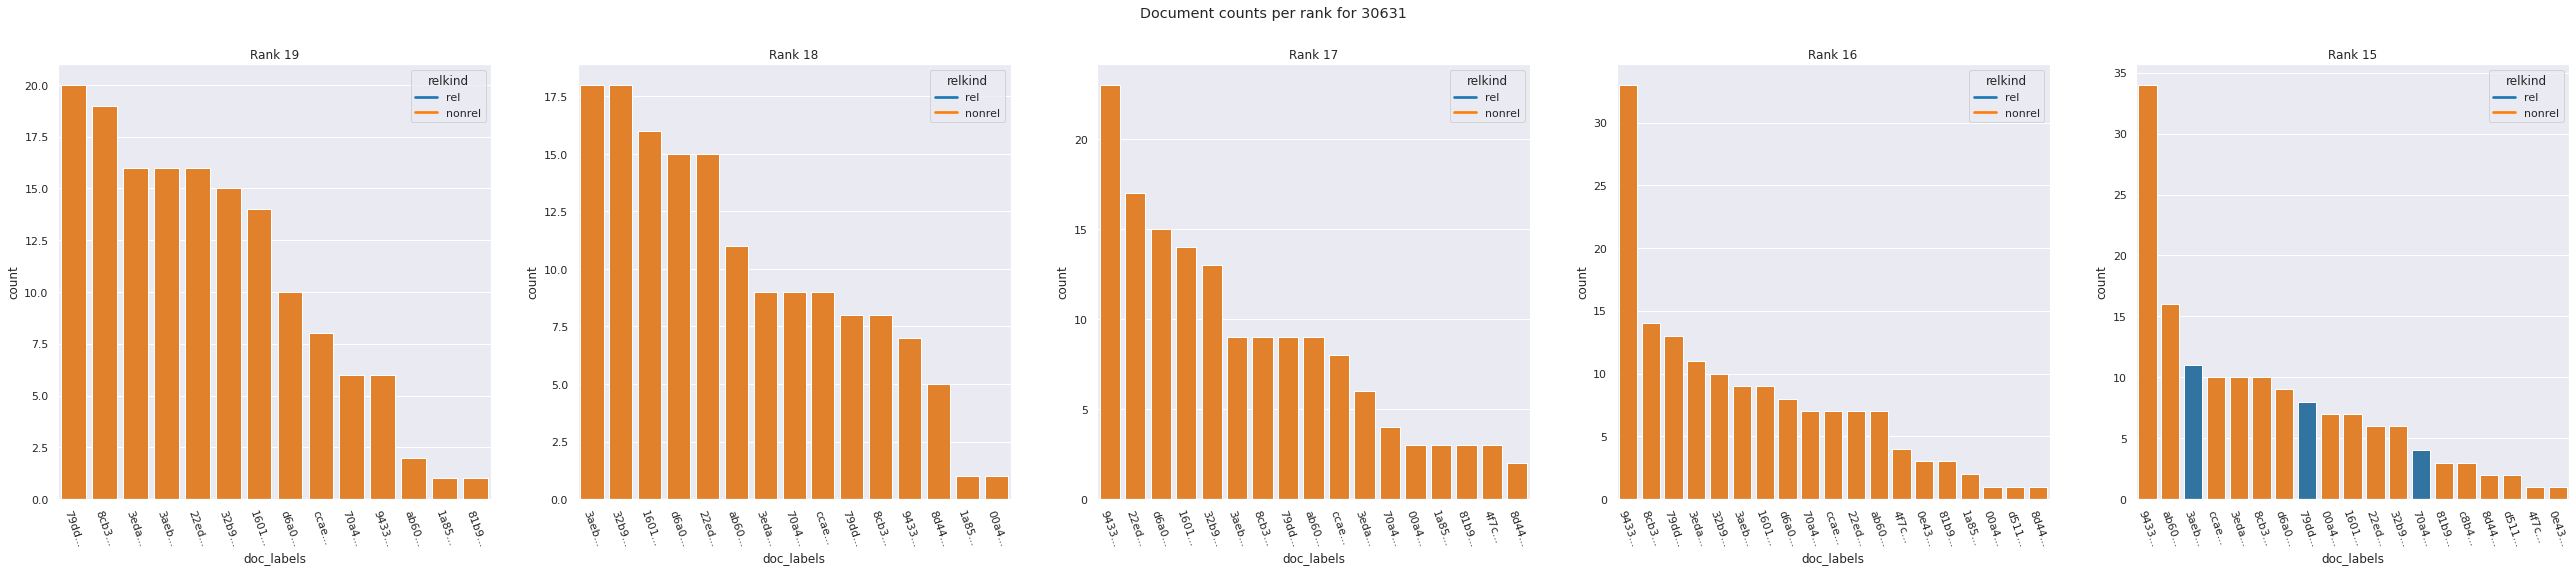

In [82]:
for q in bottomqueries.index.unique():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=5,rev=True)

##### Bottom positions

The bottom positions look more regular. They diminish more gently, without big spikes. They also look pretty similar between the top and bottom queries.


### Document position (top/bottom) counts

We plot how often each document occurs in a top or bottom position. In an ideal scenario, there is a uniform distribution across relevant docs for top positions and non-relevant docs in bottom positions.

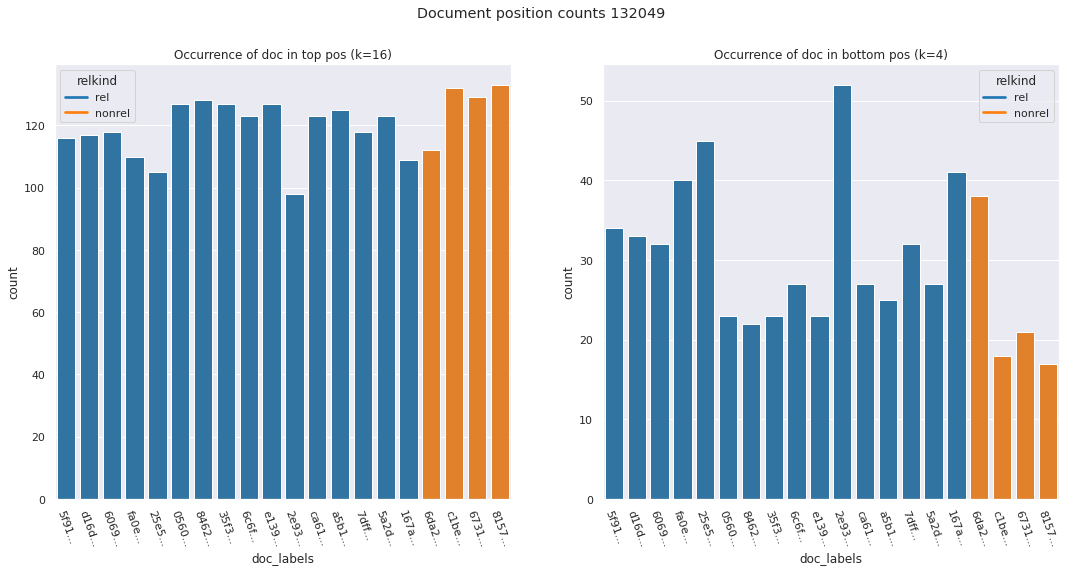

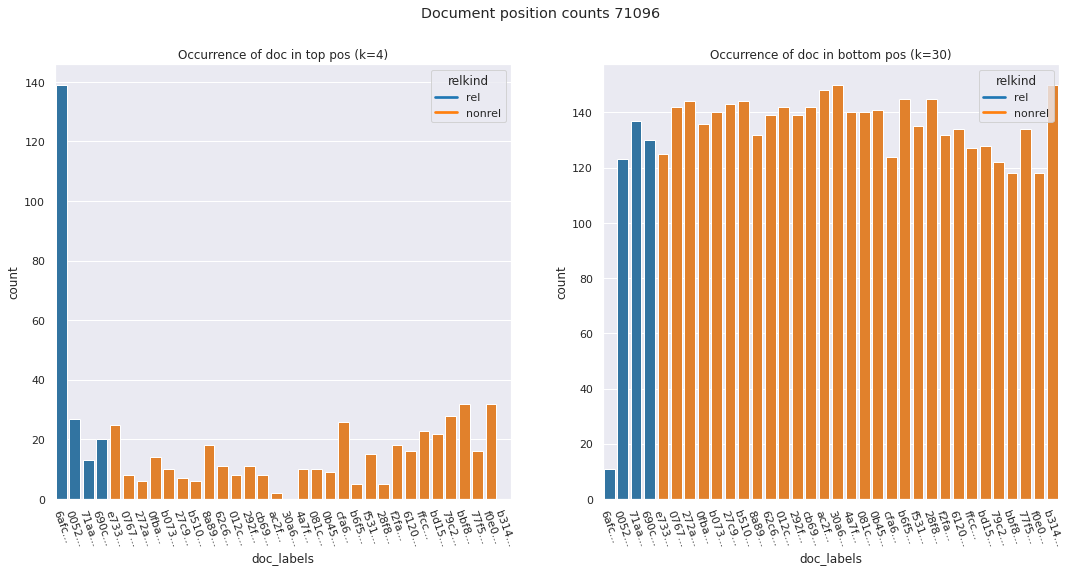

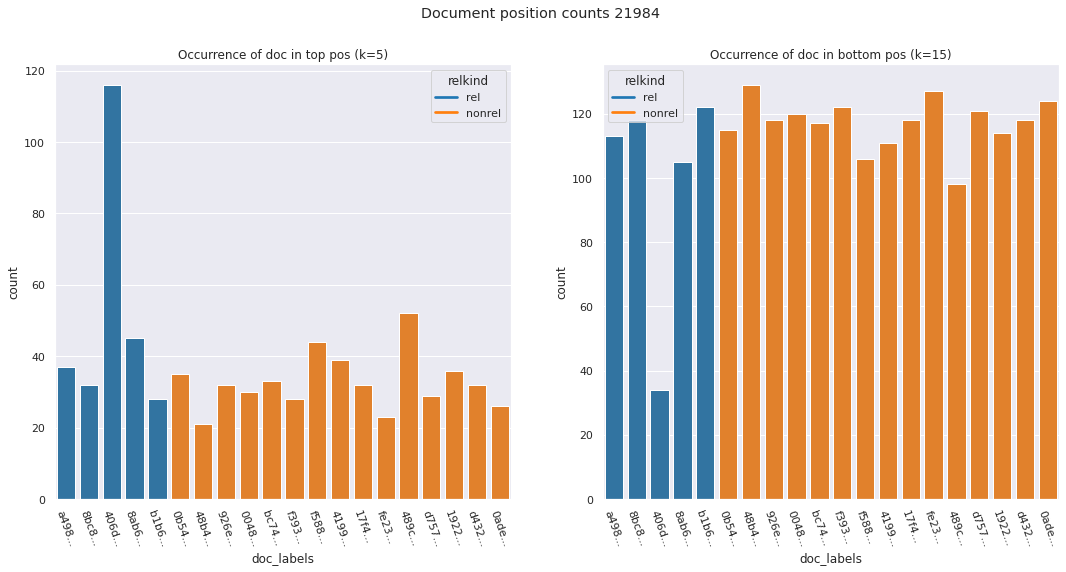

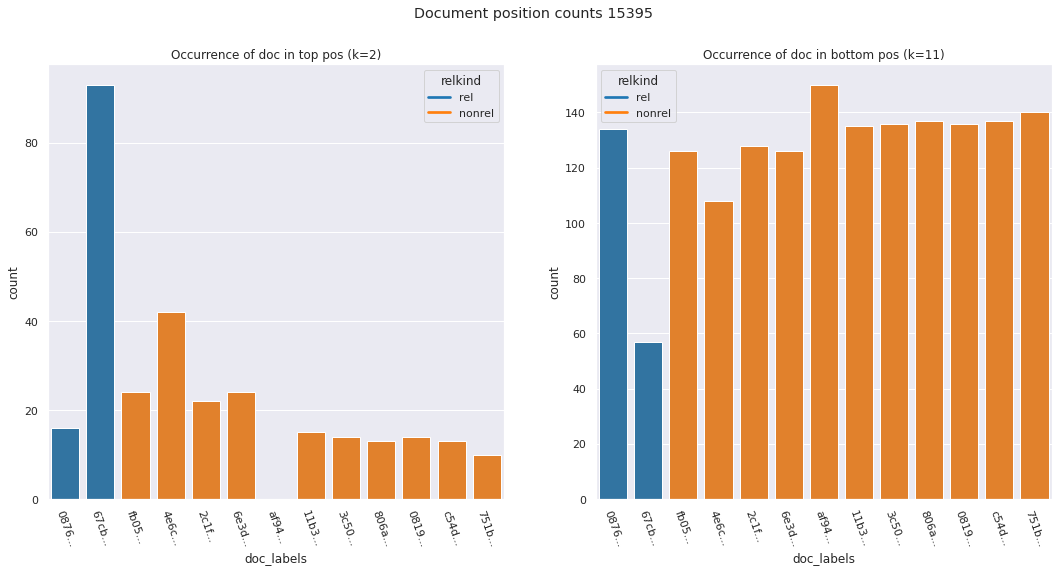

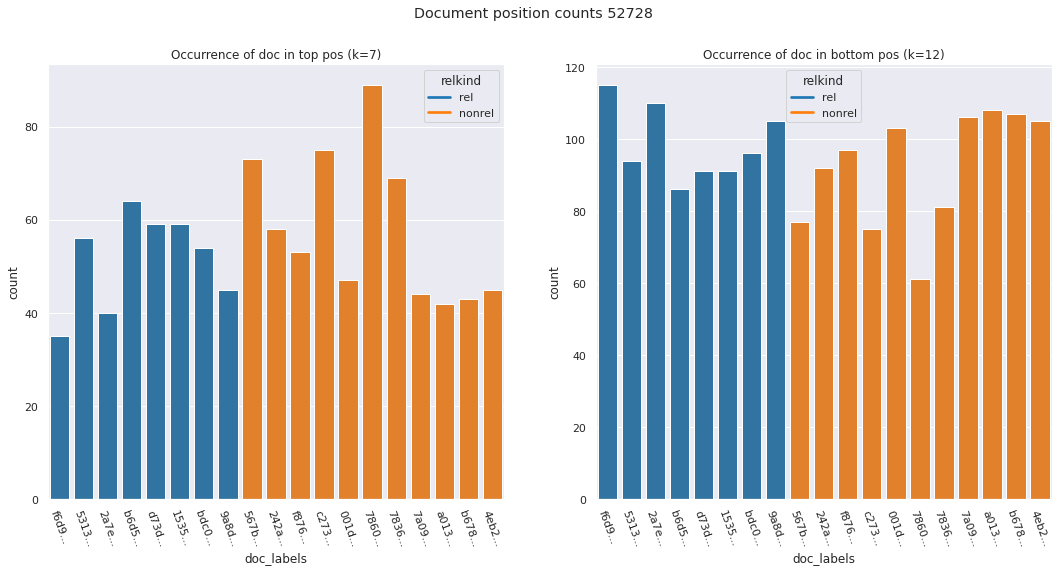

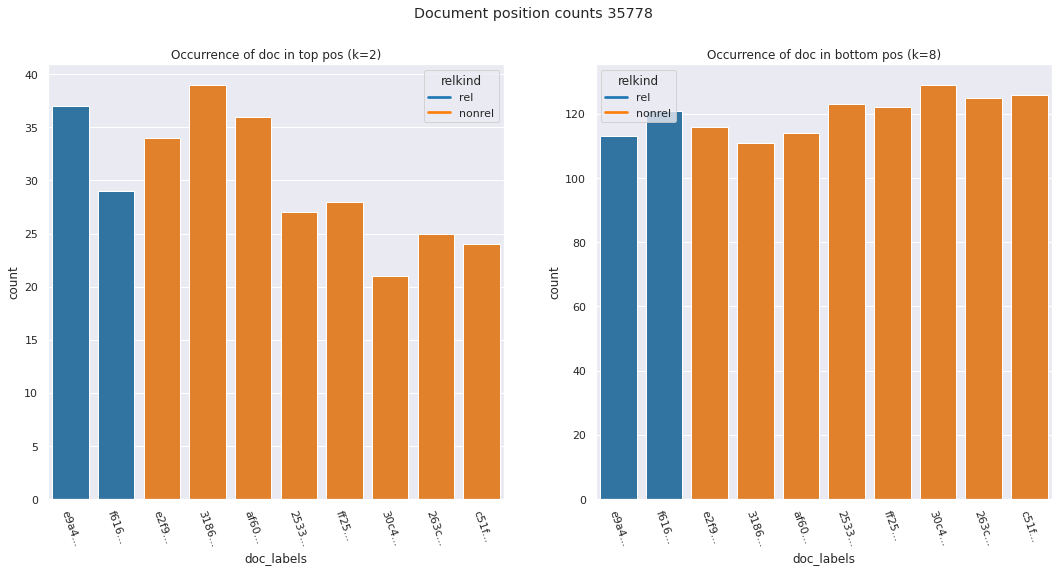

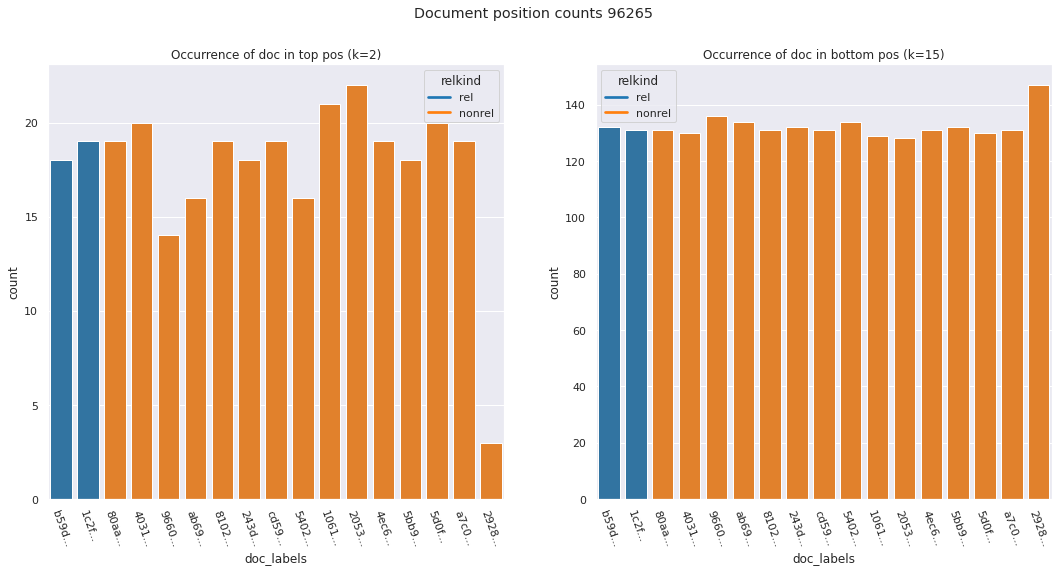

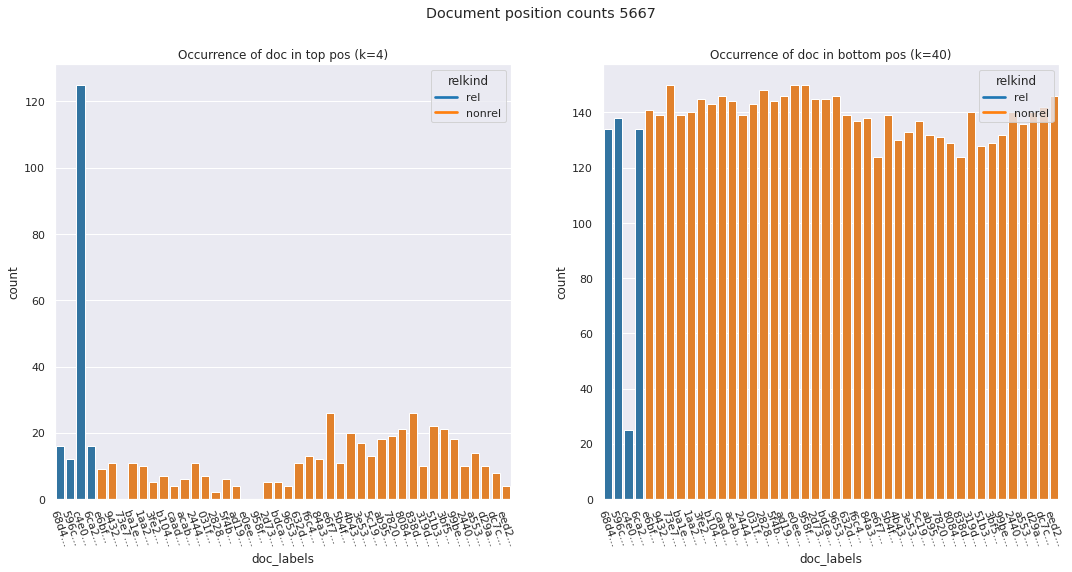

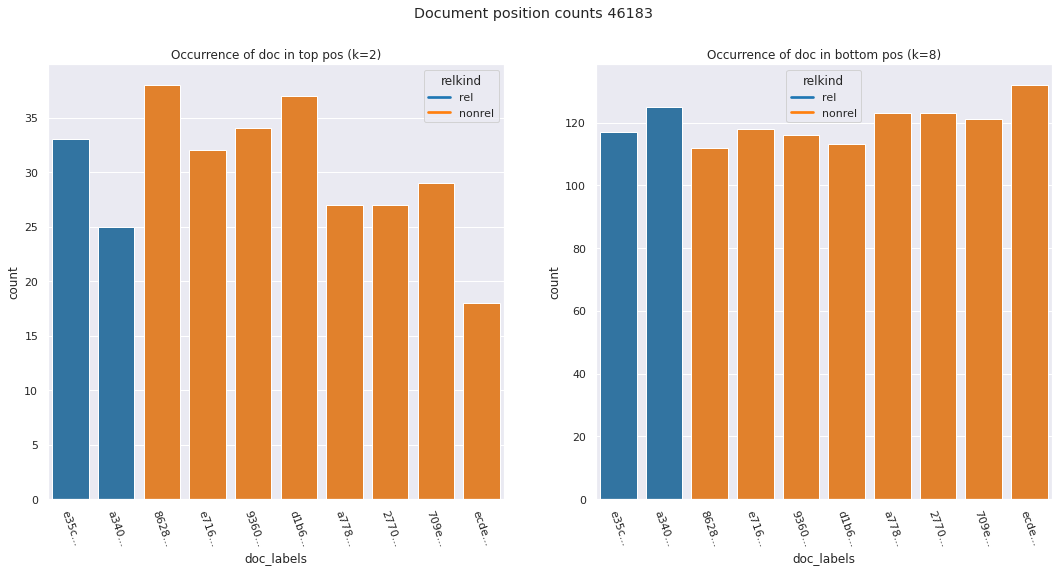

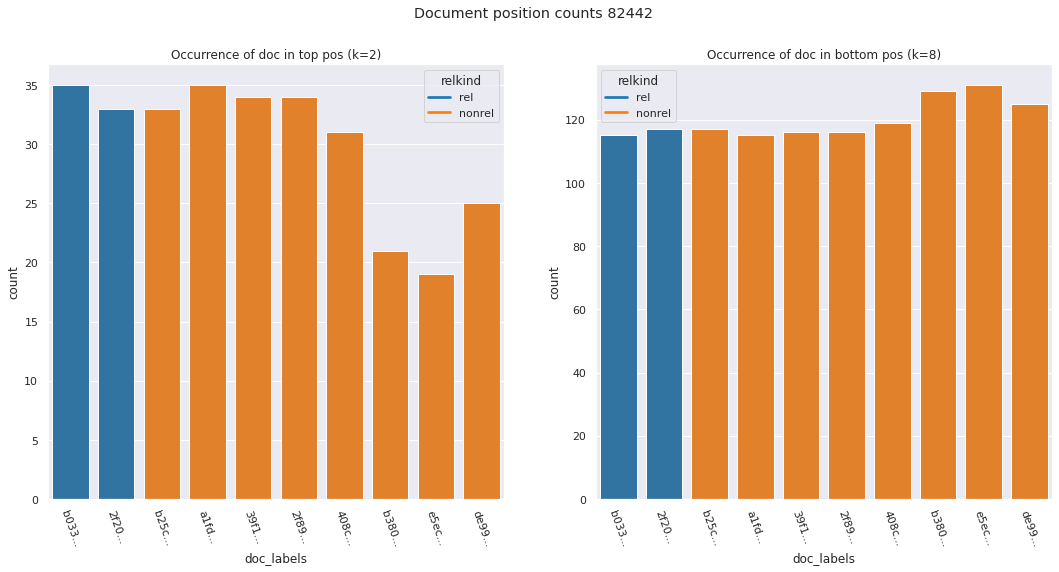

In [83]:
for q in topqueries.index.unique():
    plot_doc_pos_count_for_qid(q,rdf,reldf)

##### Top queries
Some things catch the eye:
- In general, there is a reasonably even distribution across the relevant documents in top positions and non-relevant documents in bottom positions.
- However, there are a couple of queries that have a spike for a relevant document in a top position.
  - 71096, 21984,15395, 5667
  
  
- There aren't necessarily fewer non-relevant documents in top positions, but they don't spike out.
- The distribution in bottom positions is reasonably even between relevant/ non-relevant documents, bar some dips that correspond to spikes in the top positions.
    
- There are multiple top queries for which there are irrelevant documents that appear in top positions more often than relevant documents. Why are they then still scoring high?
    - **Hypothesis**: These queries either have high relevance or low difference

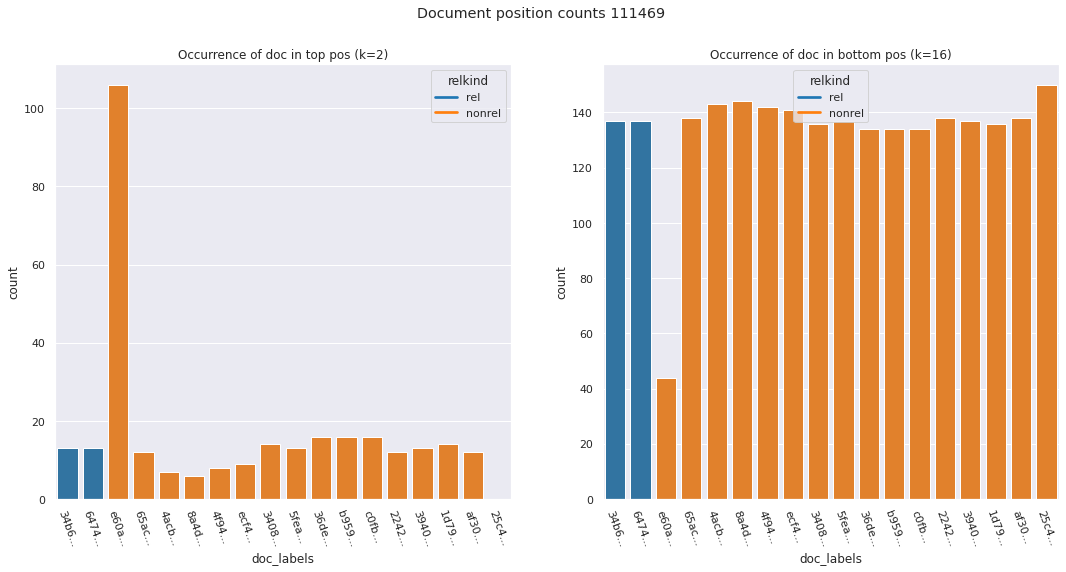

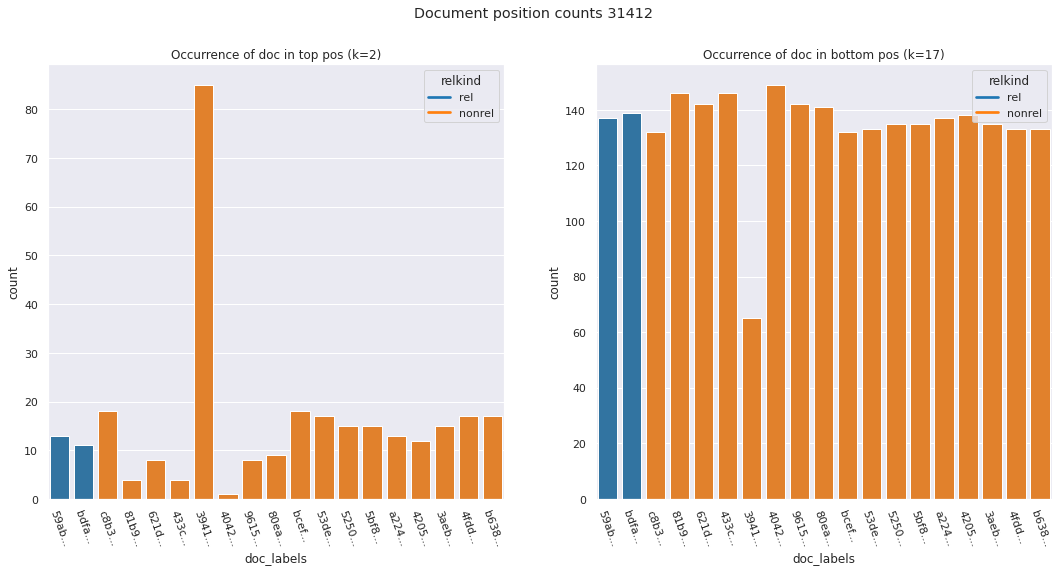

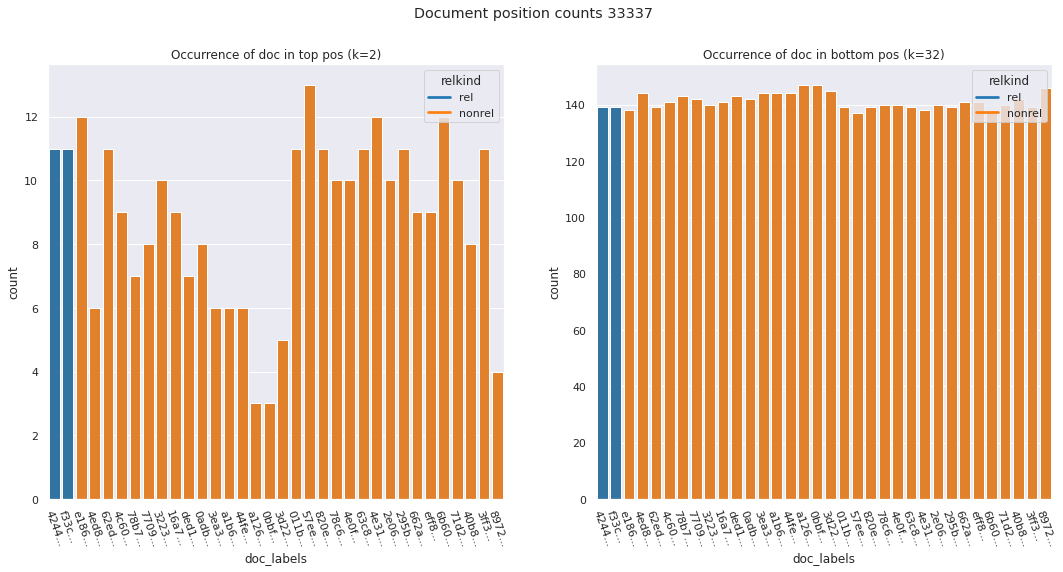

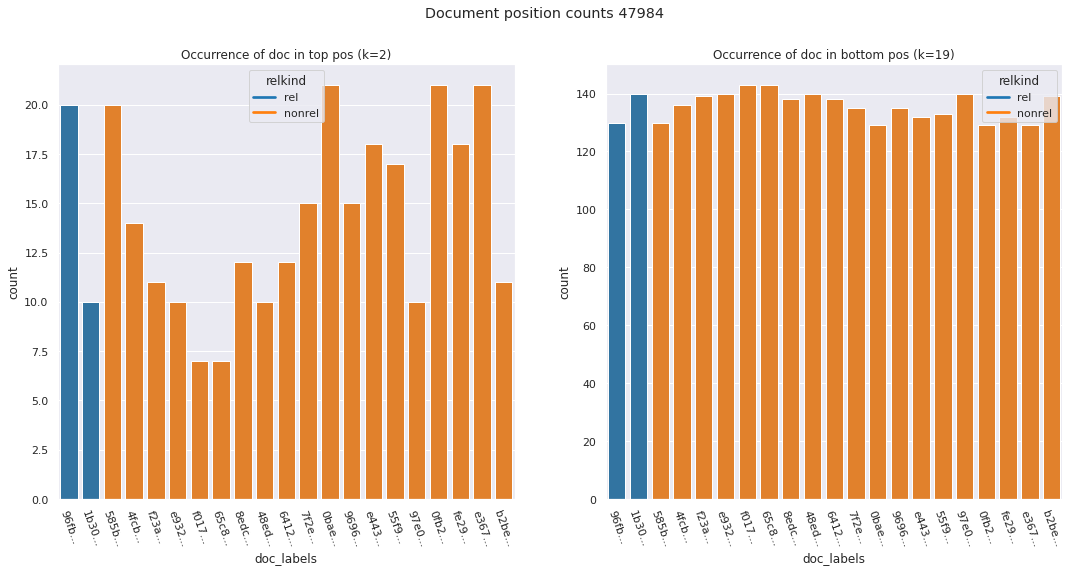

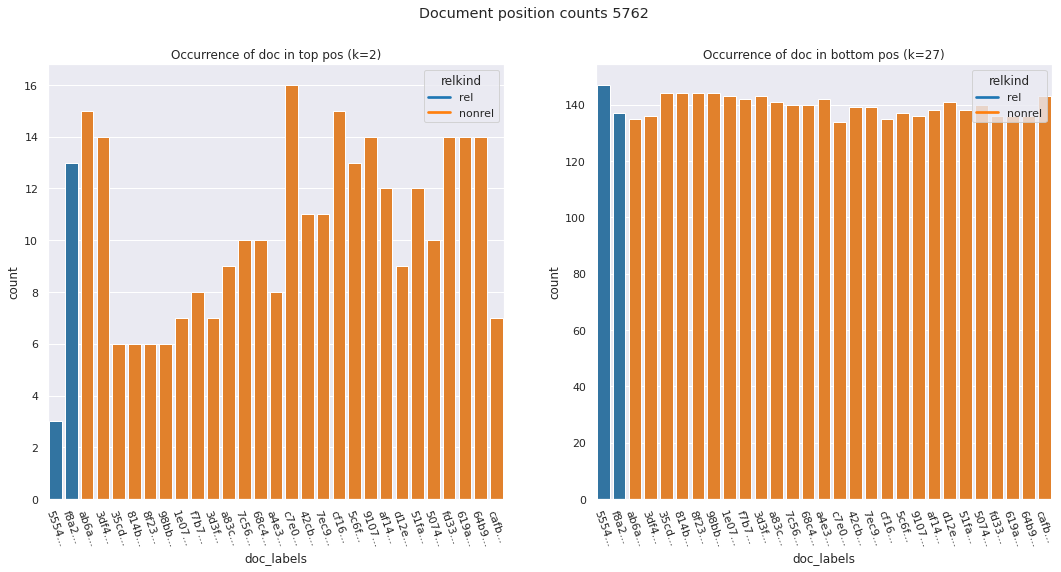

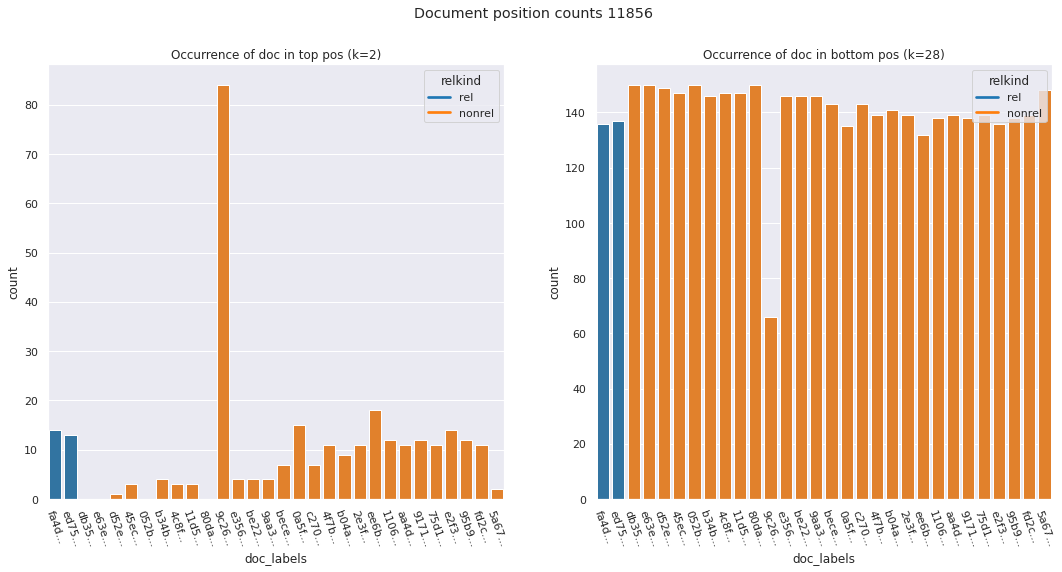

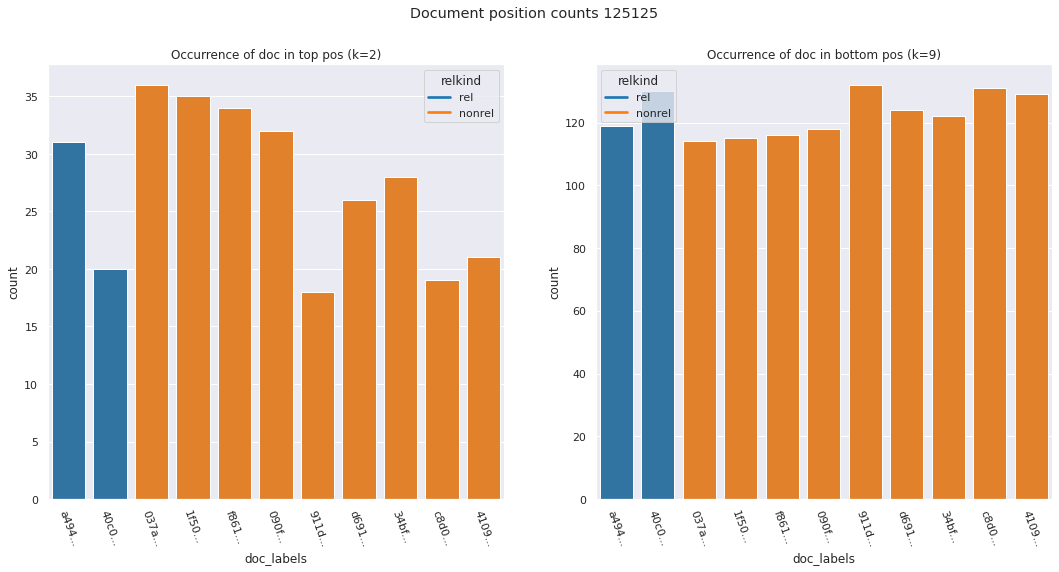

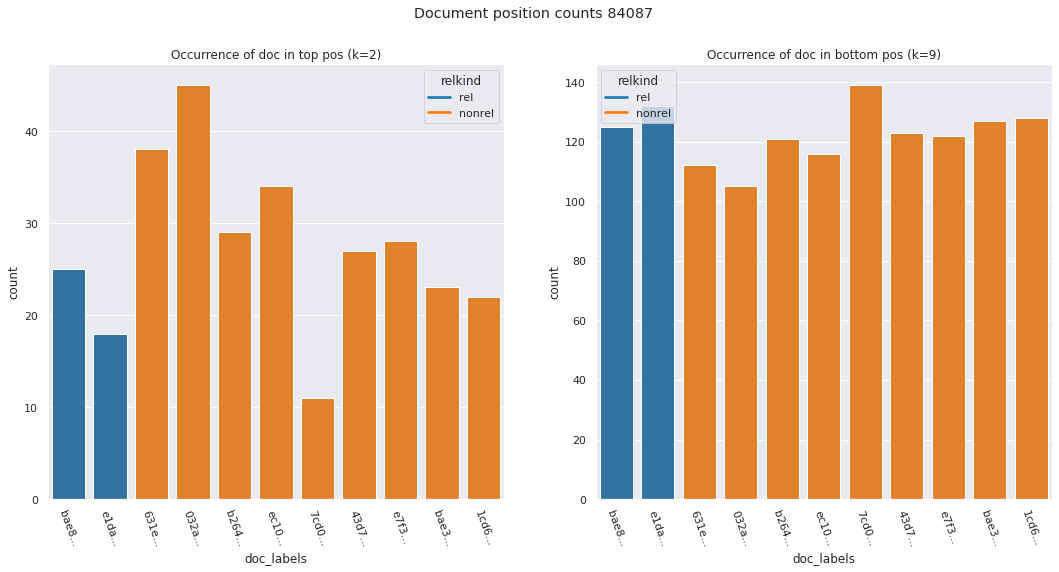

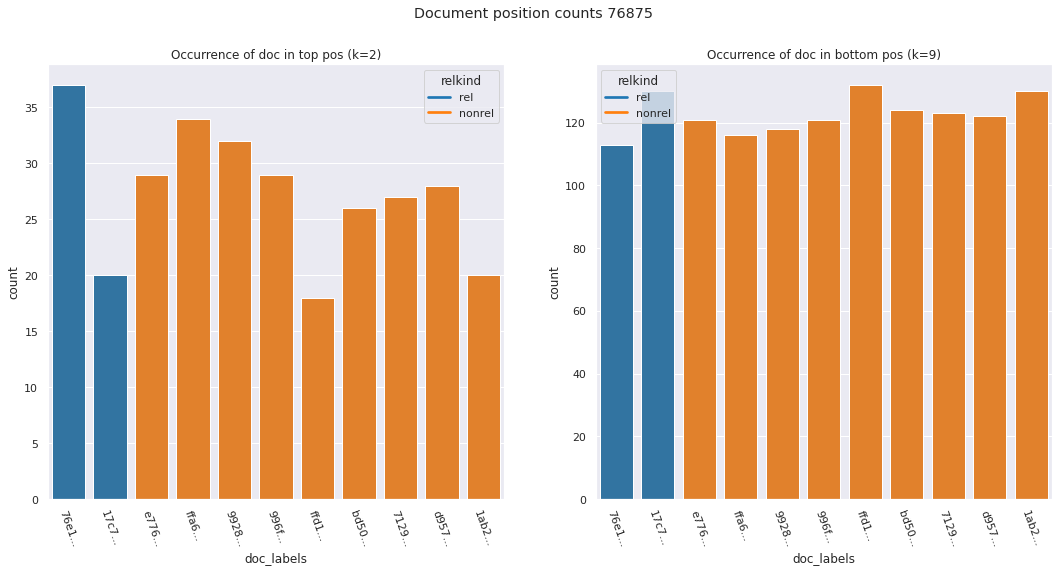

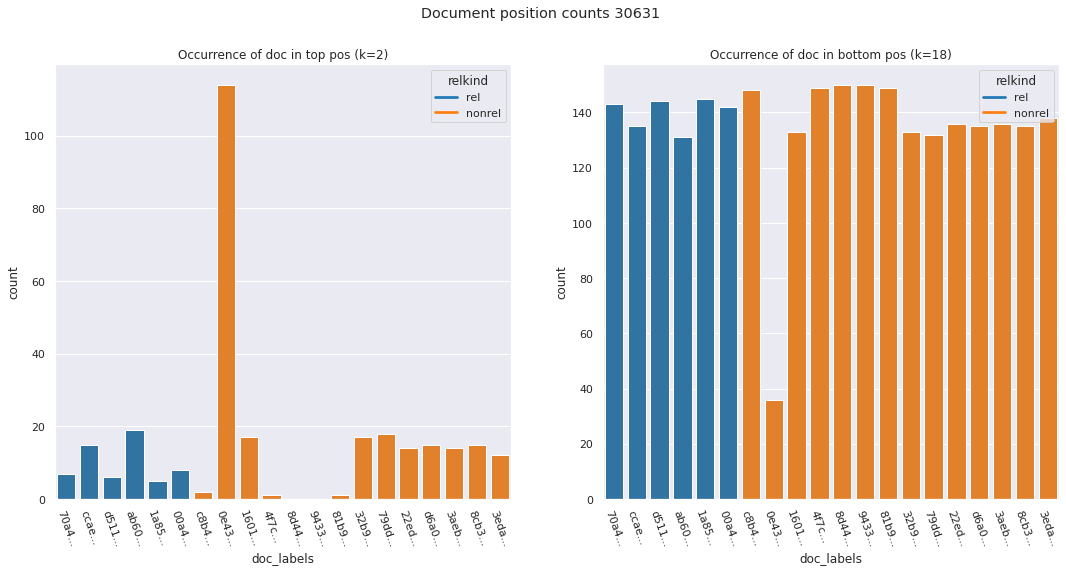

In [86]:
for q in bottomqueries.index.unique():
    plot_doc_pos_count_for_qid(q,rdf,reldf)

##### Bottom queries
- Almost each of these queries has at least one non-relevant document that occurs more often than the relevant documents
    - In most cases this is a "spike" document
    - There is one exception - why is this still ranking low?
          

## Hypotheses

Based on the plots we form a number of hypotheses:

1. Queries perform well when they have a high fraction of relevant items.
2. Queries perform well when they have a large number of items.
3. Queries perform poorly when they have many documents without author.
 - Conversely: queries perform well when they have many many documents without author, because then the ranking is more or less relevance-based.

4. All of the documents that spike in the rankings have no author.
5. Documents that are missing from their "proper" position (mainly relevant documents for top positions) have a low estimated relevance.



6. Documents for which the estimated relevance is too high/too low have been incorrectly judged by the NIST assessors.



7. For top queries, the documents without author are mainly relevant. For bottom queries, they are mainly irrelevant.

check:
- for each query for each rank, how often does a no-author document appear there and is it relevant or not?
    

### Hypothesis 1: Queries perform well when they have a high fraction of relevant items

In [87]:
def get_k_results(eval_df,k=10,asc=True):
    sub = eval_df.sort_values(by='difference',ascending=asc).head(k).reset_index()
    return sub

In [88]:
def rel_nonrel_stats_df(eval_df, k=10, asc=True):
    sub = get_k_results(eval_df,k,asc)
    sub[['r','nr']] = sub.apply(lambda row: count_relgrades_qid(row.qid,reldf), axis='columns', result_type='expand')
    sub[['rfrac','nrfrac']] = sub.apply(lambda row: {'rfrac': row.r / (row.r + row.nr), 'nrfrac': row.nr / (row.r + row.nr) }, axis='columns', result_type='expand')
    return sub

In [89]:
print("DGEE > mean:\t", len(edf[edf.difference > edf.difference.mean()]))
print()
print("DGEE <= mean:\t", len(edf[edf.difference <= edf.difference.mean()]))

DGEE > mean:	 65

DGEE <= mean:	 135


Taking the average across all queries that have a difference lower (higher) than the mean, the items with a lower mean have a higher fraction of relevant items than the items that have a higher mean.

In [92]:
top = rel_nonrel_stats_df(edf, k=len(edf[edf.difference <= edf.difference.mean()]))
bot = rel_nonrel_stats_df(edf, k=len(edf[edf.difference > edf.difference.mean()]), asc=False)

print("topqueries relmean:\t", top.rfrac.mean(),'\t',"botqueries relmean:\t\t", bot.rfrac.mean())
print("topqueries non-relmean:\t", top.nrfrac.mean(),'\t',"botqueries non-relmean:\t",bot.nrfrac.mean())


topqueries relmean:	 0.17629827614863894 	 botqueries relmean:		 0.15633218159781476
topqueries non-relmean:	 0.823701723851361 	 botqueries non-relmean:	 0.8436678184021852


The effect is even more clear if we look at the top and bottom 20 queries.

In [93]:
top = rel_nonrel_stats_df(edf,k=20)
bot = rel_nonrel_stats_df(edf,k=20,asc=False)
print("topk=20 relmean:\t",top.rfrac.mean(),'\tbotk=20 relmean:\t',bot.rfrac.mean())
print("topk=20 nrelmean:\t",top.nrfrac.mean(),'\tbotk=20 nrelmean:\t',bot.nrfrac.mean())


topk=20 relmean:	 0.2260622931022135 	botk=20 relmean:	 0.12806676915368892
topk=20 nrelmean:	 0.7739377068977864 	botk=20 nrelmean:	 0.871933230846311


In [94]:
for i in range(1,21):
    top = rel_nonrel_stats_df(edf,k=i)
    bot = rel_nonrel_stats_df(edf,k=i,asc=False)
    print(f"k={i}")
    print(f"top r:\t",round(top.rfrac.mean(),2),f'\tbot r:\t',round(bot.rfrac.mean(),2))
    print(f"top nr:\t",round(top.nrfrac.mean(),2),f'\tbot nr:\t',round(bot.nrfrac.mean(),2))
    print()

k=1
top r:	 0.2 	bot r:	 0.89
top nr:	 0.8 	bot nr:	 0.11

k=2
top r:	 0.46 	bot r:	 0.11
top nr:	 0.54 	bot nr:	 0.89

k=3
top r:	 0.39 	bot r:	 0.09
top nr:	 0.61 	bot nr:	 0.91

k=4
top r:	 0.33 	bot r:	 0.09
top nr:	 0.67 	bot nr:	 0.91

k=5
top r:	 0.34 	bot r:	 0.09
top nr:	 0.66 	bot nr:	 0.91

k=6
top r:	 0.31 	bot r:	 0.08
top nr:	 0.69 	bot nr:	 0.92

k=7
top r:	 0.29 	bot r:	 0.1
top nr:	 0.71 	bot nr:	 0.9

k=8
top r:	 0.26 	bot r:	 0.11
top nr:	 0.74 	bot nr:	 0.89

k=9
top r:	 0.26 	bot r:	 0.12
top nr:	 0.74 	bot nr:	 0.88

k=10
top r:	 0.25 	bot r:	 0.12
top nr:	 0.75 	bot nr:	 0.88

k=11
top r:	 0.24 	bot r:	 0.11
top nr:	 0.76 	bot nr:	 0.89

k=12
top r:	 0.22 	bot r:	 0.11
top nr:	 0.78 	bot nr:	 0.89

k=13
top r:	 0.21 	bot r:	 0.13
top nr:	 0.79 	bot nr:	 0.87

k=14
top r:	 0.22 	bot r:	 0.12
top nr:	 0.78 	bot nr:	 0.88

k=15
top r:	 0.24 	bot r:	 0.12
top nr:	 0.76 	bot nr:	 0.88

k=16
top r:	 0.23 	bot r:	 0.13
top nr:	 0.77 	bot nr:	 0.87

k=17
top r:	 0.23 	bo

In [78]:
data = rel_nonrel_stats_df(edf,k=200).reset_index()
data.head(5)

key  index     qid  difference  disparity  relevance   r  nr     rfrac  \
0        0  132049    0.002713   1.421254   1.403715  16   4  0.800000   
1        1   71096    0.029287   1.975807   1.862498   4  30  0.117647   
2        2   21984    0.032334   1.367385   1.271935   5  15  0.250000   
3        3   15395    0.040510   2.053024   1.890567   2  11  0.153846   
4        4   52728    0.057478   1.047360   0.839632   7  12  0.368421   

key    nrfrac  
0    0.200000  
1    0.882353  
2    0.750000  
3    0.846154  
4    0.631579

<AxesSubplot:xlabel='index', ylabel='rfrac'>

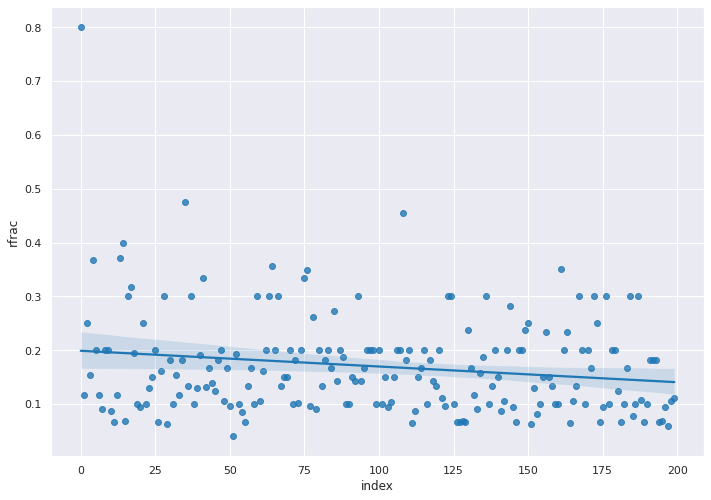

In [79]:
# sns.scatterplot(data=data, x="index", y="rfrac")
sns.regplot(data=data,x="index", y="rfrac")

We see a light descending line; the hypothesis is confirmed. The top queries have a higher fraction of relevant versus non-relevant items.

#### Subypothesis: The top queries have a higher average predicted relevance

- sum of estimated relevances for each relkind divided by number of items for that relkind

In [97]:
rel_and_estrel = pd.merge(pd.merge(edf.reset_index(),reldf[['qid','doc_rel','doc_id']], on='qid'),est_rel_meta, on=['qid','doc_id'])
rel_and_estrel['rel_estrel_diff'] = rel_and_estrel.apply(lambda row: abs(row.doc_rel - row.est_relevance),axis=1)
rel_and_estrel.head()

qid  difference  disparity  relevance_x  doc_rel  \
0   69    0.146308   2.820826     2.254359        0   
1   69    0.146308   2.820826     2.254359        1   
2   69    0.146308   2.820826     2.254359        0   
3   69    0.146308   2.820826     2.254359        0   
4   69    0.146308   2.820826     2.254359        0   

                                     doc_id  relevance_y  est_relevance  \
0  aacba5b65b7e7854744101233ce01f6085b9d592            0       0.166631   
1  088f1f39e09476624088779808916769f0415522            1       0.115253   
2  ad0d1b3ba06146606cba4784608575e76283f2d7            0       0.194834   
3  a0b4090a765679566773df3fb265db2e10aa4d8b            0       0.257027   
4  38a0fa90a395661f51f749cf42ce5f5de2c41d98            0       0.073940   

   rel_estrel_diff  
0         0.166631  
1         0.884747  
2         0.194834  
3         0.257027  
4         0.073940

In [98]:
mean_estrel_per_relkind = rel_and_estrel.groupby(['qid','doc_rel']).mean().reset_index()
mean_estrel_per_relkind.head()

qid  doc_rel  difference  disparity  relevance_x  relevance_y  \
0   69        0    0.146308   2.820826     2.254359            0   
1   69        1    0.146308   2.820826     2.254359            1   
2  258        0    0.549351   1.043557     0.679082            0   
3  258        1    0.549351   1.043557     0.679082            1   
4  439        0    0.517605   1.603399     0.887581            0   

   est_relevance  rel_estrel_diff  
0       0.154769         0.154769  
1       0.131208         0.868792  
2       0.150459         0.150459  
3       0.206604         0.793396  
4       0.153111         0.153111

In [99]:
desired_index = edf.reset_index().sort_values(by='difference').reset_index(drop=True).reset_index()
desired_index.head()

key  index     qid  difference  disparity  relevance
0        0  132049    0.002713   1.421254   1.403715
1        1   71096    0.029287   1.975807   1.862498
2        2   21984    0.032334   1.367385   1.271935
3        3   15395    0.040510   2.053024   1.890567
4        4   52728    0.057478   1.047360   0.839632

In [100]:
mean_estrel_with_index = pd.merge(mean_estrel_per_relkind,desired_index[['index','qid']],on='qid')
mean_estrel_with_index.head()

qid  doc_rel  difference  disparity  relevance_x  relevance_y  \
0   69        0    0.146308   2.820826     2.254359            0   
1   69        1    0.146308   2.820826     2.254359            1   
2  258        0    0.549351   1.043557     0.679082            0   
3  258        1    0.549351   1.043557     0.679082            1   
4  439        0    0.517605   1.603399     0.887581            0   

   est_relevance  rel_estrel_diff  index  
0       0.154769         0.154769     53  
1       0.131208         0.868792     53  
2       0.150459         0.150459    146  
3       0.206604         0.793396    146  
4       0.153111         0.153111    141

<AxesSubplot:xlabel='index', ylabel='est_relevance'>

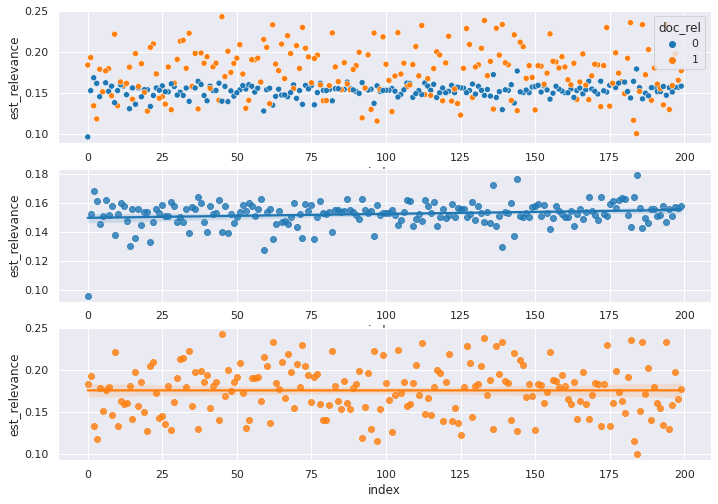

In [108]:
pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)
fig, ax = plt.subplots(3,1)
sns.scatterplot(data=mean_estrel_with_index,x='index',y='est_relevance',hue='doc_rel',ax= ax[0])
sns.regplot(data=mean_estrel_with_index[mean_estrel_with_index.doc_rel == 0],x='index',y='est_relevance',ax=ax[1],color=f)
sns.regplot(data=mean_estrel_with_index[mean_estrel_with_index.doc_rel == 1],x='index',y='est_relevance',ax=ax[2],color=s)

The top queries do *not* have a higher average predicted relevance than the bottom queries, so the discrepancy is likely *not* because of the estimated relevances.

#### Subhypothesis: The top queries have a higher fraction of items for which the actual and the predicted relevance are close to each other

Blur factor, fig 1 in [3], blur closer to true relevance is less unfairness compared to Plackett-Luce. May be because is better able to predict based on relevance also?

If the predicted relevances are closer to the actual relevances the ranker is better able to take relevance into account, leading to better results?

Plot: mean difference between predicted and actual relevances
Subplots: split by GT rel and nonrel items

In [109]:
rel_and_estrel = pd.merge(pd.merge(edf.reset_index(),reldf[['qid','doc_rel','doc_id']], on='qid'),est_rel_meta, on=['qid','doc_id'])
rel_and_estrel['rel_estrel_diff'] = rel_and_estrel.apply(lambda row: abs(row.doc_rel - row.est_relevance),axis=1)
rel_and_estrel.head()

qid  difference  disparity  relevance_x  doc_rel  \
0   69    0.146308   2.820826     2.254359        0   
1   69    0.146308   2.820826     2.254359        1   
2   69    0.146308   2.820826     2.254359        0   
3   69    0.146308   2.820826     2.254359        0   
4   69    0.146308   2.820826     2.254359        0   

                                     doc_id  relevance_y  est_relevance  \
0  aacba5b65b7e7854744101233ce01f6085b9d592            0       0.166631   
1  088f1f39e09476624088779808916769f0415522            1       0.115253   
2  ad0d1b3ba06146606cba4784608575e76283f2d7            0       0.194834   
3  a0b4090a765679566773df3fb265db2e10aa4d8b            0       0.257027   
4  38a0fa90a395661f51f749cf42ce5f5de2c41d98            0       0.073940   

   rel_estrel_diff  
0         0.166631  
1         0.884747  
2         0.194834  
3         0.257027  
4         0.073940

In [110]:
mean_estrel_diff = rel_and_estrel.groupby('qid', as_index=False).mean()[['qid','difference','doc_rel','rel_estrel_diff']]
estrel_diff_sorted = mean_estrel_diff.sort_values(by='difference').reset_index(drop=True).reset_index()
estrel_diff_sorted.head()

index     qid  difference   doc_rel  rel_estrel_diff
0      0  132049    0.002713  0.800000         0.671958
1      1   71096    0.029287  0.117647         0.229722
2      2   21984    0.032334  0.250000         0.342826
3      3   15395    0.040510  0.153846         0.272482
4      4   52728    0.057478  0.368421         0.394289

In [111]:
desired_index = edf.reset_index().sort_values(by='difference').reset_index(drop=True).reset_index()
splitdata = rel_and_estrel.sort_values(by='difference').reset_index(drop=True)
splitdata = pd.merge(splitdata,desired_index[['qid','index']],on='qid')
splitdata.head()

qid  difference  disparity  relevance_x  doc_rel  \
0  132049    0.002713   1.421254     1.403715        0   
1  132049    0.002713   1.421254     1.403715        1   
2  132049    0.002713   1.421254     1.403715        1   
3  132049    0.002713   1.421254     1.403715        1   
4  132049    0.002713   1.421254     1.403715        0   

                                     doc_id  relevance_y  est_relevance  \
0  8157ceeb5c2cb3abdcd4347a7fae3377d25959d9            0       0.064553   
1  60699a68c32e0e1f2f5318423c5eed6e8e000bff            1       0.179613   
2  d16d4ab632d18d70c0ffd9d4d7493444281275e5            1       0.179613   
3  e13918f61745d29a2e84101ebfc46e9487d38fca            1       0.179613   
4  6da29e3f7e9ab2cbedccb71201ae62ed52f949a4            0       0.187206   

   rel_estrel_diff  index  
0         0.064553      0  
1         0.820387      0  
2         0.820387      0  
3         0.820387      0  
4         0.187206      0

Text(0.5, 0.98, 'Mean difference between actual and predicted relevances for each query (sorted by ascending DGEE)')

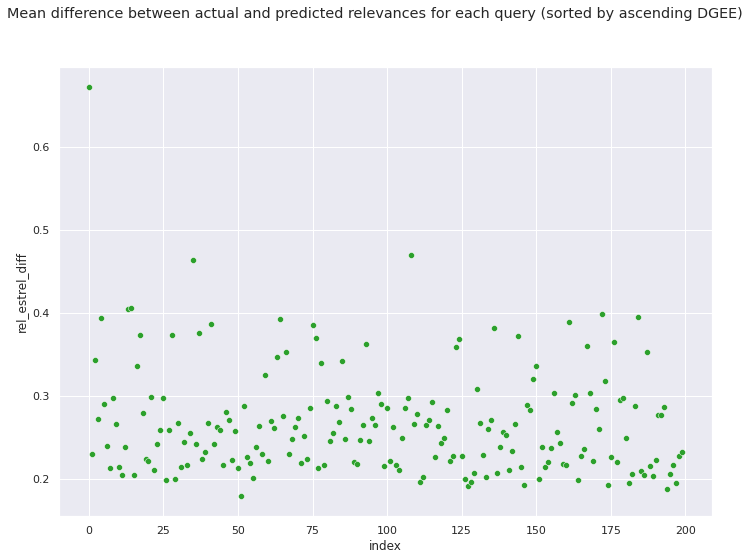

In [112]:
fig, ax = plt.subplots(1,1)
pi = iter(sns.color_palette())
next(pi)
next(pi)
sns.scatterplot(data=estrel_diff_sorted,x='index',y='rel_estrel_diff',ax=ax,color=next(pi))
fig.suptitle("Mean difference between actual and predicted relevances for each query (sorted by ascending DGEE)")

Text(0.5, 0.98, 'Difference between estimated and actual relevance for non-relevant documents for each query, ordered by ascending DGEE')

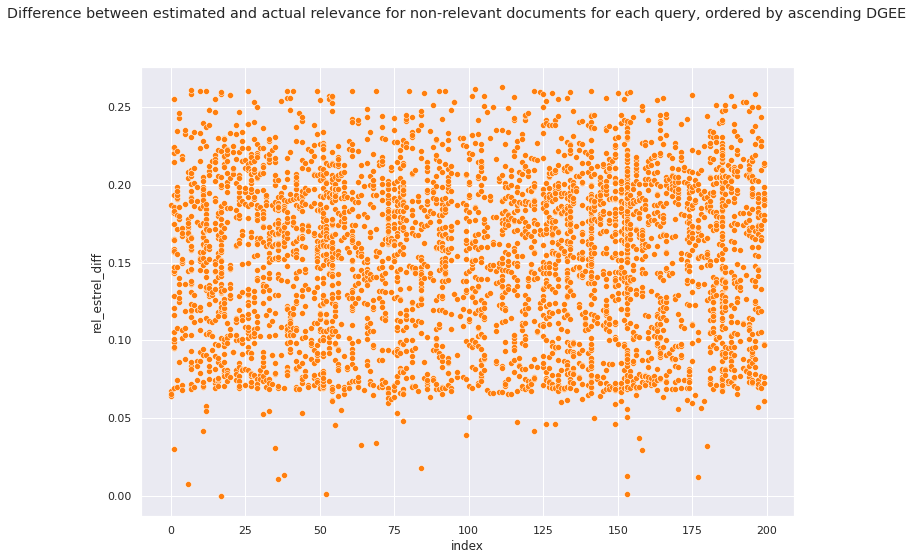

In [113]:
fig, ax = plt.subplots(1,1)
pi = iter(sns.color_palette())
next(pi)
sns.scatterplot(data=splitdata[splitdata.doc_rel == 0],x='index',y='rel_estrel_diff', color=next(pi))
fig.suptitle('Difference between estimated and actual relevance for non-relevant documents for each query, ordered by ascending DGEE')

Text(0.5, 0.98, 'Difference between estimated and actual relevance for relevant documents for each query, ordered by ascending DGEE')

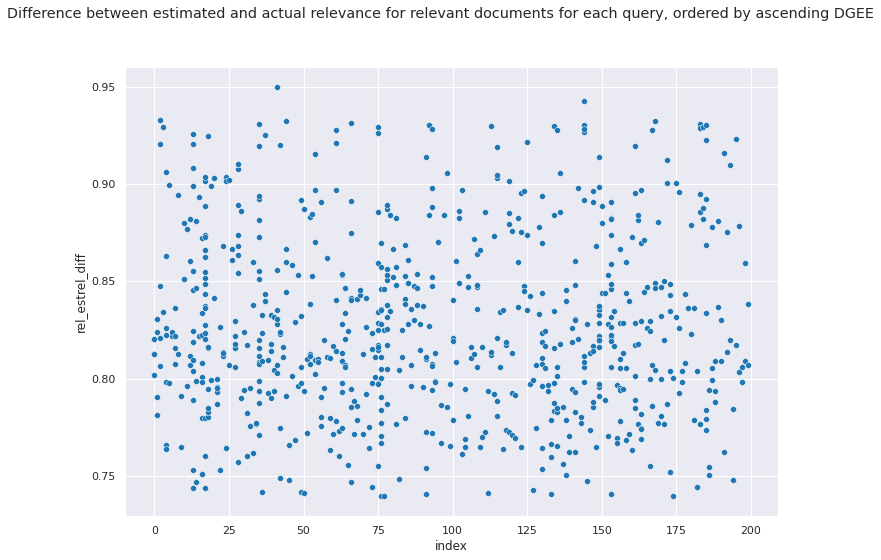

In [114]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=splitdata[splitdata.doc_rel == 1],x='index',y='rel_estrel_diff')
fig.suptitle('Difference between estimated and actual relevance for relevant documents for each query, ordered by ascending DGEE')

We see a couple of things:
1. The mean difference between estimated relevance and actual relevance is larger for the best queries. Contrary to our hypothesis.
2. For the non-relevant items, the difference in estimated and actual relevance is reasonably the same across all queries.
3. For the relevant items, we see a couple of outliers for which the difference is much larger than for the rest of the documents. 

#### To find out
- [ ] Which documents correspond to the outliers?
- [ ] What is their impact on the quality of the rankings?

### Hypothesis 2: Queries perform well when they have a large number of items
The thought being: many items give a chance for averaging out mistakes.

### Hypothesis 4: All of the documents that spike in the rankings have no author.

Show the documents without author in a different color.

In [115]:
def find_docs_without_author(relevance):
    es = Elasticsearch([{'timeout':300}])
    
    all_ids = list(relevance.doc_id.unique())
    res = es.search(index='semanticscholar2020og', body={'size':len(all_ids),'query':{'ids':{'values':all_ids}}})
    returned_ids = [hit['_id'] for hit in res['hits']['hits']]
    not_in_index = list(set(all_ids) - set(returned_ids))
    no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
    no_author = list(set(not_in_index + no_author_in_idx))
    return no_author

In [116]:
def has_author_df(no_author_ids, relevance):
    relevance['has_author'] = relevance.apply(lambda row: row.doc_id not in no_author_ids,axis='columns')
    return relevance[['doc_id','has_author']].drop_duplicates()

In [117]:
noauth_ids = find_docs_without_author(reldf)

In [118]:
author_info = has_author_df(find_docs_without_author(reldf),reldf)
author_info.head()

doc_id  has_author
0  3e19046c665867bbe557685da60738a40738010a        True
0  7ef08f1fa127af817cdfd9d3bd00bdf60e32143b        True
0  ec13c3e7119191802e6f5783d297fe7a5a05293e        True
0  8fc928bb430d3f72ac876ca156042ad1860acacd        True
0  b2fdee22aa02477292b858fbafcb418932732bce        True

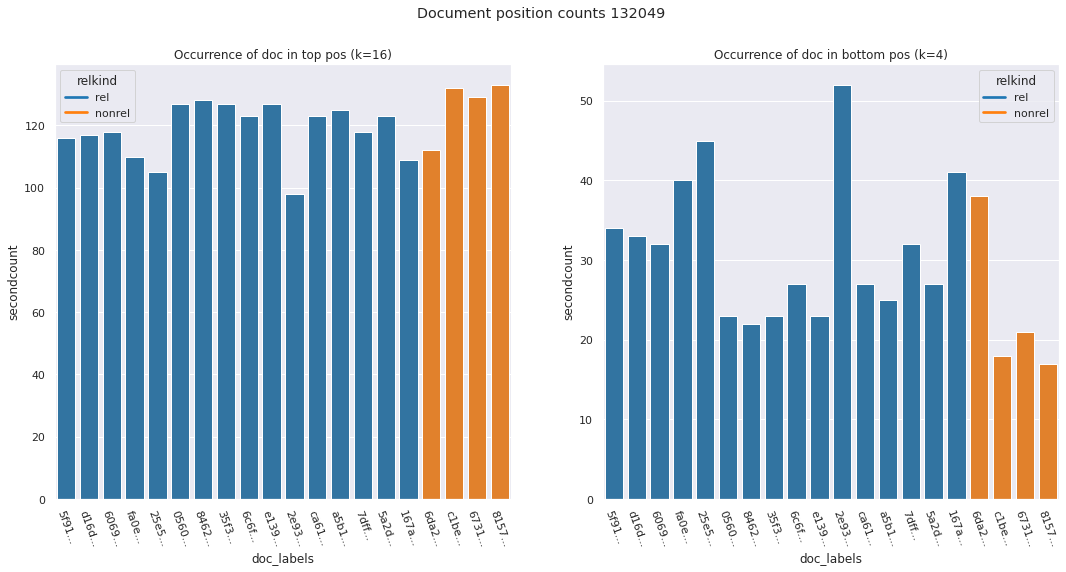

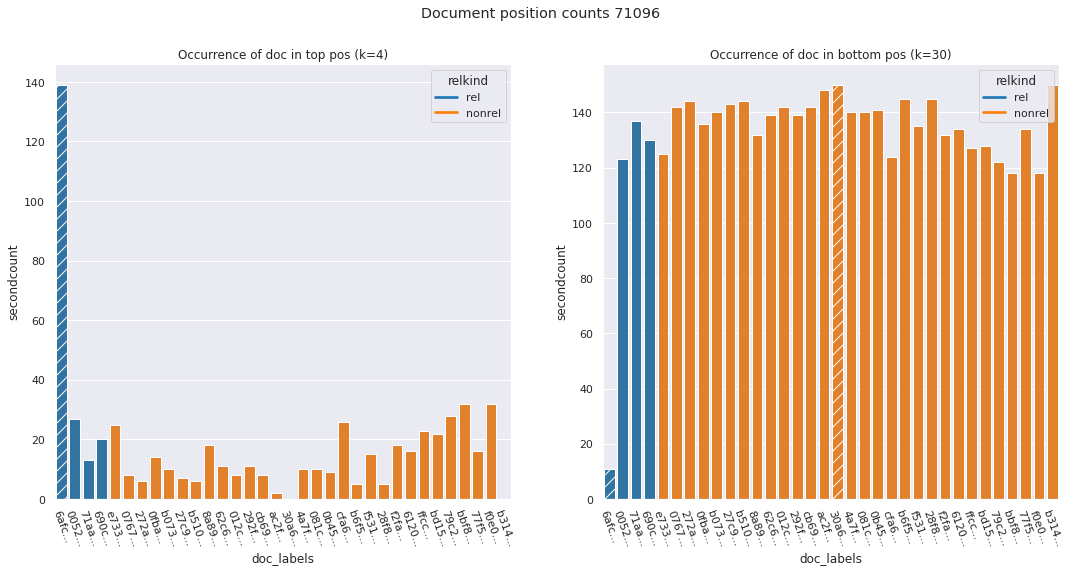

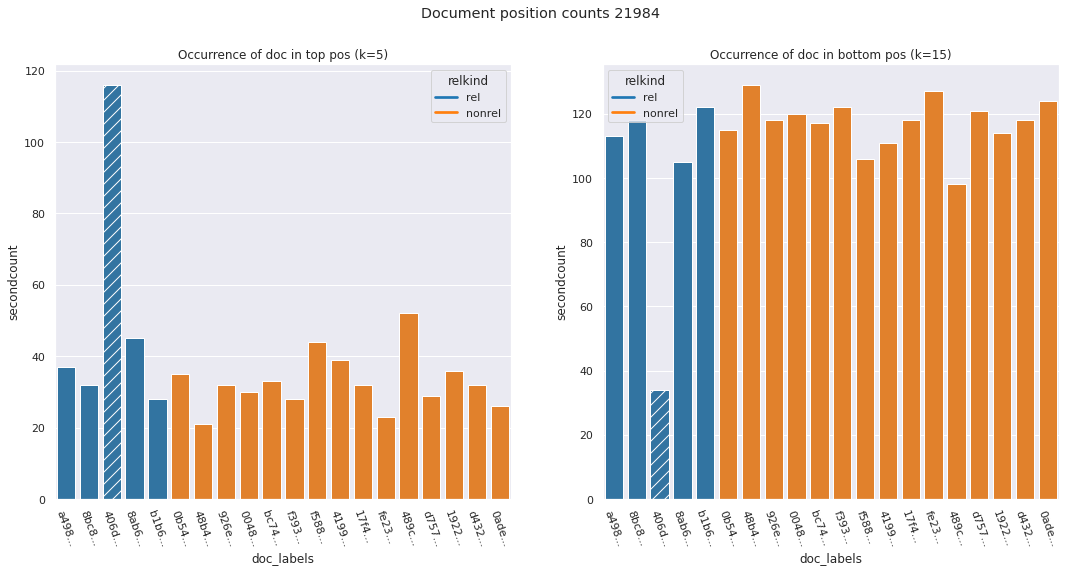

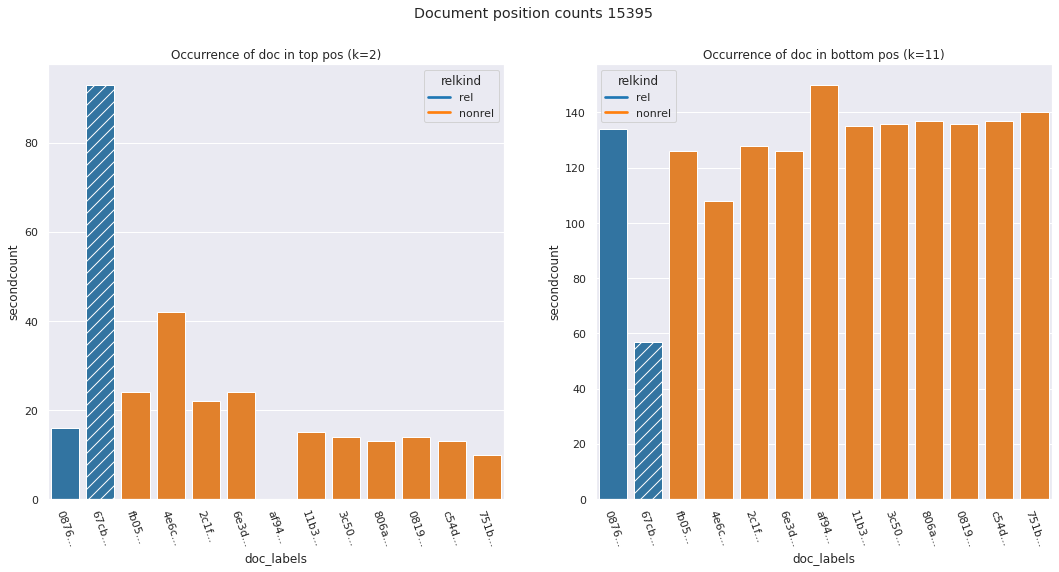

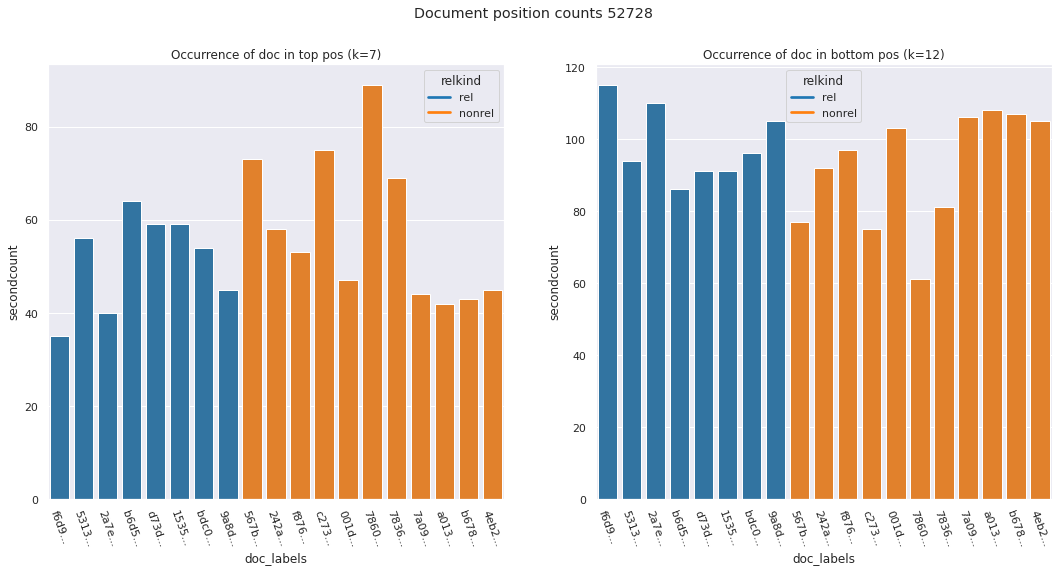

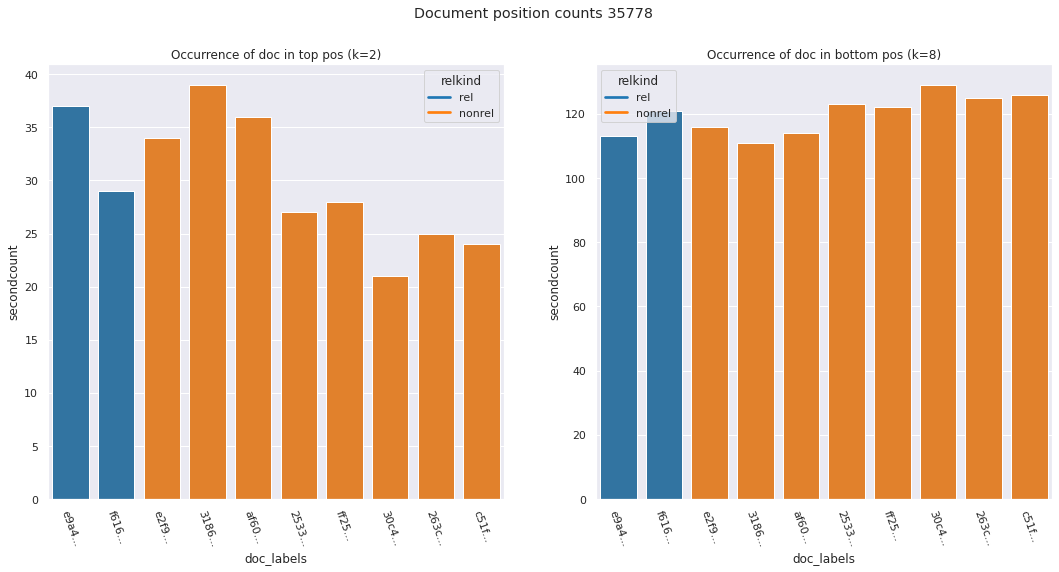

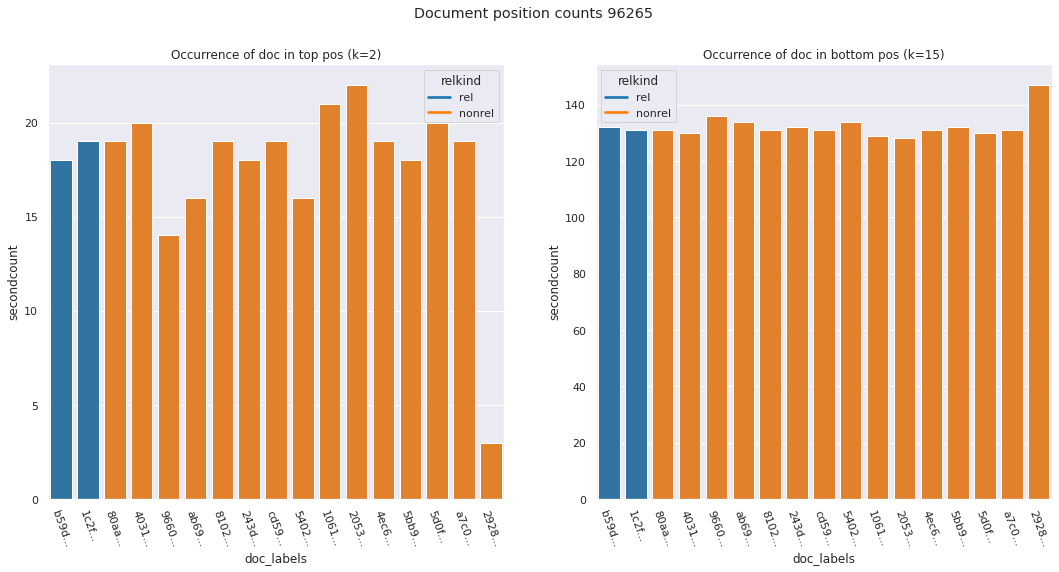

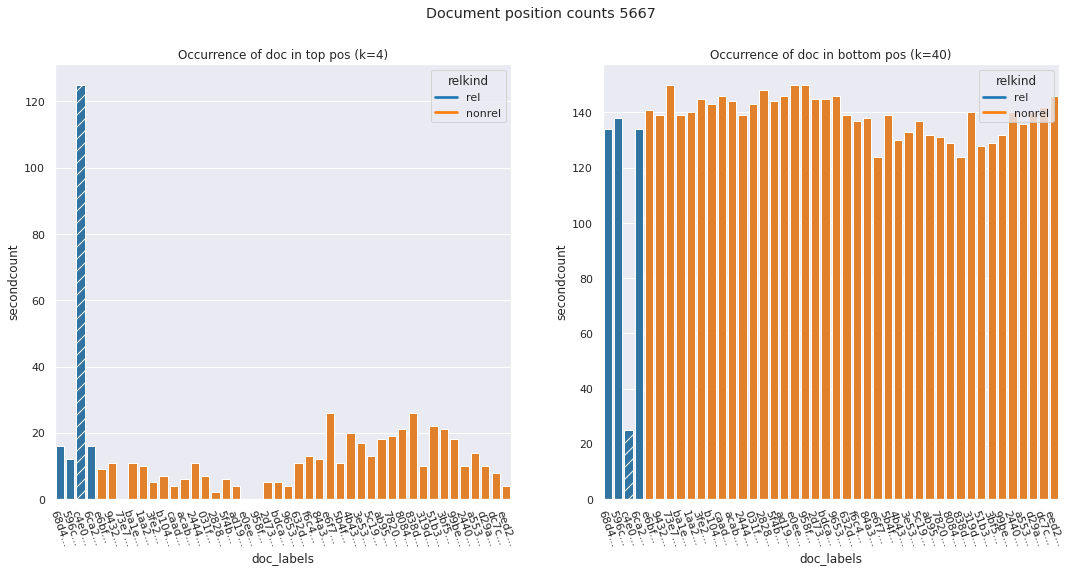

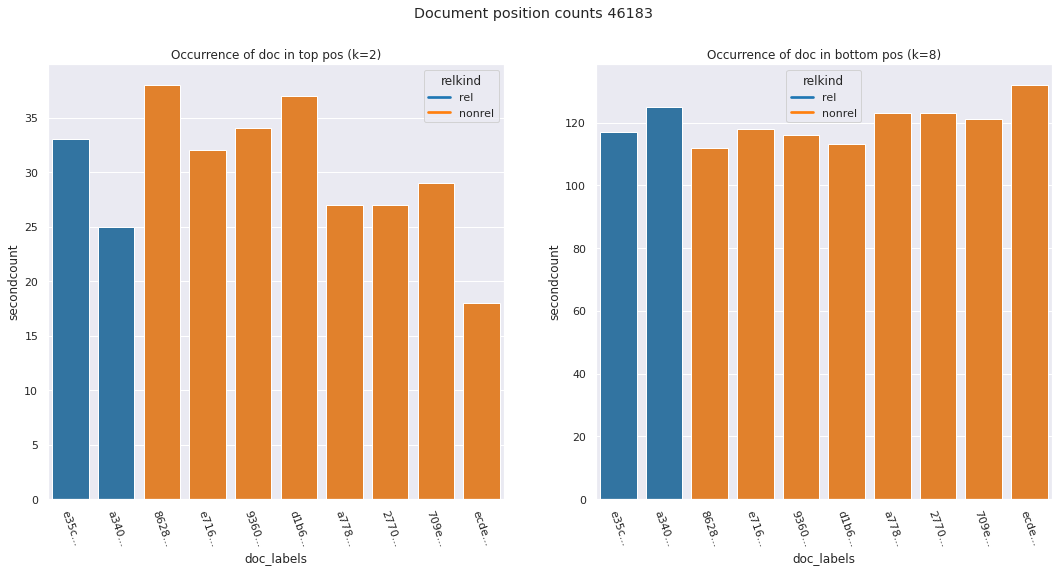

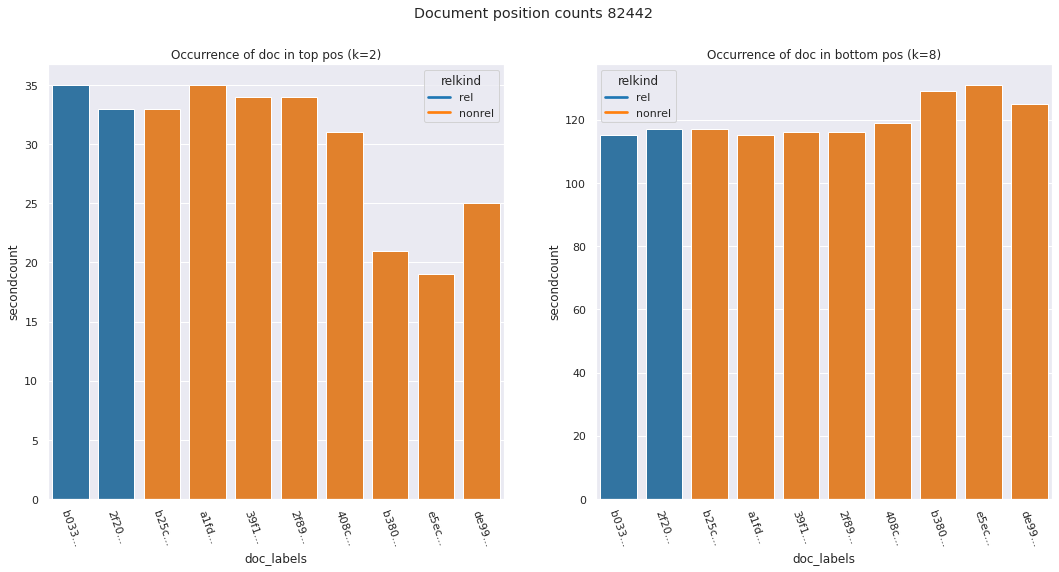

In [119]:
for q in topqueries.index.unique():
    plot_doc_pos_count_for_qid(q,rdf,reldf,noauth_ids)

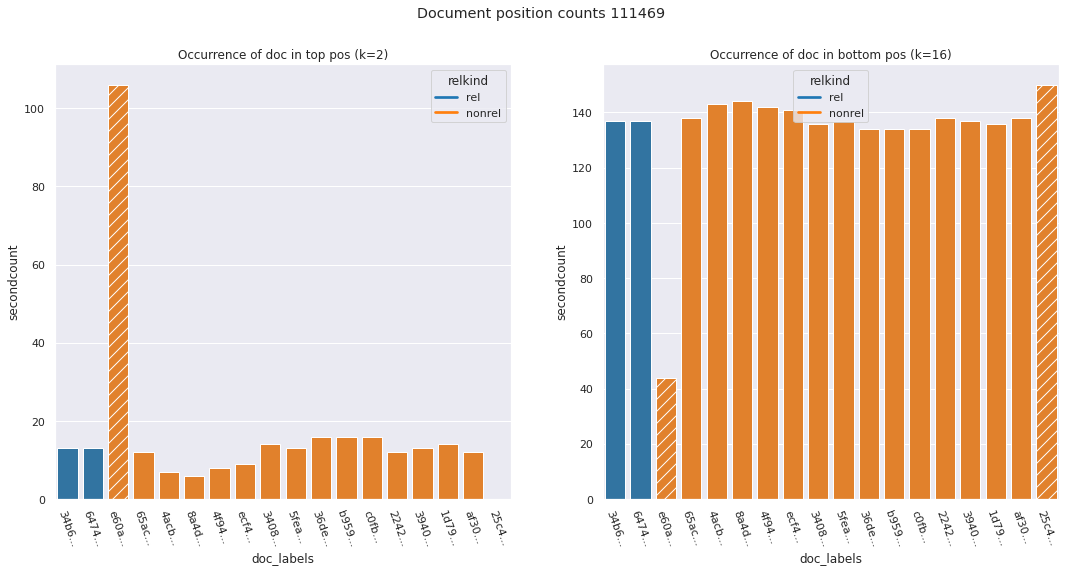

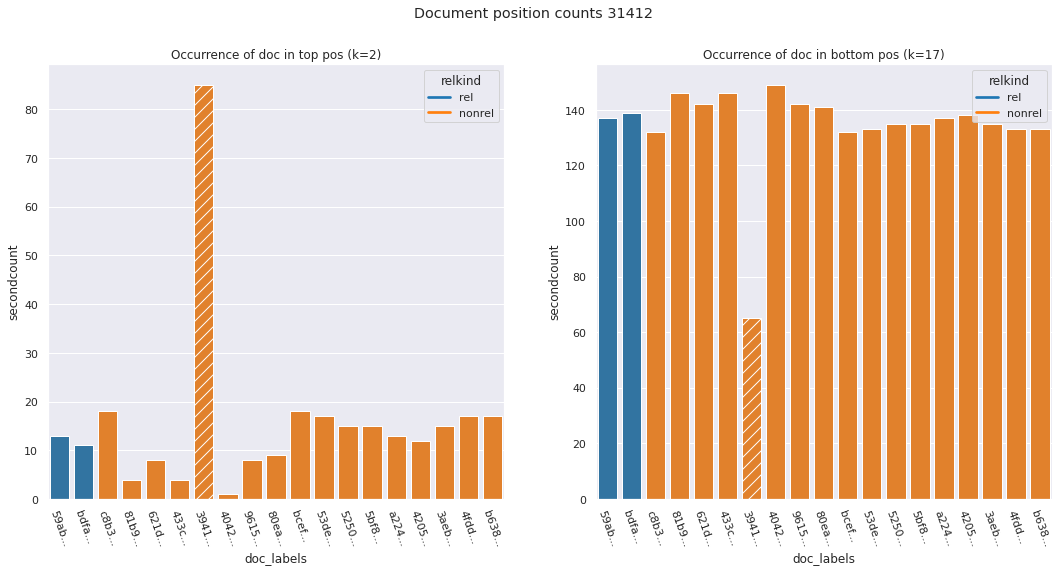

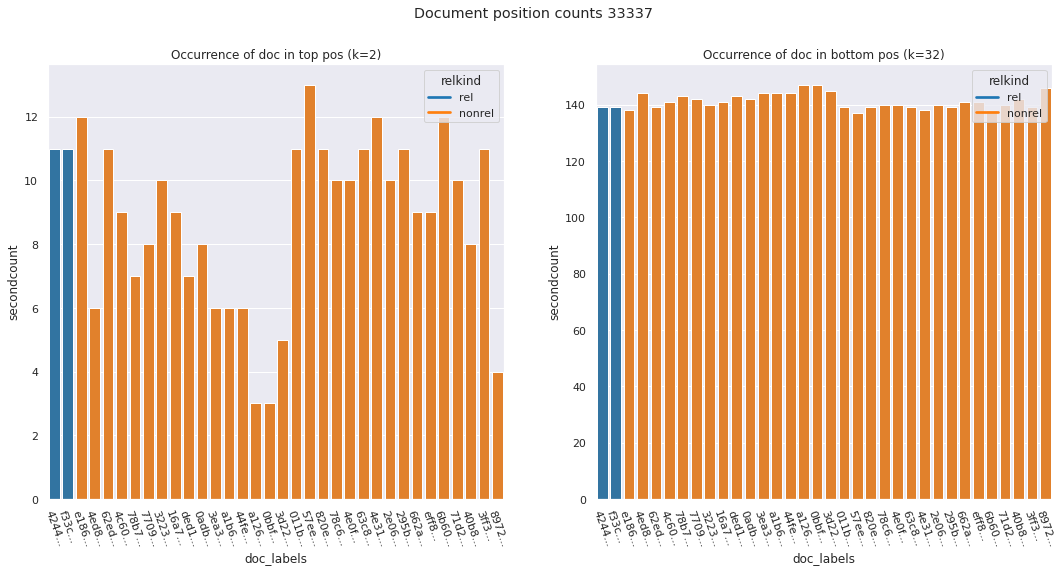

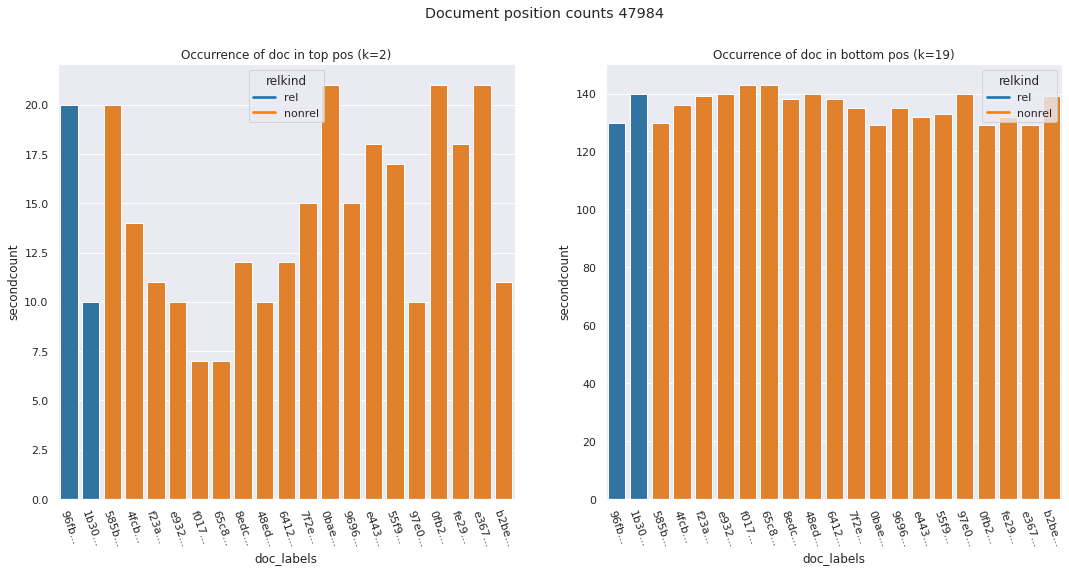

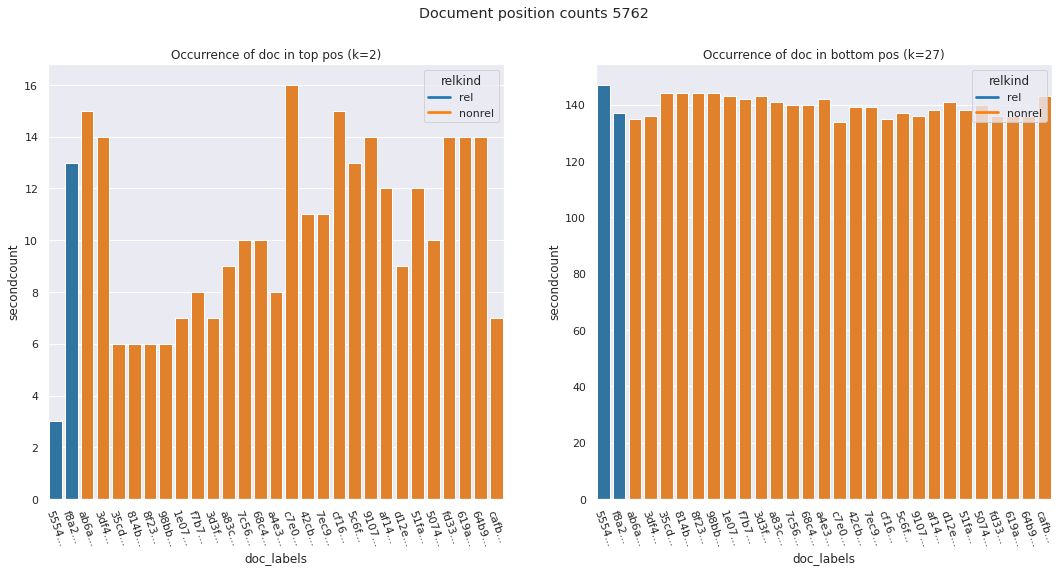

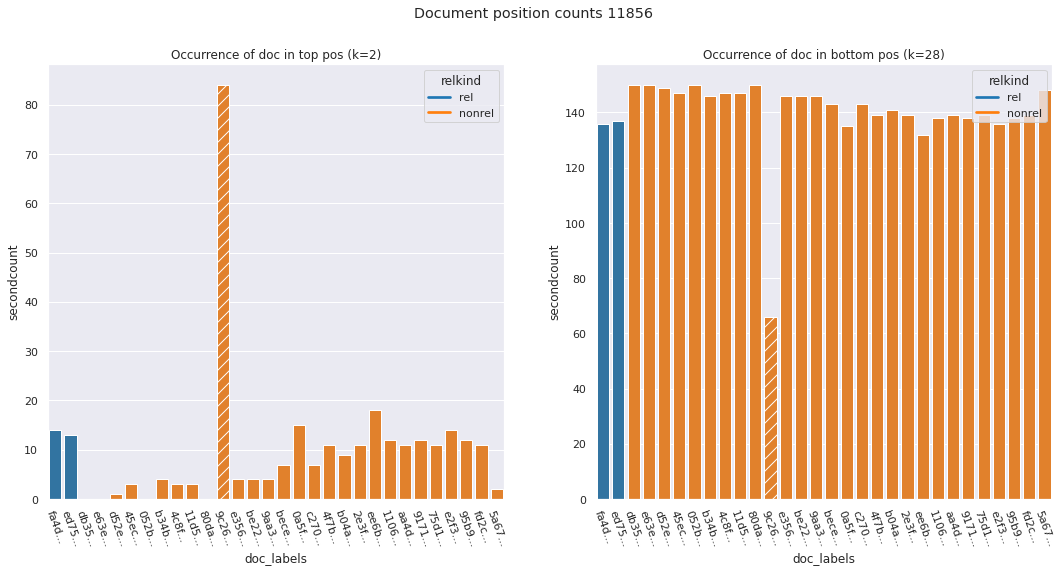

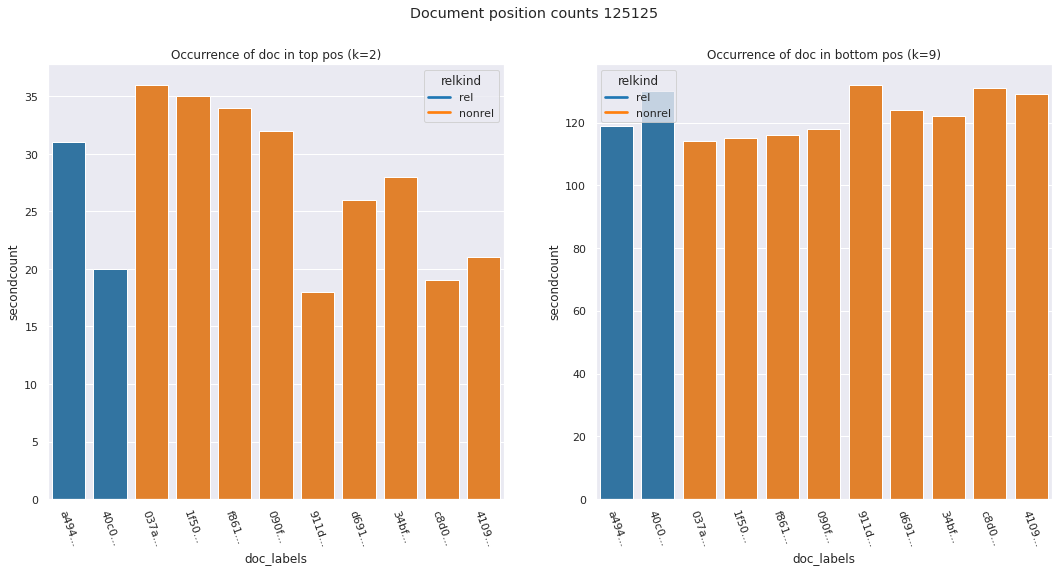

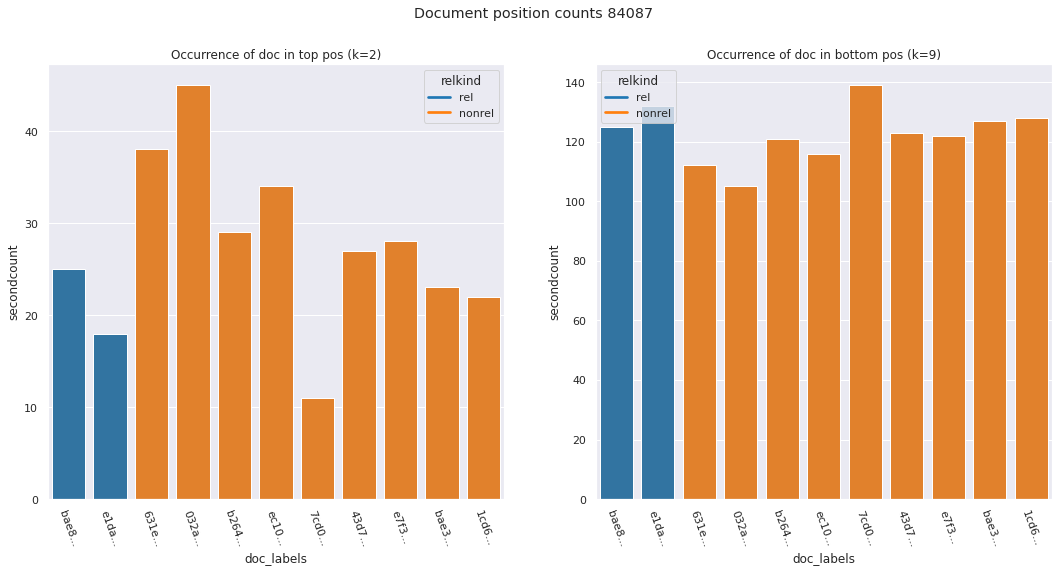

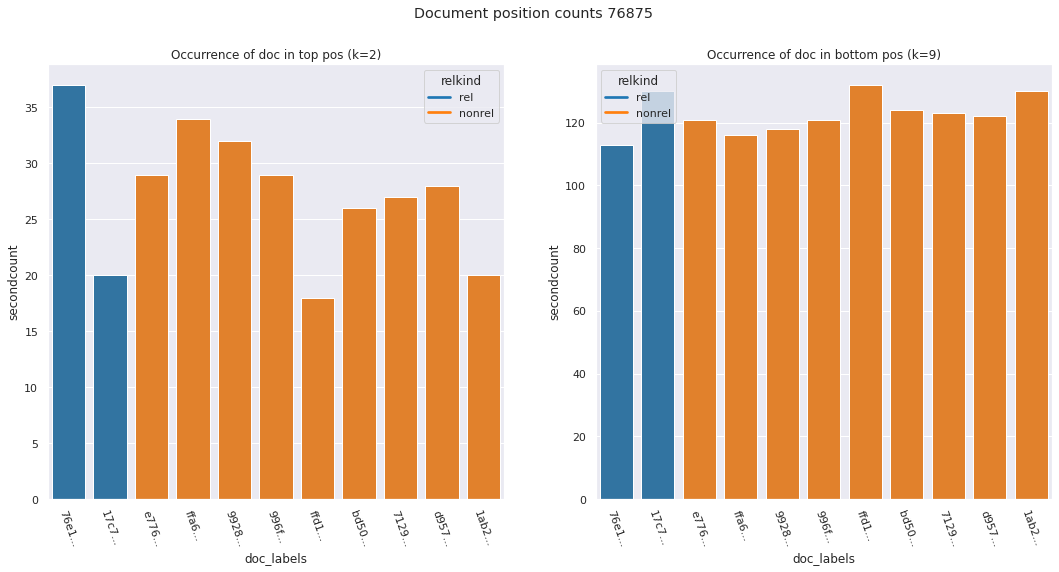

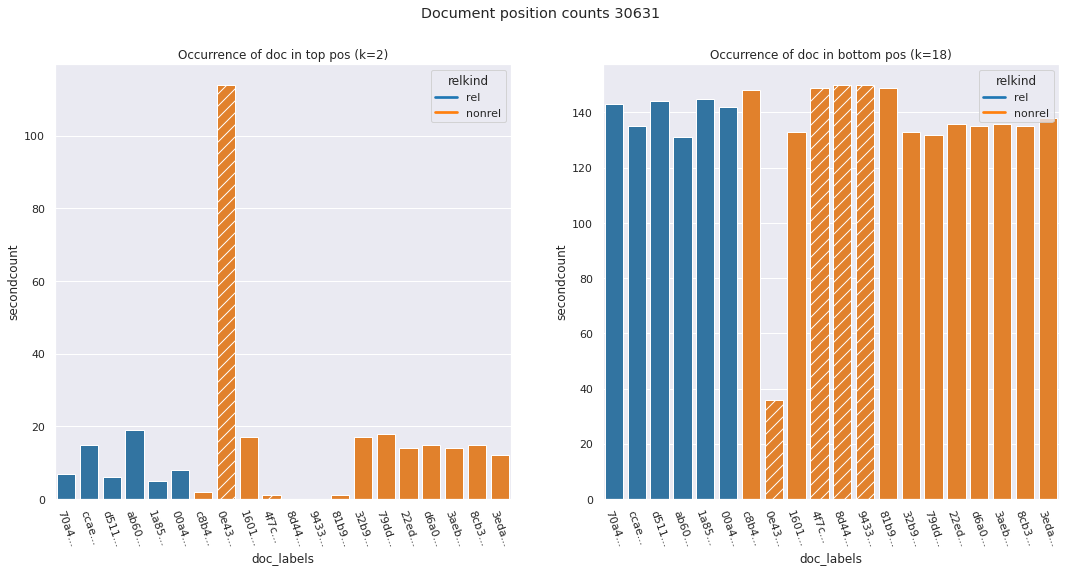

In [120]:
for q in bottomqueries.index.unique():
    plot_doc_pos_count_for_qid(q,rdf,reldf,noauth_ids)

In [142]:
author_and_estrel = pd.merge(est_rel_meta,author_info,on='doc_id')
author_and_estrel.head()

qid                                    doc_id  relevance  est_relevance  \
0  5438  3e19046c665867bbe557685da60738a40738010a          0       0.179419   
1  5438  7ef08f1fa127af817cdfd9d3bd00bdf60e32143b          0       0.145612   
2  5438  ec13c3e7119191802e6f5783d297fe7a5a05293e          0       0.210751   
3  5438  8fc928bb430d3f72ac876ca156042ad1860acacd          0       0.079591   
4  5438  b2fdee22aa02477292b858fbafcb418932732bce          1       0.260175   

   has_author  
0        True  
1        True  
2        True  
3        True  
4        True

###### qid = 30631

For query 30631 there is one authorless doc that spikes, and three that don't. These three have a lower est rel than the spiking document, but not *much* lower, aside from one. The three that spike in fact barely appear in the ranking at all...

In [149]:
inpsect_qid = 30631

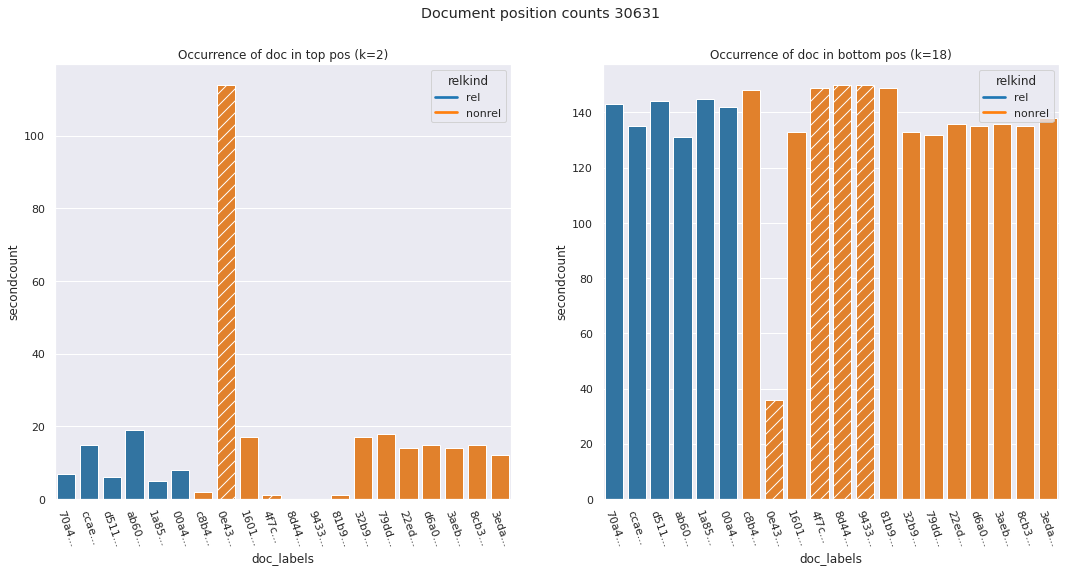

In [150]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [151]:
est_rel_meta[(est_rel_meta.qid == inpsect_qid) & (est_rel_meta.doc_id.isin(['4f7cebcc071e129d41df4766d1aed1c55e236311',
                                                                      '943320b3c05a7aeace900e28d0c6d434804363b4',
                                                                      '8d442ea1c14504e6e5676d82e78e1330c354731f',
                                                                      '0e43caeb9d476264d307e8da0ad71ecc4d804ced']))]

qid                                    doc_id  relevance  \
4467  30631  8d442ea1c14504e6e5676d82e78e1330c354731f          0   
4472  30631  0e43caeb9d476264d307e8da0ad71ecc4d804ced          0   
4480  30631  4f7cebcc071e129d41df4766d1aed1c55e236311          0   
4481  30631  943320b3c05a7aeace900e28d0c6d434804363b4          0   

      est_relevance  
4467       0.104101  
4472       0.124778  
4480       0.111590  
4481       0.069432

In [152]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

qid                                    doc_id  relevance  \
895   30631  81b95e0483d32945aad0c09849f1a9b2022d59c4          0   
1434  30631  943320b3c05a7aeace900e28d0c6d434804363b4          0   
926   30631  8d442ea1c14504e6e5676d82e78e1330c354731f          0   
4499  30631  4f7cebcc071e129d41df4766d1aed1c55e236311          0   
942   30631  0e43caeb9d476264d307e8da0ad71ecc4d804ced          0   
4497  30631  c8b45c6052cbc388de67682ac02a185fc62ba815          0   
1439  30631  00a407540a8bdd6d7425bd8a561eb21d69682511          0   
1418  30631  d511f3a98d460f7967dd490e34d664caac1529d1          0   
2666  30631  1a854bfceb615249fd9c75f3f4491b0554e59c16          0   
2656  30631  70a462ada6a79125940a46d48e430fa938054819          0   
2643  30631  ccaea944996c0935897cd6eb248d5f01367cd3c4          1   
2635  30631  3eda3b93c90dba68e1a8a50fa79d26155abd49db          0   
4498  30631  ab609df01b35223d4c1ec4d6fe84cfe349ad608b          1   
1460  30631  8cb3c7f7716217bd54a97f220f73dc07ef1220c4          0   
920   30631  3aebc8afc97439a26332526ba4c362771e332087          0   
967   30631  d6a00a2777afe09954d240b2b7bd6a6e2011e04b          0   
2638  30631  22edc9d8bb18253cdbb7905492c73387b4aee8c4          0   
2671  30631  79ddbeff892277592aa387045692e0a738ef9edf          0   
3737  30631  32b9fbe02a36c08117122e3f99421faad46876db          0   
3748  30631  1601e9f2bbf89f04f967a4f5f49d7adeca7f0719          0   

      est_relevance  has_author  
895        0.065416        True  
1434       0.069432       False  
926        0.104101       False  
4499       0.111590       False  
942        0.124778       False  
4497       0.127159        True  
1439       0.134421        True  
1418       0.137287        True  
2666       0.138070        True  
2656       0.148966        True  
2643       0.169794        True  
2635       0.174550        True  
4498       0.191062        True  
1460       0.195076        True  
920        0.196632        True  
967        0.205536        True  
2638       0.208882        True  
2671       0.219872        True  
3737       0.222271        True  
3748       0.231227        True

The four documents with no author have some of the lowest estimated relevances for this query. This may explain why some of them are ranked quite lowly. But it's still strange that one of them spikes?

For query 30631 there is one authorless doc that spikes, and three that don't. These three have a lower est rel than the spiking document, but not *much* lower, aside from one. The three that spike in fact barely appear in the ranking at all...

###### qid = 111469

In [160]:
inpsect_qid = 111469

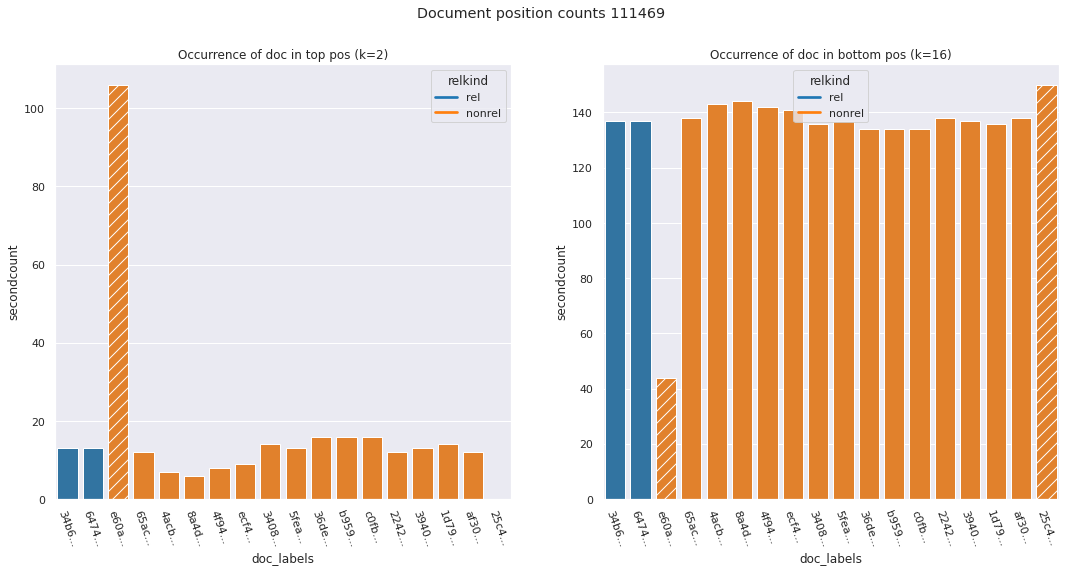

In [161]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [162]:
est_rel_meta[(est_rel_meta.qid == inpsect_qid) & (est_rel_meta.doc_id.isin(['e60af557a1bbfd9b2adee8a3c090d27faab86632',
                                                                      '25c40e796680cdea53578dfad8c7bdbae7ee56a5']))]

qid                                    doc_id  relevance  \
1283  111469  25c40e796680cdea53578dfad8c7bdbae7ee56a5          0   
1291  111469  e60af557a1bbfd9b2adee8a3c090d27faab86632          0   

      est_relevance  
1283       0.060952  
1291       0.213855

In [163]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

qid                                    doc_id  relevance  \
1354  111469  25c40e796680cdea53578dfad8c7bdbae7ee56a5          0   
1367  111469  4acbb705dd58fca58d05194c845cda461f6462c7          0   
1365  111469  8a4dd47751709b4e13f611d098a0c6ec10ee3901          0   
1358  111469  4f940b31db19edda00bca85293093c779fa4dd5c          0   
1356  111469  ecf4c446122e770ca0d9031b9b8bdf7d6d40dc9b          0   
1291  111469  647444c4963ddac18626a4d2817eb85e438405c0          1   
1370  111469  340805c6c2806a6aa15c2a0646b2285ddd456375          0   
1364  111469  65acaa6938f34c08b517f49caf5cc82c872ec72f          0   
1369  111469  5fea3a4e2d25d5ad0872d35704d2cbdf210639d9          0   
1363  111469  b9590939f89108838f7499676bb2a58de93c365f          0   
1362  111469  c0fb289dbcbf888bc8ff96661bfcbda519625fac          0   
1357  111469  224289edb5ee14bbe960c061a58bd38adbf4f9d9          0   
1360  111469  34b6de1aee17441021e62b63c543abc1c28b0928          1   
1359  111469  3940e507cdf316b80e42504df02969e5449c925f          0   
1366  111469  1d798b9220e6660931efa4f703592875a081dab0          0   
1368  111469  af30c3a83f5c203f207a8865dd93c1cc3c13e186          0   
1355  111469  36dedcbd7ad1a9313b967e8e3b0dc0fa3df4f9ac          0   
1361  111469  e60af557a1bbfd9b2adee8a3c090d27faab86632          0   

      est_relevance  has_author  
1354       0.060952       False  
1367       0.072484        True  
1365       0.076282        True  
1358       0.097344        True  
1356       0.097716        True  
1291       0.161621        True  
1370       0.177313        True  
1364       0.180595        True  
1369       0.187043        True  
1363       0.188831        True  
1362       0.190169        True  
1357       0.190947        True  
1360       0.193041        True  
1359       0.193124        True  
1366       0.194720        True  
1368       0.198701        True  
1355       0.212803        True  
1361       0.213855       False

The documents without authors for this query have the highest and the lowest relevance. This is reflected in how often they appear in the top of the ranking.

###### qid = 71096

In [164]:
inpsect_qid = 71096

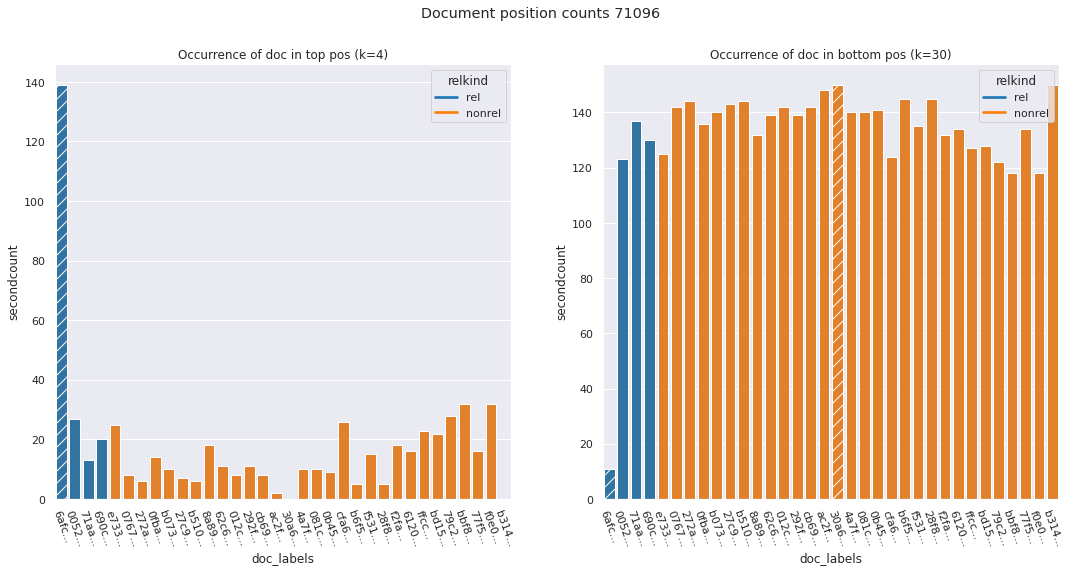

In [165]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [166]:
est_rel_meta[(est_rel_meta.qid == inpsect_qid) & (est_rel_meta.doc_id.isin(['6afc97668839a439e6858691ada76c9ddf798c2a',
                                                                      '30a698ba5648295c91f00545326931eaf07b00be']))]

qid                                    doc_id  relevance  est_relevance
432  71096  6afc97668839a439e6858691ada76c9ddf798c2a          1       0.218468
448  71096  30a698ba5648295c91f00545326931eaf07b00be          0       0.069391

In [167]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

qid                                    doc_id  relevance  \
450  71096  b3146d2601f32d068162d2eb954ed864859bb1cd          0   
457  71096  30a698ba5648295c91f00545326931eaf07b00be          0   
464  71096  ac2f1bf955e79c2522573fb8f508637a9cb272bf          0   
448  71096  cb6940faebc08e4e03c4cfd3adffa567c0946fb2          0   
461  71096  292f1c65fb0a3995411f516e3dc501e44a3fed07          0   
445  71096  012c336ff0a7229cd2c4809f26d9a85e15882bbc          0   
456  71096  b51099d190c827fdfed93b7a459d0808d38ccddb          0   
467  71096  8a892b91e318de54b25809000e818a5efc23d696          0   
437  71096  0767627edb30ac03c910afea561ecc226d4de87a          0   
449  71096  27c92ca493b24d253ef0ad1a3f8c72452f30b3ee          0   
454  71096  b073e7408a61b27b98695fed56a6314ff3c39080          0   
458  71096  0fba5df34788101903ce38e06027a23555930e66          0   
466  71096  272ae776f70a6ec78945df97f531264087bf0671          0   
453  71096  4a7fc7cb313b9dc084b17e55e4ab656ffa7fc207          0   
455  71096  62c6eccbf40ffba2d010338f2ccea052e67073fa          0   
444  71096  0b457b1c08dffeaf58550923f8983f7bb42cdb38          0   
442  71096  081c863807d3ab451ddeca66ff622f91fdb67873          0   
447  71096  b6f5dd516d6904579bd8bffc83bc2288b415f254          0   
459  71096  f531d536b75d82e33f74b3445e0ddbf96065fafe          0   
440  71096  71aa55b1a189ec609ee865df4453ebb538c3ee0e          1   
446  71096  28f84cc73c9aab9b3cbef40454546412d28a13b2          0   
451  71096  690ca77ec86c43e568e26494d7ddf263d3371ad9          1   
436  71096  f2fa1e494afdcd8feed05b098988c9de770a9f5c          0   
435  71096  612024262f5605f8acc3731fbacd0a9580f31383          0   
439  71096  ffccdae350cc206d3ae0012de73d8ee74fb59df1          0   
462  71096  bd15b65ce7b716cbdaaeee63d0f5a7e75300774d          0   
460  71096  79c270ab702bdb568b42044c5516eb702c0c9854          0   
463  71096  00525dd393d8a3a72e584eda8328ace8d43f3c0e          1   
452  71096  bbf84c2e04321f3f5813cdc91978a186727bbe05          0   
441  71096  6afc97668839a439e6858691ada76c9ddf798c2a          1   
465  71096  77f576dd5df8bf19facce8edd20acf1d9a3fc75f          0   
443  71096  f0e04751c7d1c30d344eb1d41b3a86fbbef5ca7a          0   
468  71096  cfa64338705a4903b3d38ae98901dc21183bf86c          0   
438  71096  e733c8eac41129ceaed9eadf06108119a3752894          0   

     est_relevance  has_author  
450       0.029874        True  
457       0.069391       False  
464       0.095152        True  
448       0.095528        True  
461       0.098981        True  
445       0.100853        True  
456       0.105284        True  
467       0.116082        True  
437       0.120897        True  
449       0.128345        True  
454       0.143299        True  
458       0.144374        True  
466       0.144693        True  
453       0.147490        True  
455       0.156674        True  
444       0.157417        True  
442       0.158945        True  
447       0.164392        True  
459       0.164941        True  
440       0.169386        True  
446       0.174763        True  
451       0.176058        True  
436       0.182185        True  
435       0.182381        True  
439       0.183386        True  
462       0.186111        True  
460       0.193512        True  
463       0.209185        True  
452       0.214495        True  
441       0.218468       False  
465       0.220324        True  
443       0.224066        True  
468       0.224708        True  
438       0.255103        True

The documents without authors for this query have the highest and the lowest relevance. This is reflected in how often they appear in the top of the ranking.

###### qid = 96265

In [168]:
inpsect_qid = 96265

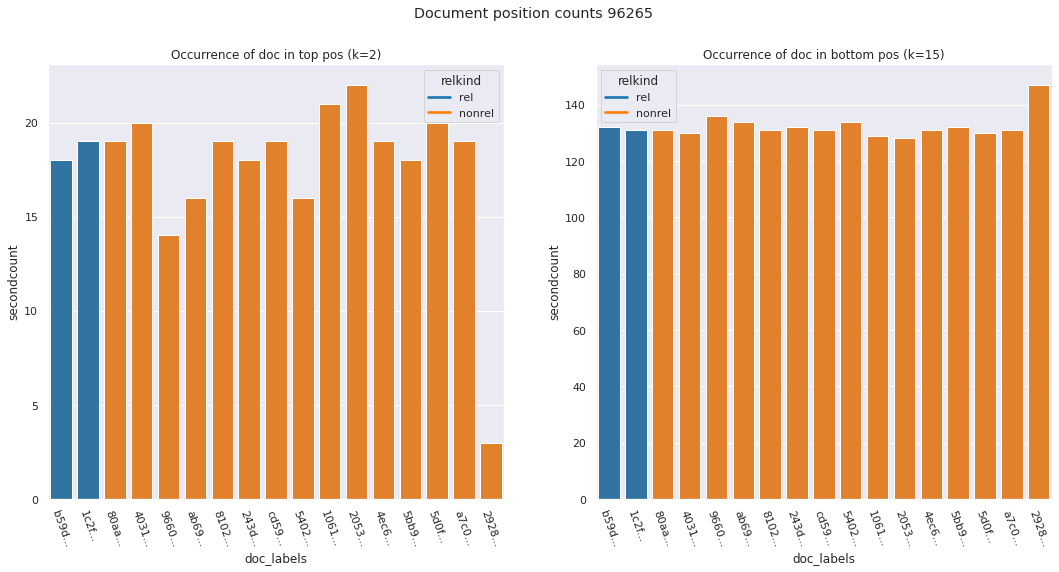

In [169]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [170]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

qid                                    doc_id  relevance  \
1633  96265  2928bf2cdc03ee57010e14ff97b736614c225c2d          0   
1635  96265  9660c75834ceab591fcc9d357f623c80c39ba8be          0   
1628  96265  ab690da13c9fc04d166471f2e404263b26998e48          0   
1638  96265  81020c906a2977540b20ee3abdffb136ea9ef64f          0   
1637  96265  243d068c29515718dc85c3a6ec5ca00b9b45544d          0   
1639  96265  cd59691aaddb039725107343c2d9d76312bedbec          0   
1629  96265  403136735248d730419f89e3a329b08de98bc0ea          0   
1643  96265  1061d0262c0995d1473c666b624ae64690b6c427          0   
1634  96265  5402520e51e900ab16c624496281bdc3b17fc1fa          0   
1636  96265  4ec6d61f0ceedd0c0b2e9f5d9ac0e7c258c6bfe7          0   
1630  96265  5bb9fc3bb7a9cd2a76e915f6d57cd4921c2c2526          0   
1642  96265  5d0f407f109ac10dfffff0f70ec73789051bcfcc          0   
1627  96265  1c2fc3db949b0ec866ba6a636182860754def193          1   
1640  96265  a7c0a13135c7b706c86b0a8b44b1d1fd995daab5          0   
1631  96265  b59dcbab074348294b934346268b65ce49385f78          1   
1641  96265  2053d9e5eed846080dbd531b94daf0628b2125d3          0   
1632  96265  80aaca60be00c5d1b220f94716aba41eb45532b3          0   

      est_relevance  has_author  
1633       0.007426        True  
1635       0.144327        True  
1628       0.164385        True  
1638       0.165949        True  
1637       0.167281        True  
1639       0.168203        True  
1629       0.168249        True  
1643       0.168793        True  
1634       0.169643        True  
1636       0.172527        True  
1630       0.173501        True  
1642       0.175319        True  
1627       0.175732        True  
1640       0.178028        True  
1631       0.178142        True  
1641       0.204500        True  
1632       0.208122        True

The documents without authors for this query have the highest and the lowest relevance. This is reflected in how often they appear in the top of the ranking.

###### qid = 15898

In [191]:
inpsect_qid = 15395

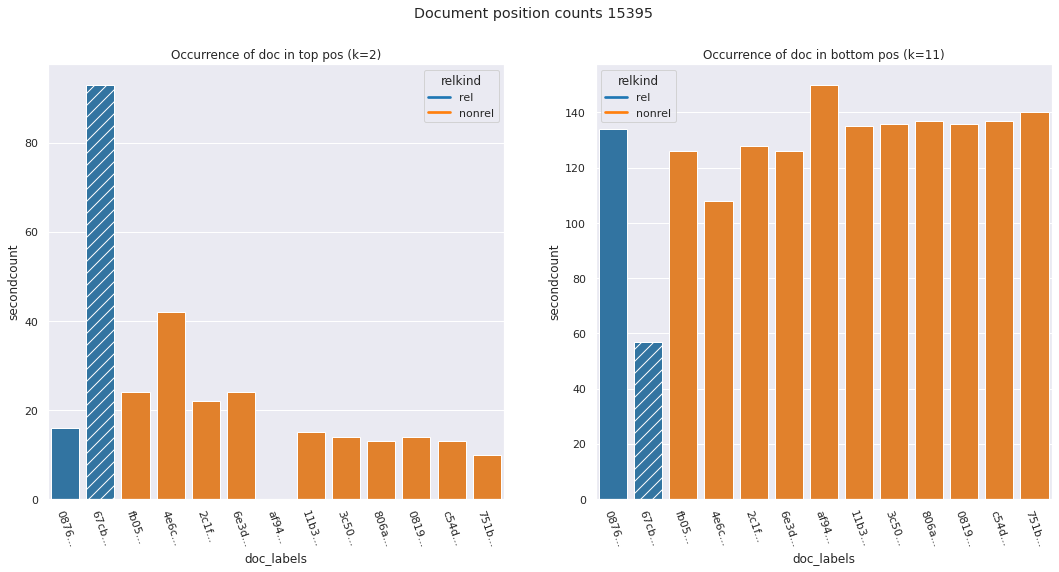

In [192]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [193]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

qid                                    doc_id  relevance  \
1176  15395  67cb7ec0f36f9396b85b18cad90c0d7eec1658ce          1   
1180  15395  751b1a631daaabbd0e9376b40005c07ca07a5b29          0   
1181  15395  c54d65d53d7ada275d34e1a7c53643ff0c82eb93          0   
1187  15395  08196a4be3e863dd152b3f71aa25e7aeabb6faec          0   
1175  15395  806a330219f49b6e7952e79444477ef512501650          0   
1177  15395  3c50b229b9a59de264df893f6444d515f2546ca1          0   
1179  15395  11b35902e5de5d96046b2db4670e756f1e3a1a3e          0   
1185  15395  08761cfc723bc5dafd6e18203aff6392ae46bd2b          1   
1183  15395  af94eb52e8f7a52b1800414646ab729f34da9191          0   
1184  15395  6e3d8390a0129602e4680baeb9a87ff2b89b7db4          0   
1178  15395  2c1fcc403442c999dc78978447099daad73d596b          0   
1182  15395  4e6c4288338eba5644ead3847e11cd50bdee973d          0   
1186  15395  fb052c2c638cc2c682b0fc6e36da0582e51e4e11          0   

      est_relevance  has_author  
1176       0.070658       False  
1180       0.086387        True  
1181       0.124888        True  
1187       0.127366        True  
1175       0.131350        True  
1177       0.136192        True  
1179       0.139865        True  
1185       0.165807        True  
1183       0.177854        True  
1184       0.180306        True  
1178       0.185516        True  
1182       0.242943        True  
1186       0.246063        True

Document af94eb52e8f7a52b1800414646ab729f34da9191 has a reasonably high estimated relevance but nevertheless never occurs in a top position.

**Hypothesis**: Is this because it has multiple authors? And thus is doubly penalized?
--> no

In [214]:
adf[adf['id'] == 'af94eb52e8f7a52b1800414646ab729f34da9191']

id  missing_authors  \
577  af94eb52e8f7a52b1800414646ab729f34da9191            False   

                                               authors          name  \
577  {'name': 'Yusuf Chisti', 'wiki': 'Massey Unive...  Yusuf Chisti   

                  wiki country      type  valid    auth_id  h_index     level  \
577  Massey University      NZ  academic   True  5776192.0     44.0  Advanced   

      region  
577  Oceania

In [215]:
pd.merge(author_and_estrel[author_and_estrel.qid == inpsect_qid],adf.rename({'id':'doc_id'},axis=1),on='doc_id',how='left')

qid                                    doc_id  relevance  est_relevance  \
0   15395  806a330219f49b6e7952e79444477ef512501650          0       0.131350   
1   15395  67cb7ec0f36f9396b85b18cad90c0d7eec1658ce          1       0.070658   
2   15395  3c50b229b9a59de264df893f6444d515f2546ca1          0       0.136192   
3   15395  3c50b229b9a59de264df893f6444d515f2546ca1          0       0.136192   
4   15395  3c50b229b9a59de264df893f6444d515f2546ca1          0       0.136192   
5   15395  3c50b229b9a59de264df893f6444d515f2546ca1          0       0.136192   
6   15395  3c50b229b9a59de264df893f6444d515f2546ca1          0       0.136192   
7   15395  2c1fcc403442c999dc78978447099daad73d596b          0       0.185516   
8   15395  11b35902e5de5d96046b2db4670e756f1e3a1a3e          0       0.139865   
9   15395  751b1a631daaabbd0e9376b40005c07ca07a5b29          0       0.086387   
10  15395  c54d65d53d7ada275d34e1a7c53643ff0c82eb93          0       0.124888   
11  15395  4e6c4288338eba5644ead3847e11cd50bdee973d          0       0.242943   
12  15395  af94eb52e8f7a52b1800414646ab729f34da9191          0       0.177854   
13  15395  6e3d8390a0129602e4680baeb9a87ff2b89b7db4          0       0.180306   
14  15395  6e3d8390a0129602e4680baeb9a87ff2b89b7db4          0       0.180306   
15  15395  6e3d8390a0129602e4680baeb9a87ff2b89b7db4          0       0.180306   
16  15395  6e3d8390a0129602e4680baeb9a87ff2b89b7db4          0       0.180306   
17  15395  6e3d8390a0129602e4680baeb9a87ff2b89b7db4          0       0.180306   
18  15395  08761cfc723bc5dafd6e18203aff6392ae46bd2b          1       0.165807   
19  15395  fb052c2c638cc2c682b0fc6e36da0582e51e4e11          0       0.246063   
20  15395  08196a4be3e863dd152b3f71aa25e7aeabb6faec          0       0.127366   

    has_author missing_authors  \
0         True             NaN   
1        False             NaN   
2         True           False   
3         True           False   
4         True           False   
5         True           False   
6         True           False   
7         True             NaN   
8         True             NaN   
9         True             NaN   
10        True           False   
11        True             NaN   
12        True           False   
13        True           False   
14        True           False   
15        True           False   
16        True           False   
17        True           False   
18        True             NaN   
19        True             NaN   
20        True             NaN   

                                              authors                   name  \
0                                                 NaN                    NaN   
1                                                 NaN                    NaN   
2   {'name': 'Jason D Hill', 'wiki': 'University o...           Jason D Hill   
3   {'name': 'Erik O. Nelson', 'wiki': 'University...         Erik O. Nelson   
4   {'name': 'David Tilman', 'wiki': 'University o...           David Tilman   
5   {'name': 'Stephen Polasky', 'wiki': 'Universit...        Stephen Polasky   
6   {'name': 'Douglas G. Tiffany', 'wiki': 'Univer...     Douglas G. Tiffany   
7                                                 NaN                    NaN   
8                                                 NaN                    NaN   
9                                                 NaN                    NaN   
10  {'name': 'Avinash Kumar Agarwal', 'wiki': 'Ind...  Avinash Kumar Agarwal   
11                                                NaN                    NaN   
12  {'name': 'Yusuf Chisti', 'wiki': 'Massey Unive...           Yusuf Chisti   
13  {'name': 'Guanhua Huang', 'wiki': 'China Unive...          Guanhua Huang   
14  {'name': 'Feng Chen', 'wiki': 'University of H...              Feng Chen   
15  {'name': 'Dong Qing Wei', 'wiki': 'South China...          Dong Qing Wei   
16  {'name': 'Xuewu Zhang', 'wiki': 'South China U...            Xuewu Zhang   
17  {'name': 'Gu Chen', 'wiki': 'S

Some documents have author in the index but not in the merged annotations file? Has influence on the grouping?


In [122]:
noauth_ids

['c4e04c3ad7e58d45d2cfb686f2106b6a6beedff2',
 '332fc6195f1396ad679f8eb9a2bed71aac9e7420',
 '8d442ea1c14504e6e5676d82e78e1330c354731f',
 '17dc9f600d774888aa379aa5574144d5f2a7e3b9',
 '2715db84533cc17ca0d9cc2dce34deca5c15e15f',
 'f16f2aae49f330b9c0f885bf2eb5b4f8a9df00b7',
 '3dc0ee51efd0e893fabb189c23ffd2b4a09ca70d',
 '74bdf73f81b4ceecc9cf216558528e3c7a32cc05',
 '9cea62e2cef93c580b8c82e900241e771f3b914e',
 '9ae8ce5d9ed80df06663f16d7118eaff55c82aeb',
 'a15b28c5b9e2d3842fdb9893be668bc51d63dfbe',
 'cd82bcecd130b6dbef52cf3c16ebb6607c63f9d2',
 'e60af557a1bbfd9b2adee8a3c090d27faab86632',
 '4313bf44960b5b726028b55e76f1c9f99334e347',
 'a774aa22cc1e8bcf9929d3acac63c660c28eab05',
 '3a0130cfab8192a397d79fc1c7c398470157cf48',
 '4c2d8626326664859db2a0500f70d6de736f5bfe',
 '30a698ba5648295c91f00545326931eaf07b00be',
 '86c0337f18d3097836f7348656c6492715c4319d',
 'a6361a0ce9579d5659cad164c7d855c396e227f1',
 '13faea280933c0832cbc3b5b20be796e41f23ca8',
 '1ef0ad9c9382693fd39d8cfbc25aab7929d89abe',
 '0da7a3f0

Some remarks: 
- Many of the bottom queries indeed have a non-relevant no-author item in a top position, and no relevant no-author items.
- Out of the top queries, two have a relevant no-author item in a top position, and no non-relevant no-author items.

    
- there are still numerous rankings with (top?) documents missing from the ranking, why is that?

## Hypothesis: bottom queries have many items without author
- Because they aren't in the index
- Because they are in the index but don't have an author

1. Find all items in the index that do not have an author
2. Find all items that have an estimated relevance but aren't in the index
3. Check how many of the above items occur in the top and the bottom rankings

In [112]:
eval_ids = list(reldf.doc_id.unique())
eval_ids[:10]
len(eval_ids)

4693

In [113]:
est_rel_meta = '../reranking/resources/relevances/Evaluation_rel_scores_model_A.csv'
est_rel_meta = pd.read_csv(est_rel_meta)
est_rel_meta.head()

qid                                    doc_id  est_relevance
0  9087  40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4       0.131015
1  9087  008a2a2c765485af2e035a2572ba9fc1102eabff       0.208199
2  9087  4a1472c575488ed9acee6c5481f68b95a0c34092       0.129001
3  9087  ff8df0745136fb183ea72b783ff38f8a7ad5ceec       0.179983
4  9087  90605deb1da5e3d5548da12dc130fc0341a6a255       0.157544

In [114]:
est_rel_ids = list(est_rel_meta.doc_id.unique())
est_rel_ids[:10]
len(est_rel_ids)

4684

In [115]:
all_ids = list(set(eval_ids).union(set(est_rel_ids)))
len(all_ids)

4693

As established earlier in the research process, there are 9 items in the evaluation sample that do not have an estimated relevance.

In [116]:
no_author = find_docs_without_author(reldf)

Out of the items in the sample file, 4605 are also in the index.

26 items have no author in the index

In [117]:
topmerge = pd.merge(top[['qid']],reldf[['qid','query','doc_id']],on='qid')
topmerge['has_author'] = topmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
topmerge.head(10)

qid query                                    doc_id  has_author
0  91643  nazi  6fa92e5b2f8d8912026e4e7e6c9a858528499966        True
1  91643  nazi  cdf1901567491b6ad5ecde7042895ec06e99e2b2        True
2  91643  nazi  b2f24606271b959806061c64f81130e5ad75d410        True
3  91643  nazi  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        True
4  91643  nazi  4bbb91eb0fea54bd85774931e299efaaaa1b038f        True
5  91643  nazi  fb1a4e990af505ebef7c643c9231645695d9ce31        True
6  91643  nazi  f520d727e7e76253c1d77f26c573474437858593        True
7  91643  nazi  e38a47e6a3e62abf46804dc77b6e1c1deb3eb9e8        True
8  91643  nazi  17dafc3f0318b8711ca4f07783ef428568abb64b        True
9  91643  nazi  8954067bccf3f36cfb46f22c40df207028ecb63a        True

In [118]:
botmerge = pd.merge(bot[['qid']],reldf[['qid','query','doc_id']],on='qid')
botmerge['has_author'] = botmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
botmerge.head(10)

qid query                                    doc_id  has_author
0  657  iran  a1b0feb1f82716b0e343453ca214912cfd3ea0e5        True
1  657  iran  b59004dc46558189fa4d846029ccb1ce3f079484        True
2  657  iran  17475d93c5d0b5b6396aa1d3a3928d6154b65695        True
3  657  iran  1436449e0234166b13135df45be1f072df059007        True
4  657  iran  18f883bd5b9ab9771e561a0214af6bd5ddda0d61        True
5  657  iran  a8b58f310e13c171ce7b7890d23860836cbc4534        True
6  657  iran  2aa5e431cd45476cc0432722dfa003a641790830       False
7  657  iran  cb547f0c206fafff203c66a169816f03360cfc89        True
8  657  iran  1a8800cdf999a01022f1db8e5c4c61306d3e43cc        True
9  657  iran  48086bd4f74a8d2aa8a51d1b1406fbd0cad67f25        True

In [119]:
topmerge[(topmerge.has_author == False)]

qid                            query  \
62    21237                 visual landscape   
170   43723                fordyce　sebaceous   
189   43723                fordyce　sebaceous   
205    9663                      covid-19 ai   
213    9663                      covid-19 ai   
...     ...                              ...   
3329  14432                        thai mooc   
3427  34981                         homework   
3446  34981                         homework   
3459   6657  corporate social responsibility   
3473   6657  corporate social responsibility   

                                        doc_id  has_author  
62    ad5cf96ee7450784e2be79f786c5e54135df6519       False  
170   5778770d9169b220e1d2c7c18d6a7a80808481af       False  
189   f147f0511186715fb2fac0bec242eb30ff720e6b       False  
205   4313bf44960b5b726028b55e76f1c9f99334e347       False  
213   2801d473e9c29b3de614030be102fa7245806d00       False  
...                                        ...         ...  
3329  7d329b21731b8d1faaaabc0a237cfb0451539595       False  
3427  2c88b97376f69041f4e3cab0afac7920976e3278       False  
3446  273a5d30ae0083c24df5482240db377e437871ba       False  
3459  d15000938c8b8af5a07a2446a4e58615df844d71       False  
3473  eaf3420b867a79184ea3a4fe599be37e6a5cccfe       False  

[96 rows x 4 columns]

In [120]:
botmerge[(botmerge.has_author == False)]

qid                                     query  \
6        657                                      iran   
48    100510                      the yellow wallpaper   
58     16607                     disneyland and utopia   
80     12885                                simulation   
112    59483                                    newsql   
128    59483                                    newsql   
154    89569     qualitative research on brand loyalty   
197     2438                     tropical rocky shores   
205    13096                            adam optimizer   
224    13096                            adam optimizer   
449    15819                      service profit chain   
466    15819                      service profit chain   
522    60030        on demand orbital angular momentum   
525    61739              covid-19 mathematical models   
530    61739              covid-19 mathematical models   
557    38920                                     r-cnn   
697    21982                            disinformation   
733      822                      architectural design   
949    17329  application of immuno agglutination test   
961    52128              covid-19 symptom progression   
963    52128              covid-19 symptom progression   
965    52128              covid-19 symptom progression   
969    52128              covid-19 symptom progression   
972    52128              covid-19 symptom progression   
976    52128              covid-19 symptom progression   
983    51706                        covid-19 pediatric   
1125   15572                           uhpc steel slag   
1168   39540                                      clay   
1181    4000                            remote sensing   
1249   27924                       conflict management   
1283   60517                  laser therapy androgenic   
1289   60517                  laser therapy androgenic   

                                        doc_id  has_author  
6     2aa5e431cd45476cc0432722dfa003a641790830       False  
48    39b10d9aa0f0461f307b4f533d28009b48d294e9       False  
58    c0863b393ad68f2a136303ea3e313434a8daa79a       False  
80    5176327e639e6cb53a01c899665350443e3cacf9       False  
112   0ff67ddd8c55b468b7f1b2b19c8ae06429b6bc4a       False  
128   4845b32d9c4153ed299246282d2a06a3d324109c       False  
154   de2ee064a2e367fe8b45bec10f533bff8fdc0090       False  
197   2b0a62938189b6295d22e84e1866515491f64c1b       False  
205   b7919bcfa38aa97514187501a23c983e8eb5482b       False  
224   0ba531c0eaf44ace81b54aaee07750cad556edd0       False  
449   c6eeea1c03f3c87bfbb914e43cf9f3fc62138bad       False  
466   1f932f0d49a4c56d9718e8506d6177c6a6848831       False  
522   57f92b833e53f9bfe09cdf736c3fff7d17462289       False  
525   ce3690ed022a6c2ced95d893abd7eec221fceef6       False  
530   7afdf9319b1c8c4d1a5d5ab86bff147b03840c8d       False  
557   3a0130cfab8192a397d79fc1c7c398470157cf48       False  
697   6cb893c4592d056ab315a9b618e0bda159ba9f8a       False  
733   b07db8e20debcf024a9446842855478d65e39bfe       False  
949   39aab76e6b8c0827d10c81ecd42ed9464a384285       False  
961   ec588ed4ba504753ca7df27fd4c4e9481342a9d6       False  
963   f16f2aae49f330b9c0f885bf2eb5b4f8a9df00b7       False  
965   5801cf4ca157a72d45eb31d2bcca58cb849ce906       False  
969   1ef0ad9c9382693fd39d8cfbc25aab7929d89abe       False  
972   4313bf44960b5b726028b55e76f1c9f99334e347       False  
976   d7852b3c373fa1a5f0a00be37f7ef041763aec42       False  
983   4313bf44960b5b726028b55e76f1c9f99334e347       False  
1125  95e759f49978036b75ee66c71b29774d89d9be3e       False  
1168  0443ce97345589780866cda2cd01e1b390755983       False  
1181  e138280cc34b590ab6c15a2db3c0b7b6ba1d8a5a       False  
1249  a06ba1837e804fa5879ccd6d6b5f5ebdff9ee329       False  
1283  26fcf1038b0ee7a445167d6e86d911a04eb17a89       False  
1289  6fc5642b9aef8f090442e01d40640151e19bc6a5       False

In [121]:
top = get_k_results(edf,138,True)
bot = get_k_results(edf,62,False)
print(top)
print()
print(bot)

key    qid  difference  disparity  relevance
0    91643    0.019822   1.006921   0.868206
1     5191    0.044683   1.448939   1.344147
2    81479    0.046552   2.044160   1.889465
3    21237    0.053041   1.358547   1.149610
4     7363    0.053171   1.313280   1.085770
..     ...         ...        ...        ...
133  31385    0.379800   1.297175   1.100566
134  34981    0.383878   2.099273   1.330451
135  96522    0.386489   1.944350   1.278177
136   6657    0.407489   1.966829   1.610183
137  22230    0.409372   1.678485   0.954943

[138 rows x 4 columns]

key     qid  difference  disparity  relevance
0       657    3.700546   2.631709   0.255715
1    100510    3.252370   2.703133   0.514383
2     16607    3.034450   2.557715   0.550634
3     89881    1.987253   1.570899   0.577918
4     12885    1.941179   1.874742   0.848831
..      ...         ...        ...        ...
57     4000    0.469150   1.463646   0.995317
58    80079    0.458209   1.860573   1.564463
59   113942    0.4527

In [122]:
topmerge = pd.merge(top[['qid']],reldf,on='qid')
topmerge['has_author'] = topmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
topmerge.head(10)

qid query                                    doc_id  doc_rel  has_author
0  91643  nazi  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1        True
1  91643  nazi  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0        True
2  91643  nazi  b2f24606271b959806061c64f81130e5ad75d410        1        True
3  91643  nazi  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0        True
4  91643  nazi  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0        True
5  91643  nazi  fb1a4e990af505ebef7c643c9231645695d9ce31        1        True
6  91643  nazi  f520d727e7e76253c1d77f26c573474437858593        1        True
7  91643  nazi  e38a47e6a3e62abf46804dc77b6e1c1deb3eb9e8        1        True
8  91643  nazi  17dafc3f0318b8711ca4f07783ef428568abb64b        1        True
9  91643  nazi  8954067bccf3f36cfb46f22c40df207028ecb63a        0        True

In [123]:
botmerge = pd.merge(bot[['qid']],reldf,on='qid')
botmerge['has_author'] = botmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
botmerge.head(10)

qid query                                    doc_id  doc_rel  has_author
0  657  iran  a1b0feb1f82716b0e343453ca214912cfd3ea0e5        0        True
1  657  iran  b59004dc46558189fa4d846029ccb1ce3f079484        0        True
2  657  iran  17475d93c5d0b5b6396aa1d3a3928d6154b65695        0        True
3  657  iran  1436449e0234166b13135df45be1f072df059007        0        True
4  657  iran  18f883bd5b9ab9771e561a0214af6bd5ddda0d61        0        True
5  657  iran  a8b58f310e13c171ce7b7890d23860836cbc4534        0        True
6  657  iran  2aa5e431cd45476cc0432722dfa003a641790830        0       False
7  657  iran  cb547f0c206fafff203c66a169816f03360cfc89        0        True
8  657  iran  1a8800cdf999a01022f1db8e5c4c61306d3e43cc        1        True
9  657  iran  48086bd4f74a8d2aa8a51d1b1406fbd0cad67f25        0        True

only the presence of no-author files does not have to be an issue? or maybe when there are many nauthor docs on the total it levels out because they're all treated the same, so it basically devolves to "random"

In [124]:
botmerge[(botmerge.has_author == False)]

qid                                     query  \
6        657                                      iran   
48    100510                      the yellow wallpaper   
58     16607                     disneyland and utopia   
80     12885                                simulation   
112    59483                                    newsql   
128    59483                                    newsql   
154    89569     qualitative research on brand loyalty   
197     2438                     tropical rocky shores   
205    13096                            adam optimizer   
224    13096                            adam optimizer   
449    15819                      service profit chain   
466    15819                      service profit chain   
522    60030        on demand orbital angular momentum   
525    61739              covid-19 mathematical models   
530    61739              covid-19 mathematical models   
557    38920                                     r-cnn   
697    21982                            disinformation   
733      822                      architectural design   
949    17329  application of immuno agglutination test   
961    52128              covid-19 symptom progression   
963    52128              covid-19 symptom progression   
965    52128              covid-19 symptom progression   
969    52128              covid-19 symptom progression   
972    52128              covid-19 symptom progression   
976    52128              covid-19 symptom progression   
983    51706                        covid-19 pediatric   
1125   15572                           uhpc steel slag   
1168   39540                                      clay   
1181    4000                            remote sensing   
1249   27924                       conflict management   
1283   60517                  laser therapy androgenic   
1289   60517                  laser therapy androgenic   

                                        doc_id  doc_rel  has_author  
6     2aa5e431cd45476cc0432722dfa003a641790830        0       False  
48    39b10d9aa0f0461f307b4f533d28009b48d294e9        0       False  
58    c0863b393ad68f2a136303ea3e313434a8daa79a        0       False  
80    5176327e639e6cb53a01c899665350443e3cacf9        0       False  
112   0ff67ddd8c55b468b7f1b2b19c8ae06429b6bc4a        0       False  
128   4845b32d9c4153ed299246282d2a06a3d324109c        0       False  
154   de2ee064a2e367fe8b45bec10f533bff8fdc0090        0       False  
197   2b0a62938189b6295d22e84e1866515491f64c1b        0       False  
205   b7919bcfa38aa97514187501a23c983e8eb5482b        0       False  
224   0ba531c0eaf44ace81b54aaee07750cad556edd0        0       False  
449   c6eeea1c03f3c87bfbb914e43cf9f3fc62138bad        0       False  
466   1f932f0d49a4c56d9718e8506d6177c6a6848831        0       False  
522   57f92b833e53f9bfe09cdf736c3fff7d17462289        0       False  
525   ce3690ed022a6c2ced95d893abd7eec221fceef6        0       False  
530   7afdf9319b1c8c4d1a5d5ab86bff147b03840c8d        1       False  
557   3a0130cfab8192a397d79fc1c7c398470157cf48        0       False  
697   6cb893c4592d056ab315a9b618e0bda159ba9f8a        0       False  
733   b07db8e20debcf024a9446842855478d65e39bfe        0       False  
949   39aab76e6b8c0827d10c81ecd42ed9464a384285        0       False  
961   ec588ed4ba504753ca7df27fd4c4e9481342a9d6        0       False  
963   f16f2aae49f330b9c0f885bf2eb5b4f8a9df00b7        0       False  
965   5801cf4ca157a72d45eb31d2bcca58cb849ce906        0       False  
969   1ef0ad9c9382693fd39d8cfbc25aab7929d89abe        0       False  
972   4313bf44960b5b726028b55e76f1c9f99334e347        0       False  
976   d7852b3c373fa1a5f0a00be37f7ef041763aec42        1       False  
983   4313bf44960b5b726028b55e76f1c9f99334e347        0       False  
1125  95e759f49978036b75ee66c71b29774d89d9be3e        0       False  
1168  0443ce97345589780866cda2cd01e1b390755983        0       False  
1181  e138280cc34b590ab6c15a2db3c0b7b6ba1d8a5a        1       Fa

so, the top document for the worst query doesn't exist in the index. is this one of those documents that exist in the estimated rel files but not the index? --> yes
how are authorless docs treated in this case?
if there is no author, the advantage mean is set to 0. this means that the document is treated as never having an advantage so the hscore is always the same, namely hscore * rho(document)
the rho of 2aa5e431cd45476cc0432722dfa003a641790830 for nle meta is 0.0704727832842697

In [125]:
topmerge.head(10)

qid query                                    doc_id  doc_rel  has_author
0  91643  nazi  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1        True
1  91643  nazi  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0        True
2  91643  nazi  b2f24606271b959806061c64f81130e5ad75d410        1        True
3  91643  nazi  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0        True
4  91643  nazi  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0        True
5  91643  nazi  fb1a4e990af505ebef7c643c9231645695d9ce31        1        True
6  91643  nazi  f520d727e7e76253c1d77f26c573474437858593        1        True
7  91643  nazi  e38a47e6a3e62abf46804dc77b6e1c1deb3eb9e8        1        True
8  91643  nazi  17dafc3f0318b8711ca4f07783ef428568abb64b        1        True
9  91643  nazi  8954067bccf3f36cfb46f22c40df207028ecb63a        0        True

In [103]:
edf_sorted = edf.sort_values(by='difference').reset_index().reset_index()
edf_sorted.head()
edf_sorted_with_index = pd.merge(edf_sorted,reldf, on='qid')
edf_sorted_with_index.head()

index    qid  difference  disparity  relevance query  \
0      0  91643    0.019822   1.006921   0.868206  nazi   
1      0  91643    0.019822   1.006921   0.868206  nazi   
2      0  91643    0.019822   1.006921   0.868206  nazi   
3      0  91643    0.019822   1.006921   0.868206  nazi   
4      0  91643    0.019822   1.006921   0.868206  nazi   

                                     doc_id  doc_rel  has_author  
0  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1        True  
1  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0        True  
2  b2f24606271b959806061c64f81130e5ad75d410        1        True  
3  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0        True  
4  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0        True

In [104]:
allres = get_k_results(edf,200,True).reset_index()
allres.head(5)
allmerge = pd.merge(allres,reldf,on='qid')
allmerge['has_author'] = allmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
allmerge.head()

index    qid  difference  disparity  relevance query  \
0      0  91643    0.019822   1.006921   0.868206  nazi   
1      0  91643    0.019822   1.006921   0.868206  nazi   
2      0  91643    0.019822   1.006921   0.868206  nazi   
3      0  91643    0.019822   1.006921   0.868206  nazi   
4      0  91643    0.019822   1.006921   0.868206  nazi   

                                     doc_id  doc_rel  has_author  
0  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1        True  
1  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0        True  
2  b2f24606271b959806061c64f81130e5ad75d410        1        True  
3  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0        True  
4  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0        True

In [105]:
all_qs_with_no_auth = allmerge.groupby('qid').filter(lambda df: not df.has_author.all())
all_qs_with_no_auth = all_qs_with_no_auth[['index','qid','difference','query','doc_id','doc_rel', 'has_author']]
len(all_qs_with_no_auth.qid.unique())

58

There are 58 queries for which one or more documents don't have an author.

In [106]:
all_qs_with_no_auth.qid.unique()

array([ 21237,  43723,   9663,  16738,  30379,  67407,  23456,  11322,
         1323,  13083,   5864,  25793,  45776,  12887,  29728, 109863,
         7856,  50315,   1353,   9317, 114159,   6538,  19518,  13170,
        25448,   5098,  32866,  20970,   7122,  22268,   8338,  52620,
           95,  14432,  34981,   6657,  60517,  27924,   4000,  39540,
        15572,  51706,  52128,  17329,    822,  21982,  38920,  61739,
        60030,  15819,  13096,   2438,  89569,  59483,  12885,  16607,
       100510,    657])

In [107]:
all_qs_with_no_auth['index'].unique().mean()

108.8103448275862

Since the mean is higher than the half of the number of rankings the later ranking are slightly heavier on docs w/out authors.

<AxesSubplot:xlabel='index'>

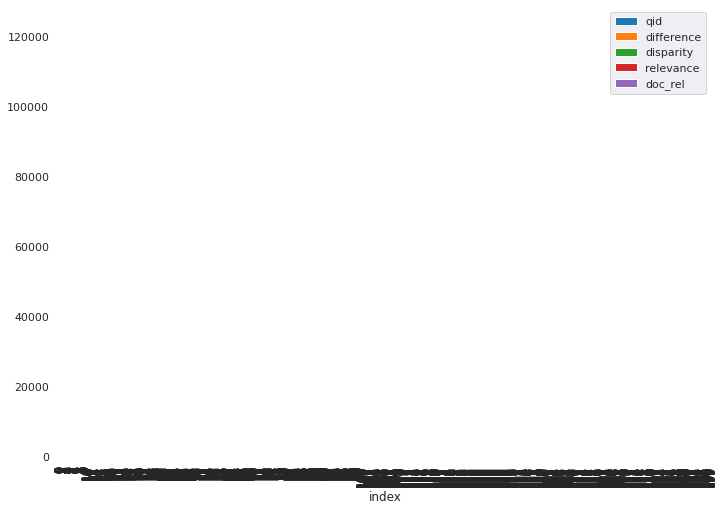

In [108]:
allmerge.set_index('index').plot(kind='bar', stacked=True)

In [109]:
data.head()

key  index    qid  difference  disparity  relevance   r  nr     rfrac  \
0        0  91643    0.019822   1.006921   0.868206  11   9  0.550000   
1        1   5191    0.044683   1.448939   1.344147   6   5  0.545455   
2        2  81479    0.046552   2.044160   1.889465   3   7  0.300000   
3        3  21237    0.053041   1.358547   1.149610   3  28  0.096774   
4        4   7363    0.053171   1.313280   1.085770   2  10  0.166667   

key    nrfrac  
0    0.450000  
1    0.454545  
2    0.700000  
3    0.903226  
4    0.833333

In [110]:
crossdata = pd.crosstab(data['index'],[data['doc_rel'],data['has_author']])

KeyError: 'doc_rel'

In [ ]:
crossdata.head().columns

In [ ]:
crossdata[(0,False)].to_list()

In [ ]:
crossdata.head().index.to_list()

In [ ]:
np.arange(len(rel_has_author)*2,step=2)

In [111]:
rel_has_author = np.array(crossdata[(1,True)].to_list())
rel_not_has_author = np.array(crossdata[(1,False)].to_list())
nonrel_has_author = np.array(crossdata[(0,True)].to_list())
nonrel_not_has_author = np.array(crossdata[(0,False)].to_list())
qid = crossdata.index.to_list()

with sns.axes_style("white"):
    sns.set(rc={'figure.figsize':(100,17)})
    sns.set_style("ticks")
    sns.set_context("talk")
    
    # plot details
    bar_width = 5
    epsilon = .015
    line_width = 1
    opacity = 0.7
    pos_bar_positions = np.arange(len(rel_has_author)*2*bar_width,step=2*bar_width)
    neg_bar_positions = pos_bar_positions + bar_width

    # make bar plots
    rel_has_author_bar = plt.bar(pos_bar_positions, rel_has_author, bar_width,
                              color='#ED0020',
                              label='rel + author')
    print(rel_has_author)
    rel_not_has_author_bar = plt.bar(pos_bar_positions, rel_not_has_author, bar_width-epsilon,
                              bottom=rel_has_author,
                              alpha=opacity,
                              color='white',
                              edgecolor='#ED0020',
                              linewidth=line_width,
                              hatch='//',
                              label='rel + no author')
    
    nonrel_has_author_bar = plt.bar(neg_bar_positions, nonrel_has_author, bar_width,
                              color='#0000DD',
                              label='not rel + author')
    nonrel_not_has_author_bar = plt.bar(neg_bar_positions, nonrel_not_has_author, bar_width-epsilon,
                              bottom=nonrel_has_author,
                              color="white",
                              hatch='//',
                              edgecolor='#0000DD',
                              ecolor="#0000DD",
                              linewidth=line_width,
                              label='not rel + no author')
    
    plt.xticks(neg_bar_positions, qid, rotation=90)
    plt.ylabel('Percentage of Samples')
    plt.legend(loc='best')
    sns.despine()

NameError: name 'crossdata' is not defined

In [ ]:
crossdata.index.to_list()[-10:]

In [ ]:
crossdata.index.to_list()[-10:]

In [ ]:
crossdata.index.to_list()[len(crossdata.index.to_list())-10:len(crossdata.index.to_list())]

In [ ]:
crossdata.index.to_list()[:10]

In [ ]:
def plot_has_authors(crossdata,k=10,asc=True):
    if asc:
        slstart = 0
        slend = k
    else:
        slstart = len(crossdata.index.to_list())-k
        slend = len(crossdata.index.to_list())
    
    
    rel_has_author = np.array(crossdata[(1,True)].to_list()[slstart:slend])
    rel_not_has_author = np.array(crossdata[(1,False)].to_list()[slstart:slend])
    nonrel_has_author = np.array(crossdata[(0,True)].to_list()[slstart:slend])
    nonrel_not_has_author = np.array(crossdata[(0,False)].to_list()[slstart:slend])
    qid = crossdata.index.to_list()[slstart:slend]

    with sns.axes_style("white"):
        sns.set(rc={'figure.figsize':(100,17)})
        sns.set_style("ticks")
        sns.set_context("talk")

        # plot details
        bar_width = 4
        epsilon = .015
        line_width = 1
        opacity = 0.7
        pos_bar_positions = np.arange(len(rel_has_author)*2*bar_width,step=2*bar_width)
        neg_bar_positions = pos_bar_positions + bar_width

        # make bar plots
        rel_has_author_bar = plt.bar(pos_bar_positions, rel_has_author, bar_width,
                                  color='#ED0020',
                                  label='rel + author')
        print(rel_has_author)
        rel_not_has_author_bar = plt.bar(pos_bar_positions, rel_not_has_author, bar_width-epsilon,
                                  bottom=rel_has_author,
                                  alpha=opacity,
                                  color='white',
                                  edgecolor='#ED0020',
                                  linewidth=line_width,
                                  hatch='//',
                                  label='rel + no author')

        nonrel_has_author_bar = plt.bar(neg_bar_positions, nonrel_has_author, bar_width,
                                  color='#0000DD',
                                  label='not rel + author')
        nonrel_not_has_author_bar = plt.bar(neg_bar_positions, nonrel_not_has_author, bar_width-epsilon,
                                  bottom=nonrel_has_author,
                                  color="white",
                                  hatch='//',
                                  edgecolor='#0000DD',
                                  ecolor="#0000DD",
                                  linewidth=line_width,
                                  label='not rel + no author')

        plt.xticks(neg_bar_positions, qid, rotation=90)
        plt.ylabel('Num docs')
        plt.legend(loc='best')
        sns.despine()

In [ ]:
plot_has_authors(crossdata)

In [ ]:
plot_has_authors(crossdata,asc=False)

In [ ]:
dat = crossdata.unstack().reset_index().rename({0:'count'},axis=1)
# dat[dat['index'] <= 10]

In [ ]:
dat = crossdata.unstack().reset_index().rename({0:'count'},axis=1)
# fig, ax = plt.subplots(1,1,figsize = (17.7,8.27))

g = sns.catplot(x="index", y="count",
                hue="has_author", col="doc_rel",
                data=dat[dat['index'] <= 20], kind="bar",
                height=4, aspect=1)
g.fig.set_size_inches(22,8.27)


In [ ]:
g = sns.catplot(x="index", y="count",
                hue="has_author", col="doc_rel",
                data=dat[dat['index'] >= len(dat['index'].unique()) - 20], kind="bar",
                height=4, aspect=1)
g.fig.set_size_inches(22,8.27)

Hypothesis was: bottom queries have many items without author


- Bottom queries mainly have nonrel items without author
- Top queries have both rel and nonrel items without author

Still to check: 


In [ ]:
est_rel_meta.describe()

In [ ]:
reldf.describe()

In [ ]:
pd.merge(est_rel_meta,reldf,on=['qid','doc_id'],how='outer').describe()

In [ ]:
est_and_rel = pd.merge(est_rel_meta,reldf,on=['qid','doc_id'],how='outer').fillna(0)
est_and_rel.head()

In [ ]:
 sns.stripplot(x="doc_rel", y="est_relevance", data=est_and_rel)

interestingly, none of the estimated values are very high? why is that? and there are three points that have rel 1 but are estimated very low, interesting to see if those cause some low results in the rankings

## Bibliography

[1] Buckley, ‘Reliable Information Access Final Workshop Report’.